In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install tensorflow

In [2]:
main_path = r'.'
data_path = main_path+'/data'
import sys
sys.path.append(main_path)
from BayDS.lib.pipeline import *
from typing import List, Set, Dict, Optional, Any, Tuple, Type, Union
from BayDS.lib.io import *
from BayDS.lib.training import *
import os
import pickle
from tqdm import tqdm

## Merging original features and best features

In [2]:
data = pd.read_pickle('./temp/data.pkl')

In [3]:
best_features = pd.read_parquet('./FE2/Corr_features_3155.pqt')


In [4]:
best_features['userid'] = data['userid']


In [5]:
for i in range(30):
    best_features[f'field{i}'] = data[f'field{i}']
    best_features[f'goal1'] = data[f'goal1']
for i in range(1,6):
    best_features[f'indicator_goal2{i}'] = data[f'indicator_goal2{i}']
    best_features[f'goal2{i}'] = data[f'goal2{i}']

In [10]:
del data
gc.collect()

0

In [6]:
for col in best_features.columns:
    if best_features[col].dtypes.name == 'object':
        best_features[col] = pd.Categorical(best_features[col])

In [7]:
best_features.to_parquet("./FE2/BEST3155+Orig.pqt")

In [9]:
best_features.index

Int64Index([1000000, 1000001, 1000002, 1000003, 1000004, 1000005, 1000006,
            1000007, 1000008, 1000009,
            ...
             455001,  455002,  455003,  455004,  455005,  455006,  455007,
             455008,  455009,  455010],
           dtype='int64', name='orderid', length=651067)

## Training


In [15]:
import dask.dataframe as dd
# best_features = pd.read_parquet("./FE3/unified_corr0.5_1645.pqt")
best_features = pd.read_parquet("./FE2/BEST3155+Orig.pqt")

initial_data = pd.read_pickle('./FE/initial_data.pkl')

exclude_features_from_training = ['indicator_goal21', 'indicator_goal22', 'indicator_goal23',
       'indicator_goal24', 'indicator_goal25', 'goal21', 'goal22', 'goal23','field12',
       'goal24', 'goal25', 'goal1','userid', 'order_till_hour', 'order_till_weekday', 'order_till_month', 'lang_country']

appended_features = pd.read_parquet('./FE_MANUAL/fe.pqt')

new_columns = [col for col in appended_features.columns if col not in best_features.columns]

best_features=pd.concat([best_features,appended_features[new_columns]],axis=1)

del appended_features
gc.collect()

oleg_features = pd.read_parquet('./FE4_OLEG/Corr_features_812.pqt')

for col in tqdm(oleg_features.columns):
    if col not in initial_data.columns:
        best_features[f'Oleg_{col}'] = oleg_features[col]

100%|████████████████████████████████████████████████████████████████████████████████| 812/812 [00:44<00:00, 18.19it/s]


### patch

In [16]:
def add_cat_changed(df,name='next', feature=''):
    changed_agg = lambda x: np.clip(np.abs(x.astype(np.float32)-x.astype(np.float32).shift(-1)).fillna(0),0,1).astype(np.uint8)
    ddt_index=df.loc[:,['userid','field4',cat]].reset_index().set_index(['userid','field4']).sort_index()
    ddt_index.loc[:,name] = ddt_index[feature].agg(changed_agg)
    return ddt_index.set_index('orderid')[name]

for cat in initial_data.columns:
    if initial_data[cat].dtype.name == 'category' and cat!='userid':
        initial_data[cat+'_changedFuture'] = add_cat_changed(initial_data, feature=cat) 
        train = initial_data[initial_data['goal1']>=0]
        print (cat, individual_gini(cat+'_changedFuture',train,train.goal1,-1))
        best_features[cat+'_changedFuture'] = initial_data[cat+'_changedFuture']

def shift(df,name='next', feature='field0', val=-1):
    shift_agg = lambda x: x.sort_index().shift(val)
    ddt_index=df.loc[:,['userid','field4',feature]].reset_index().set_index(['userid','field4']).sort_index()
    ddt_index.loc[:,name] = ddt_index[feature].agg(shift_agg)
    return ddt_index.set_index('orderid')[name]

initial_data['price1Future_dividedBy_price1'] = shift(initial_data,feature='price1')/initial_data['price1']
initial_data['price2Future_dividedBy_price2'] = shift(initial_data,feature='price2')/initial_data['price2']
train = initial_data[initial_data['goal1']>=0]
for cat in ('price1Future_dividedBy_price1', 'price2Future_dividedBy_price2'):
    print (cat, individual_gini(cat,train,train.goal1,-1))
    best_features[cat] = initial_data[cat]

for cat in initial_data.columns:
    if initial_data[cat].dtype.name != 'category' and cat!='userid' and cat!='field16' and cat not in exclude_features_from_training:
        initial_data[cat+'_mult'] = best_features['daysToNextOrder'] * initial_data[cat]
        initial_data[cat+'_div'] = best_features['daysToNextOrder'] / initial_data[cat]
        
        train = initial_data[initial_data['goal1']>=0]
        
        print (cat, individual_gini(cat+'_mult',train,train.goal1,-1))
        print (cat, individual_gini(cat+'_div',train,train.goal1,-1))
        
        best_features[cat+'_mult'] = initial_data[cat+'_mult']
        best_features[cat+'_div'] = initial_data[cat+'_div']

field12 0.8
field26 1.4000000000000001
field27 1.4000000000000001
field29 4.3999999999999995
field0bin 3.3000000000000003
field6bin 4.5
field13bin 6.1
field16bin 0.7000000000000001
field17bin 2.9000000000000004
field22bin 6.800000000000001
field25bin 5.0
price1bin 2.4
price2bin 1.0
price1Future_dividedBy_price1 9.5
price2Future_dividedBy_price2 10.299999999999999
field0 2.1999999999999997
field0 7.3999999999999995
field1 9.8
field1 7.3999999999999995
field2 4.0
field2 5.7
field3 4.6
field3 4.9
field4 7.000000000000001
field4 3.9
field5 3.9
field5 6.4
field6 3.6999999999999997
field6 9.0
field7 4.3999999999999995
field7 6.9
field8 5.8999999999999995
field8 12.1
field9 0.1
field9 0.3
field10 2.3
field10 6.4
field11 6.3
field11 4.9
field13 4.3
field13 6.4
field14 8.6
field14 9.2
field15 5.2
field15 5.2
field17 4.9
field17 6.3
field18 4.6
field18 5.1
field19 5.800000000000001
field19 5.3
field20 6.0
field20 4.8
field21 5.800000000000001
field21 4.0
field22 3.8
field22 7.199999999999999
fie

In [17]:
del oleg_features
gc.collect()

del train, initial_data
gc.collect()

0

In [25]:
# best_features.to_parquet('./temp/3155+Manual+812Oleg+patch.pqt')


# best_features = pd.read_parquet('./temp/3155+Manual+Oleg.pqt')

In [6]:
train_idx = best_features[best_features['goal1']>=0].index
test_idx = best_features[best_features['goal1']<0].index
X = best_features.loc[train_idx]
y = best_features[best_features['goal1']>=0]['goal1']
test=best_features.loc[test_idx]
train_features = [f for f in best_features.columns if f not in exclude_features_from_training]

y = y.astype(np.uint8)

del best_features
gc.collect()

0

In [7]:
import numpy as np
from collections import Counter, defaultdict
from sklearn.utils import check_random_state

class RepeatedStratifiedGroupKFold():

    def __init__(self, n_splits=5, n_repeats=1, random_state=69):
        self.n_splits = n_splits
        self.n_repeats = n_repeats
        self.random_state = random_state
        
    # Implementation based on this kaggle kernel:
    #    https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation
    def split(self, X, y=None, groups=None):
        k = self.n_splits
        def eval_y_counts_per_fold(y_counts, fold):
            y_counts_per_fold[fold] += y_counts
            std_per_label = []
            for label in range(labels_num):
                label_std = np.std(
                    [y_counts_per_fold[i][label] / y_distr[label] for i in range(k)]
                )
                std_per_label.append(label_std)
            y_counts_per_fold[fold] -= y_counts
            return np.mean(std_per_label)
            
        rnd = check_random_state(self.random_state)
        for repeat in range(self.n_repeats):
            labels_num = np.max(y) + 1
            y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
            y_distr = Counter()
            for label, g in zip(y, groups):
                y_counts_per_group[g][label] += 1
                y_distr[label] += 1

            y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
            groups_per_fold = defaultdict(set)
        
            groups_and_y_counts = list(y_counts_per_group.items())
            rnd.shuffle(groups_and_y_counts)

            for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
                best_fold = None
                min_eval = None
                for i in range(k):
                    fold_eval = eval_y_counts_per_fold(y_counts, i)
                    if min_eval is None or fold_eval < min_eval:
                        min_eval = fold_eval
                        best_fold = i
                y_counts_per_fold[best_fold] += y_counts
                groups_per_fold[best_fold].add(g)

            all_groups = set(groups)
            for i in range(k):
                train_groups = all_groups - groups_per_fold[i]
                test_groups = groups_per_fold[i]

                train_indices = [i for i, g in enumerate(groups) if g in train_groups]
                test_indices = [i for i, g in enumerate(groups) if g in test_groups]

                yield train_indices, test_indices

from sklearn.model_selection import GroupKFold, KFold

Fold 1 started at Sun Jan 19 23:44:58 2020
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.714043	training's auc: 0.714043	valid_1's auc: 0.701785	valid_1's auc: 0.701784
[200]	training's auc: 0.732203	training's auc: 0.732203	valid_1's auc: 0.708856	valid_1's auc: 0.708856
[300]	training's auc: 0.744452	training's auc: 0.744452	valid_1's auc: 0.711984	valid_1's auc: 0.711983
[400]	training's auc: 0.755199	training's auc: 0.755199	valid_1's auc: 0.714123	valid_1's auc: 0.714123
[500]	training's auc: 0.764655	training's auc: 0.764654	valid_1's auc: 0.715513	valid_1's auc: 0.715513
[600]	training's auc: 0.77254	training's auc: 0.77254	valid_1's auc: 0.716598	valid_1's auc: 0.716598
[700]	training's auc: 0.77961	training's auc: 0.77961	valid_1's auc: 0.718247	valid_1's auc: 0.718247
[800]	training's auc: 0.78558	training's auc: 0.78558	valid_1's auc: 0.719013	valid_1's auc: 0.719013
[900]	training's auc: 0.791165	training's auc: 0.791165	valid_1's auc

Fold 5 started at Mon Jan 20 00:08:17 2020
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.712755	training's auc: 0.712753	valid_1's auc: 0.697212	valid_1's auc: 0.697212
[200]	training's auc: 0.732008	training's auc: 0.732008	valid_1's auc: 0.708607	valid_1's auc: 0.708607
[300]	training's auc: 0.744412	training's auc: 0.744412	valid_1's auc: 0.713166	valid_1's auc: 0.713166
[400]	training's auc: 0.754563	training's auc: 0.754563	valid_1's auc: 0.715089	valid_1's auc: 0.715089
[500]	training's auc: 0.762627	training's auc: 0.762627	valid_1's auc: 0.715598	valid_1's auc: 0.715598
[600]	training's auc: 0.770758	training's auc: 0.770758	valid_1's auc: 0.715961	valid_1's auc: 0.715961
[700]	training's auc: 0.77756	training's auc: 0.77756	valid_1's auc: 0.716681	valid_1's auc: 0.716681
[800]	training's auc: 0.783439	training's auc: 0.783439	valid_1's auc: 0.717274	valid_1's auc: 0.717274
[900]	training's auc: 0.7893	training's auc: 0.7893	valid_1's auc

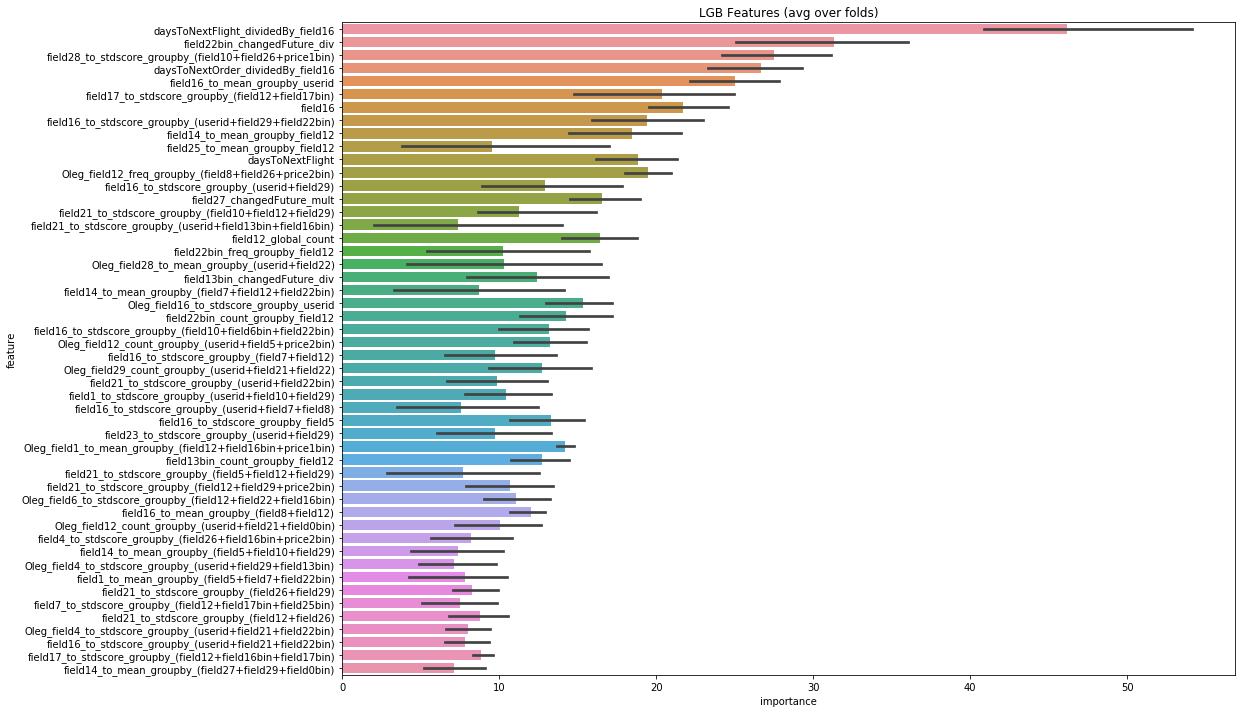

In [8]:
### Best options from 0.6969
NFOLDS = 5
folds = RepeatedStratifiedGroupKFold(n_splits=NFOLDS)
params = {
          "verbosity": -1,
          'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': 4,
          'learning_rate': 0.005,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }
train_options = {
        "model_type":'lgb',
        "params": params,
        "eval_metric":'auc',
        'early_stopping_rounds': 100,
        'n_estimators': 3000,
        'averaging': 'rank',
        'use_groups': False,
        'fold_name': folds.__class__.__name__,
        'n_splits': NFOLDS
    }
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

In [9]:
###SAVE RESULTS
import datetime
t = datetime.datetime.now().strftime("%m-%d-%H-%M")
test['proba'] = result_dict['prediction']
sub = pd.read_csv('data/onetwotrip_challenge_sub1.csv')
sub['proba'] = test['proba'] / test['proba'].max()
sub.reset_index(drop=True).set_index('orderid').to_csv(f'temp/submission-{t}.csv')

import pickle
pickle.dump(result_dict, open(f'temp/submission-{t}.pkl','wb'))

Fold 1 started at Sun Jan 19 21:02:58 2020
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.713567	training's auc: 0.713564	valid_1's auc: 0.70152	valid_1's auc: 0.701515
[200]	training's auc: 0.730284	training's auc: 0.730285	valid_1's auc: 0.708183	valid_1's auc: 0.708184
[300]	training's auc: 0.743169	training's auc: 0.743169	valid_1's auc: 0.712165	valid_1's auc: 0.712165
[400]	training's auc: 0.753574	training's auc: 0.753574	valid_1's auc: 0.714189	valid_1's auc: 0.714189
[500]	training's auc: 0.762487	training's auc: 0.762487	valid_1's auc: 0.715072	valid_1's auc: 0.715072
[600]	training's auc: 0.770146	training's auc: 0.770146	valid_1's auc: 0.717006	valid_1's auc: 0.717006
[700]	training's auc: 0.77671	training's auc: 0.77671	valid_1's auc: 0.718848	valid_1's auc: 0.718848
[800]	training's auc: 0.782465	training's auc: 0.782465	valid_1's auc: 0.720287	valid_1's auc: 0.720287
[900]	training's auc: 0.787934	training's auc: 0.787934	valid_1's 

[1300]	training's auc: 0.80651	training's auc: 0.80651	valid_1's auc: 0.708492	valid_1's auc: 0.708492
[1400]	training's auc: 0.810336	training's auc: 0.810336	valid_1's auc: 0.70888	valid_1's auc: 0.70888
[1500]	training's auc: 0.814033	training's auc: 0.814033	valid_1's auc: 0.709052	valid_1's auc: 0.709052
[1600]	training's auc: 0.817645	training's auc: 0.817645	valid_1's auc: 0.709156	valid_1's auc: 0.709156
[1700]	training's auc: 0.821079	training's auc: 0.821079	valid_1's auc: 0.709363	valid_1's auc: 0.709363
[1800]	training's auc: 0.824832	training's auc: 0.824832	valid_1's auc: 0.709594	valid_1's auc: 0.709594
[1900]	training's auc: 0.828195	training's auc: 0.828195	valid_1's auc: 0.709708	valid_1's auc: 0.709708
[2000]	training's auc: 0.831198	training's auc: 0.831198	valid_1's auc: 0.709647	valid_1's auc: 0.709647
Early stopping, best iteration is:
[1969]	training's auc: 0.830332	training's auc: 0.830332	valid_1's auc: 0.709751	valid_1's auc: 0.709751
Fold 5 started at Sun Ja

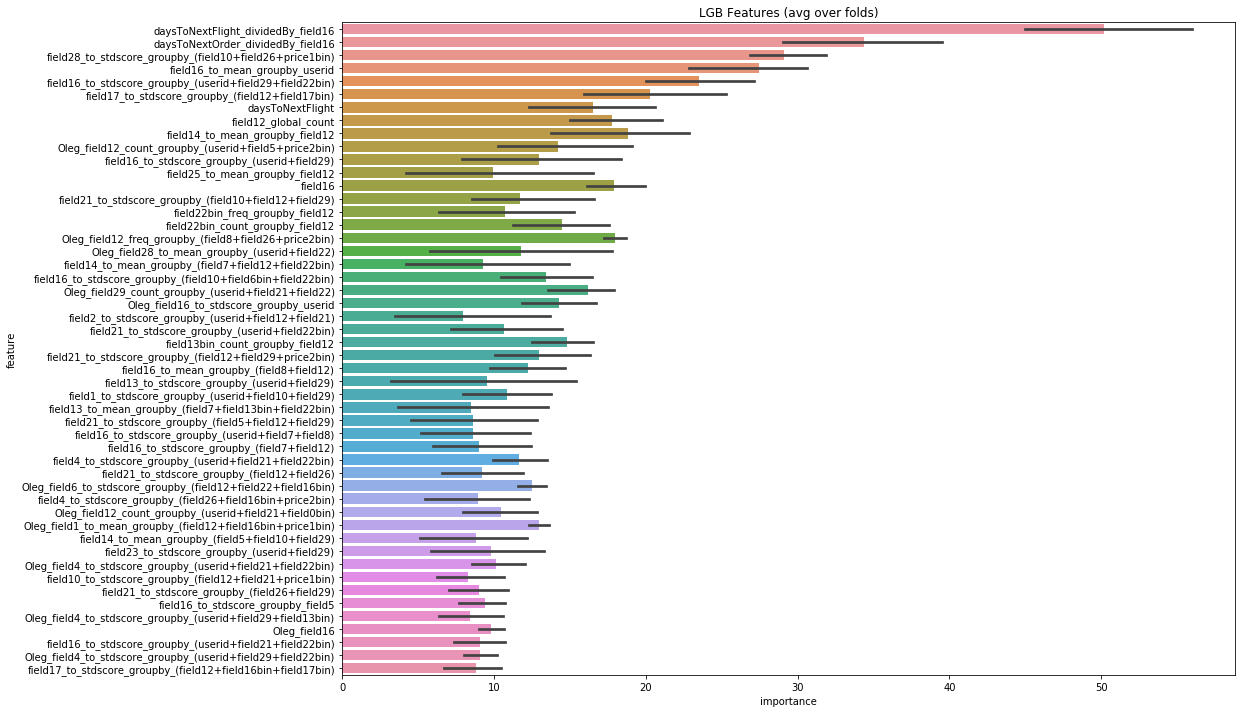

In [14]:
### 70.17
NFOLDS = 5
folds = RepeatedStratifiedGroupKFold(n_splits=NFOLDS)
params = {
          "verbosity": -1,
          'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': 4,
          'learning_rate': 0.005,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }
train_options = {
        "model_type":'lgb',
        "params": params,
        "eval_metric":'auc',
        'early_stopping_rounds': 100,
        'n_estimators': 3000,
        'averaging': 'rank',
        'use_groups': False,
        'fold_name': folds.__class__.__name__,
        'n_splits': NFOLDS
    }
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Fri Jan 10 18:42:40 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.711483	training's auc: 0.711481	valid_1's auc: 0.698136	valid_1's auc: 0.698145
[200]	training's auc: 0.725807	training's auc: 0.725807	valid_1's auc: 0.704334	valid_1's auc: 0.704335
[300]	training's auc: 0.737216	training's auc: 0.737216	valid_1's auc: 0.708803	valid_1's auc: 0.708803
[400]	training's auc: 0.748113	training's auc: 0.748113	valid_1's auc: 0.712596	valid_1's auc: 0.712596
[500]	training's auc: 0.757627	training's auc: 0.757627	valid_1's auc: 0.714213	valid_1's auc: 0.714213
[600]	training's auc: 0.765708	training's auc: 0.765708	valid_1's auc: 0.715192	valid_1's auc: 0.715192
[700]	training's auc: 0.773055	training's auc: 0.773055	valid_1's auc: 0.716888	valid_1's auc: 0.716888
[800]	training's auc: 0.778936	training's auc: 0.778936	valid_1's auc: 0.718209	valid_1's auc: 0.71821
[900]	training's auc: 0.784652	training's auc: 0.784652	valid_1

[600]	training's auc: 0.766371	training's auc: 0.76637	valid_1's auc: 0.698712	valid_1's auc: 0.698712
[700]	training's auc: 0.773521	training's auc: 0.773521	valid_1's auc: 0.698833	valid_1's auc: 0.698833
[800]	training's auc: 0.779758	training's auc: 0.779758	valid_1's auc: 0.699347	valid_1's auc: 0.699346
[900]	training's auc: 0.785033	training's auc: 0.785033	valid_1's auc: 0.699905	valid_1's auc: 0.699905
[1000]	training's auc: 0.789876	training's auc: 0.789876	valid_1's auc: 0.700226	valid_1's auc: 0.700226
[1100]	training's auc: 0.794254	training's auc: 0.794254	valid_1's auc: 0.700661	valid_1's auc: 0.700661
[1200]	training's auc: 0.798703	training's auc: 0.798703	valid_1's auc: 0.701261	valid_1's auc: 0.701261
[1300]	training's auc: 0.802861	training's auc: 0.802861	valid_1's auc: 0.701463	valid_1's auc: 0.701463
[1400]	training's auc: 0.806864	training's auc: 0.806864	valid_1's auc: 0.701521	valid_1's auc: 0.701521
[1500]	training's auc: 0.810897	training's auc: 0.810897	val

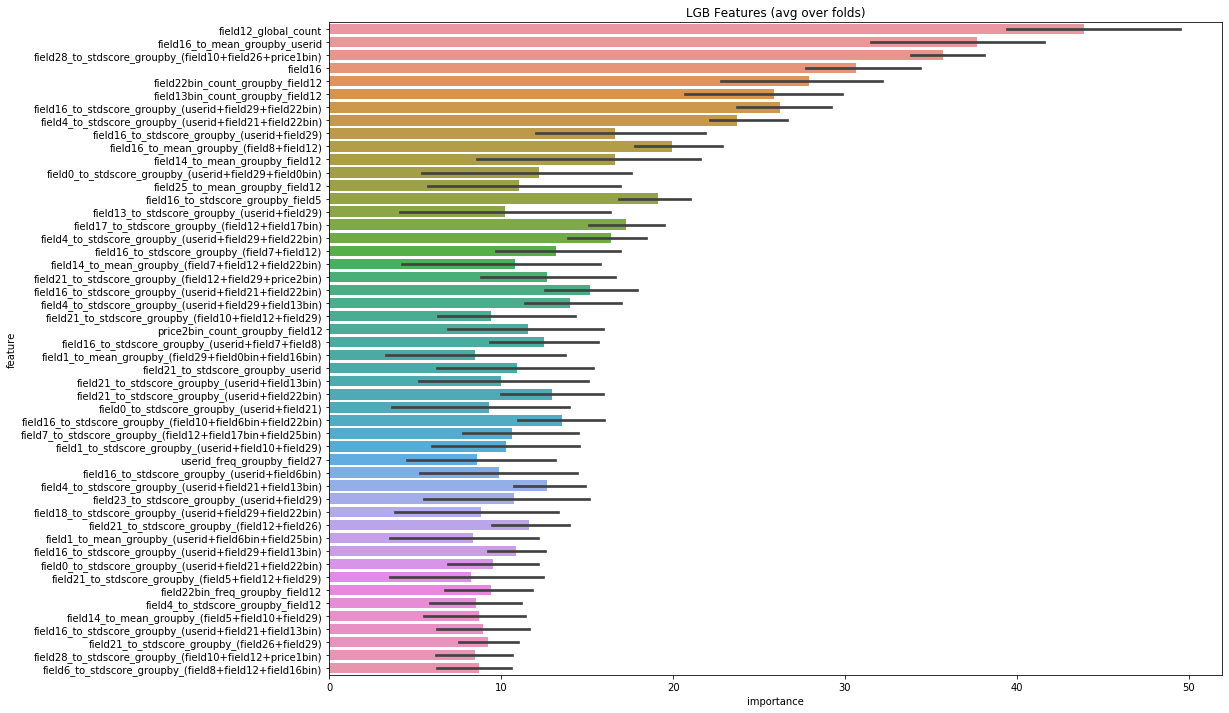

In [10]:
#latest lgb params
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Wed Jan 15 19:44:51 2020
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.69543	training's auc: 0.695432	valid_1's auc: 0.689357	valid_1's auc: 0.689351
[200]	training's auc: 0.698301	training's auc: 0.698301	valid_1's auc: 0.690463	valid_1's auc: 0.690465
[300]	training's auc: 0.700448	training's auc: 0.700449	valid_1's auc: 0.691048	valid_1's auc: 0.691048
[400]	training's auc: 0.702842	training's auc: 0.702843	valid_1's auc: 0.692245	valid_1's auc: 0.692243
[500]	training's auc: 0.704998	training's auc: 0.704998	valid_1's auc: 0.692189	valid_1's auc: 0.692187
[600]	training's auc: 0.70689	training's auc: 0.70689	valid_1's auc: 0.692482	valid_1's auc: 0.692482
[700]	training's auc: 0.70895	training's auc: 0.70895	valid_1's auc: 0.693169	valid_1's auc: 0.693169
[800]	training's auc: 0.711061	training's auc: 0.711062	valid_1's auc: 0.693683	valid_1's auc: 0.693683
[900]	training's auc: 0.71333	training's auc: 0.71333	valid_1's auc:

[7900]	training's auc: 0.805516	training's auc: 0.805516	valid_1's auc: 0.713386	valid_1's auc: 0.713386
[8000]	training's auc: 0.806259	training's auc: 0.806259	valid_1's auc: 0.713371	valid_1's auc: 0.713371
[8100]	training's auc: 0.807001	training's auc: 0.807001	valid_1's auc: 0.713397	valid_1's auc: 0.713397
[8200]	training's auc: 0.807774	training's auc: 0.807774	valid_1's auc: 0.713444	valid_1's auc: 0.713444
[8300]	training's auc: 0.80853	training's auc: 0.80853	valid_1's auc: 0.713452	valid_1's auc: 0.713452
[8400]	training's auc: 0.809251	training's auc: 0.809251	valid_1's auc: 0.713475	valid_1's auc: 0.713475
[8500]	training's auc: 0.809941	training's auc: 0.809941	valid_1's auc: 0.713481	valid_1's auc: 0.713481
[8600]	training's auc: 0.810611	training's auc: 0.810611	valid_1's auc: 0.713495	valid_1's auc: 0.713495
[8700]	training's auc: 0.811306	training's auc: 0.811306	valid_1's auc: 0.713477	valid_1's auc: 0.713477
[8800]	training's auc: 0.812002	training's auc: 0.812002	

[6300]	training's auc: 0.792006	training's auc: 0.792006	valid_1's auc: 0.688833	valid_1's auc: 0.688833
[6400]	training's auc: 0.792871	training's auc: 0.792871	valid_1's auc: 0.688932	valid_1's auc: 0.688932
[6500]	training's auc: 0.793745	training's auc: 0.793745	valid_1's auc: 0.689009	valid_1's auc: 0.689009
[6600]	training's auc: 0.794649	training's auc: 0.794649	valid_1's auc: 0.689132	valid_1's auc: 0.689132
[6700]	training's auc: 0.795489	training's auc: 0.795489	valid_1's auc: 0.689204	valid_1's auc: 0.689204
[6800]	training's auc: 0.796282	training's auc: 0.796282	valid_1's auc: 0.689292	valid_1's auc: 0.689292
[6900]	training's auc: 0.797126	training's auc: 0.797126	valid_1's auc: 0.689407	valid_1's auc: 0.689407
[7000]	training's auc: 0.797977	training's auc: 0.797977	valid_1's auc: 0.689502	valid_1's auc: 0.689502
[7100]	training's auc: 0.79876	training's auc: 0.79876	valid_1's auc: 0.689587	valid_1's auc: 0.689587
[7200]	training's auc: 0.799575	training's auc: 0.799575	

[3800]	training's auc: 0.766216	training's auc: 0.766216	valid_1's auc: 0.692308	valid_1's auc: 0.692308
[3900]	training's auc: 0.76747	training's auc: 0.76747	valid_1's auc: 0.692571	valid_1's auc: 0.692571
[4000]	training's auc: 0.768652	training's auc: 0.768652	valid_1's auc: 0.692889	valid_1's auc: 0.692889
[4100]	training's auc: 0.769793	training's auc: 0.769793	valid_1's auc: 0.693127	valid_1's auc: 0.693127
[4200]	training's auc: 0.770931	training's auc: 0.770931	valid_1's auc: 0.693342	valid_1's auc: 0.693343
[4300]	training's auc: 0.772075	training's auc: 0.772075	valid_1's auc: 0.693626	valid_1's auc: 0.693626
[4400]	training's auc: 0.773265	training's auc: 0.773265	valid_1's auc: 0.693882	valid_1's auc: 0.693882
[4500]	training's auc: 0.774386	training's auc: 0.774386	valid_1's auc: 0.694068	valid_1's auc: 0.694068
[4600]	training's auc: 0.775539	training's auc: 0.775539	valid_1's auc: 0.694349	valid_1's auc: 0.694349
[4700]	training's auc: 0.776592	training's auc: 0.776592	

[11700]	training's auc: 0.829753	training's auc: 0.829753	valid_1's auc: 0.699322	valid_1's auc: 0.699322
[11800]	training's auc: 0.830275	training's auc: 0.830275	valid_1's auc: 0.699334	valid_1's auc: 0.699334
[11900]	training's auc: 0.830852	training's auc: 0.830852	valid_1's auc: 0.699347	valid_1's auc: 0.699347
[12000]	training's auc: 0.8314	training's auc: 0.8314	valid_1's auc: 0.699349	valid_1's auc: 0.699349
[12100]	training's auc: 0.831974	training's auc: 0.831974	valid_1's auc: 0.699358	valid_1's auc: 0.699358
[12200]	training's auc: 0.832564	training's auc: 0.832564	valid_1's auc: 0.699369	valid_1's auc: 0.699369
[12300]	training's auc: 0.833089	training's auc: 0.833089	valid_1's auc: 0.699369	valid_1's auc: 0.699369
Early stopping, best iteration is:
[12027]	training's auc: 0.831552	training's auc: 0.831552	valid_1's auc: 0.699383	valid_1's auc: 0.699383
Fold 4 started at Wed Jan 15 20:17:55 2020
Training until validation scores don't improve for 300 rounds
[100]	training's

[7100]	training's auc: 0.79833	training's auc: 0.79833	valid_1's auc: 0.69832	valid_1's auc: 0.69832
[7200]	training's auc: 0.799164	training's auc: 0.799164	valid_1's auc: 0.698378	valid_1's auc: 0.698378
[7300]	training's auc: 0.799968	training's auc: 0.799968	valid_1's auc: 0.698402	valid_1's auc: 0.698402
[7400]	training's auc: 0.800739	training's auc: 0.800739	valid_1's auc: 0.698446	valid_1's auc: 0.698446
[7500]	training's auc: 0.801551	training's auc: 0.801551	valid_1's auc: 0.698498	valid_1's auc: 0.698498
[7600]	training's auc: 0.802298	training's auc: 0.802298	valid_1's auc: 0.698601	valid_1's auc: 0.698601
[7700]	training's auc: 0.803063	training's auc: 0.803063	valid_1's auc: 0.698742	valid_1's auc: 0.698742
[7800]	training's auc: 0.803802	training's auc: 0.803802	valid_1's auc: 0.698813	valid_1's auc: 0.698813
[7900]	training's auc: 0.804571	training's auc: 0.804571	valid_1's auc: 0.698843	valid_1's auc: 0.698844
[8000]	training's auc: 0.805317	training's auc: 0.805317	va

[3200]	training's auc: 0.754902	training's auc: 0.754902	valid_1's auc: 0.706465	valid_1's auc: 0.706465
[3300]	training's auc: 0.7563	training's auc: 0.7563	valid_1's auc: 0.706674	valid_1's auc: 0.706674
[3400]	training's auc: 0.757735	training's auc: 0.757735	valid_1's auc: 0.70684	valid_1's auc: 0.70684
[3500]	training's auc: 0.759121	training's auc: 0.759121	valid_1's auc: 0.707024	valid_1's auc: 0.707024
[3600]	training's auc: 0.760528	training's auc: 0.760528	valid_1's auc: 0.707244	valid_1's auc: 0.707244
[3700]	training's auc: 0.761851	training's auc: 0.761851	valid_1's auc: 0.707432	valid_1's auc: 0.707432
[3800]	training's auc: 0.763194	training's auc: 0.763194	valid_1's auc: 0.70756	valid_1's auc: 0.70756
[3900]	training's auc: 0.764495	training's auc: 0.764495	valid_1's auc: 0.707805	valid_1's auc: 0.707805
[4000]	training's auc: 0.765708	training's auc: 0.765708	valid_1's auc: 0.707932	valid_1's auc: 0.707932
[4100]	training's auc: 0.767021	training's auc: 0.767021	valid_

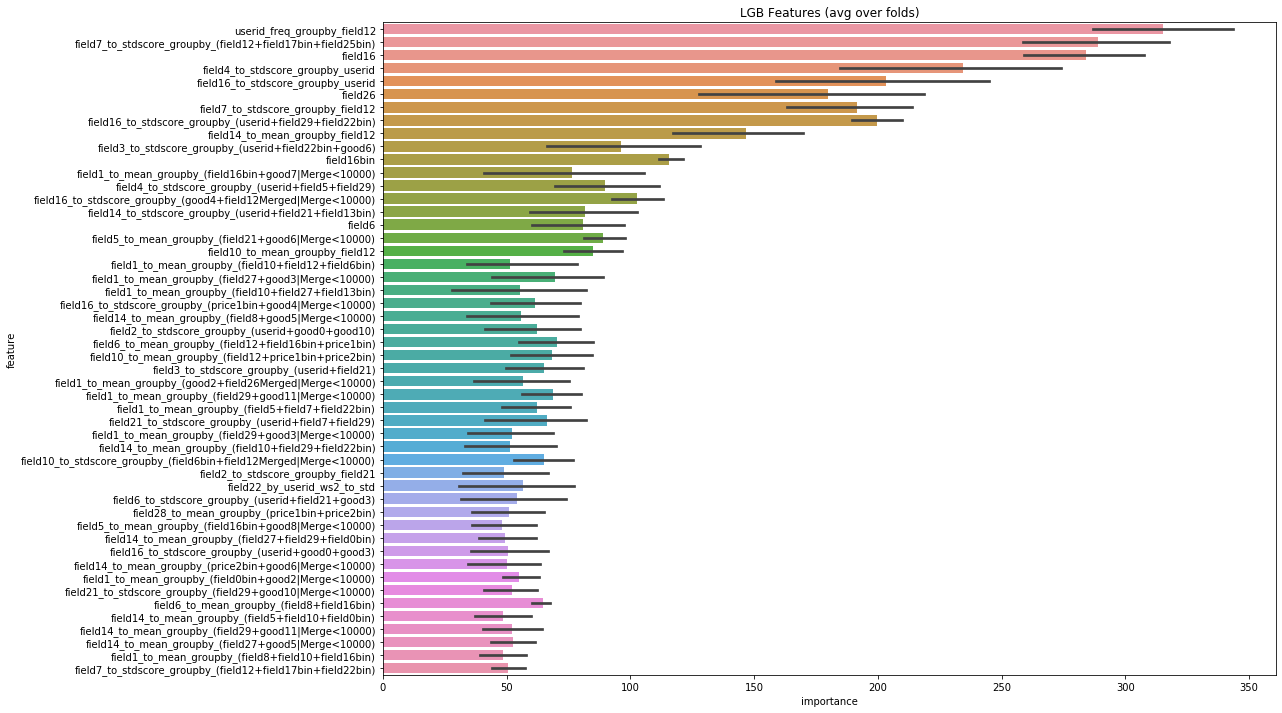

In [17]:
# Hardly correlated features
params = {
          "verbosity": -1,
          'num_leaves': 491,
#           'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.1797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': 4,
          'learning_rate': 0.001,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
#           'reg_alpha': 0.3899927210061127,
#           'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }
train_options = {
        "model_type":'lgb',
        "params": params,
        "eval_metric":'auc',
        'early_stopping_rounds': 300,
        'n_estimators': 30000,
        'averaging': 'rank',
        'use_groups': False,
        'fold_name': folds.__class__.__name__,
        'n_splits': NFOLDS
    }
gc.collect()
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Wed Jan 15 19:25:58 2020
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.704593	training's auc: 0.704592	valid_1's auc: 0.690761	valid_1's auc: 0.69076
[200]	training's auc: 0.71665	training's auc: 0.71665	valid_1's auc: 0.69591	valid_1's auc: 0.695911
[300]	training's auc: 0.727872	training's auc: 0.727873	valid_1's auc: 0.699998	valid_1's auc: 0.699998
[400]	training's auc: 0.738252	training's auc: 0.738252	valid_1's auc: 0.703496	valid_1's auc: 0.703496
[500]	training's auc: 0.747447	training's auc: 0.747446	valid_1's auc: 0.705885	valid_1's auc: 0.705885
[600]	training's auc: 0.756255	training's auc: 0.756255	valid_1's auc: 0.707809	valid_1's auc: 0.707809
[700]	training's auc: 0.763381	training's auc: 0.763381	valid_1's auc: 0.709735	valid_1's auc: 0.709735
[800]	training's auc: 0.769942	training's auc: 0.769942	valid_1's auc: 0.710825	valid_1's auc: 0.710825
[900]	training's auc: 0.776563	training's auc: 0.776563	valid_1's a

[100]	training's auc: 0.708425	training's auc: 0.708428	valid_1's auc: 0.677977	valid_1's auc: 0.677983
[200]	training's auc: 0.720402	training's auc: 0.720403	valid_1's auc: 0.681121	valid_1's auc: 0.681122
[300]	training's auc: 0.731487	training's auc: 0.731488	valid_1's auc: 0.684348	valid_1's auc: 0.68435
[400]	training's auc: 0.741164	training's auc: 0.741164	valid_1's auc: 0.687635	valid_1's auc: 0.687635
[500]	training's auc: 0.749481	training's auc: 0.74948	valid_1's auc: 0.689647	valid_1's auc: 0.689647
[600]	training's auc: 0.757579	training's auc: 0.757579	valid_1's auc: 0.691228	valid_1's auc: 0.691228
[700]	training's auc: 0.764933	training's auc: 0.764933	valid_1's auc: 0.692964	valid_1's auc: 0.692964
[800]	training's auc: 0.771133	training's auc: 0.771133	valid_1's auc: 0.694271	valid_1's auc: 0.694271
[900]	training's auc: 0.777336	training's auc: 0.777336	valid_1's auc: 0.695057	valid_1's auc: 0.695057
[1000]	training's auc: 0.783179	training's auc: 0.783179	valid_1's

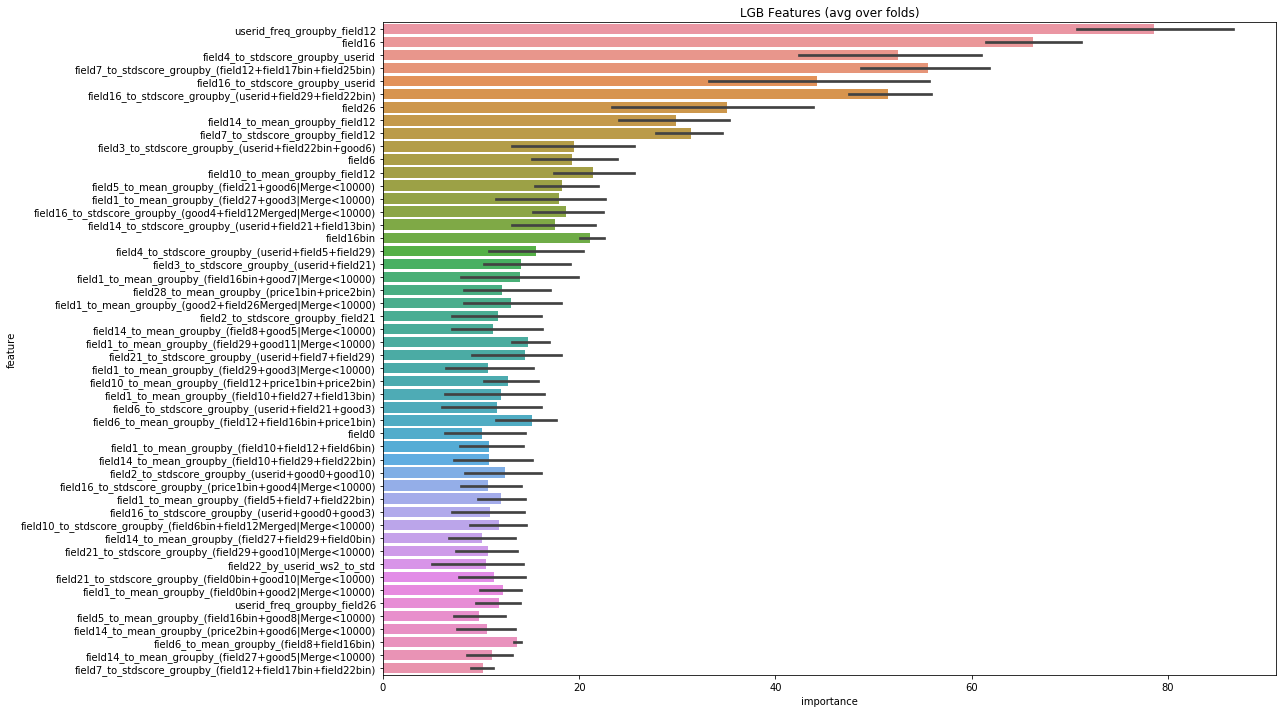

In [14]:
# Hardly correlated features
gc.collect()
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Wed Jan 15 08:43:21 2020
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.711113	training's auc: 0.711111	valid_1's auc: 0.701419	valid_1's auc: 0.70144
[200]	training's auc: 0.725332	training's auc: 0.725332	valid_1's auc: 0.707203	valid_1's auc: 0.7072
[300]	training's auc: 0.736208	training's auc: 0.736208	valid_1's auc: 0.710849	valid_1's auc: 0.71085
[400]	training's auc: 0.746541	training's auc: 0.746542	valid_1's auc: 0.713929	valid_1's auc: 0.71393
[500]	training's auc: 0.755655	training's auc: 0.755655	valid_1's auc: 0.715164	valid_1's auc: 0.715164
[600]	training's auc: 0.763348	training's auc: 0.763348	valid_1's auc: 0.71648	valid_1's auc: 0.71648
[700]	training's auc: 0.770072	training's auc: 0.770072	valid_1's auc: 0.718081	valid_1's auc: 0.718081
[800]	training's auc: 0.77592	training's auc: 0.775919	valid_1's auc: 0.719518	valid_1's auc: 0.719518
[900]	training's auc: 0.781541	training's auc: 0.781541	valid_1's auc: 

[1900]	training's auc: 0.820486	training's auc: 0.820486	valid_1's auc: 0.707605	valid_1's auc: 0.707605
[2000]	training's auc: 0.823336	training's auc: 0.823336	valid_1's auc: 0.707888	valid_1's auc: 0.707888
[2100]	training's auc: 0.826304	training's auc: 0.826304	valid_1's auc: 0.708185	valid_1's auc: 0.708185
[2200]	training's auc: 0.829006	training's auc: 0.829006	valid_1's auc: 0.708173	valid_1's auc: 0.708173
[2300]	training's auc: 0.83165	training's auc: 0.83165	valid_1's auc: 0.708237	valid_1's auc: 0.708237
[2400]	training's auc: 0.83417	training's auc: 0.83417	valid_1's auc: 0.708313	valid_1's auc: 0.708313
[2500]	training's auc: 0.836654	training's auc: 0.836654	valid_1's auc: 0.708445	valid_1's auc: 0.708445
[2600]	training's auc: 0.839078	training's auc: 0.839078	valid_1's auc: 0.708476	valid_1's auc: 0.708476
[2700]	training's auc: 0.841279	training's auc: 0.841279	valid_1's auc: 0.708664	valid_1's auc: 0.708664
[2800]	training's auc: 0.843611	training's auc: 0.843611	va

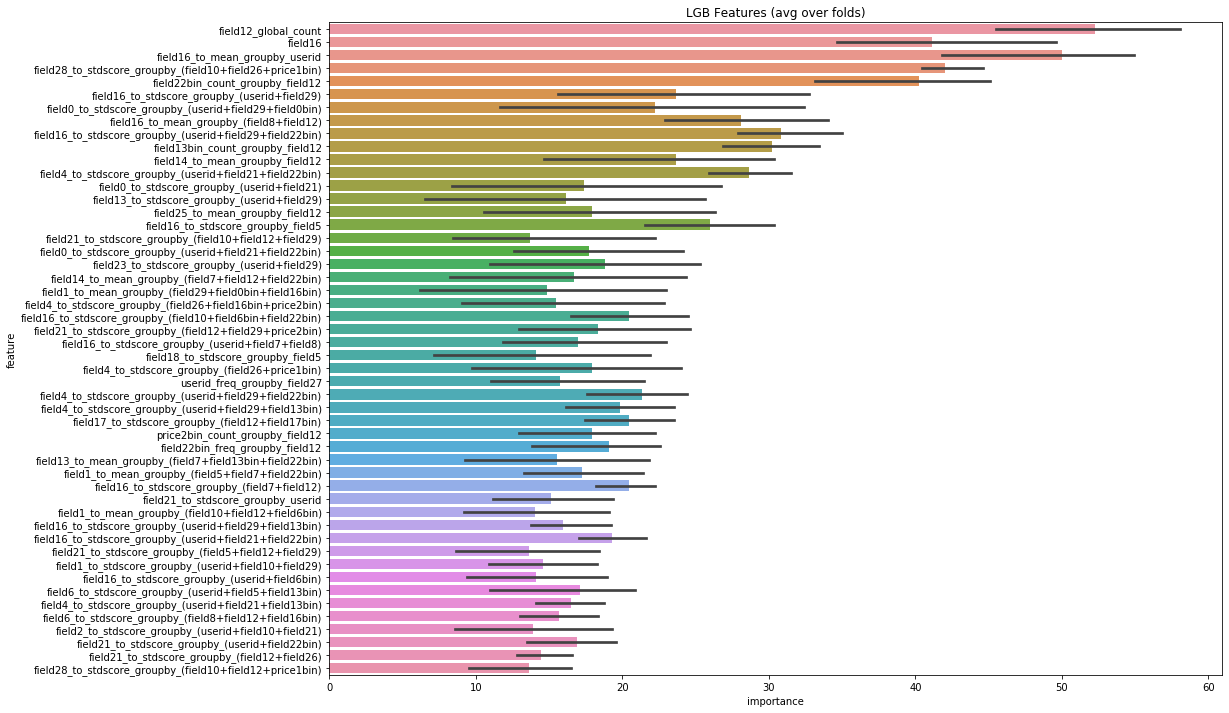

In [36]:
# 771 AGGCV features
gc.collect()
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Wed Jan 15 08:29:21 2020
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.711058	training's auc: 0.711064	valid_1's auc: 0.702169	valid_1's auc: 0.702176
[200]	training's auc: 0.722472	training's auc: 0.722468	valid_1's auc: 0.706794	valid_1's auc: 0.706795
[300]	training's auc: 0.732856	training's auc: 0.732856	valid_1's auc: 0.710294	valid_1's auc: 0.710292
[400]	training's auc: 0.742512	training's auc: 0.742512	valid_1's auc: 0.714059	valid_1's auc: 0.714059
[500]	training's auc: 0.750539	training's auc: 0.750539	valid_1's auc: 0.716145	valid_1's auc: 0.716145
[600]	training's auc: 0.757572	training's auc: 0.757572	valid_1's auc: 0.717717	valid_1's auc: 0.717717
[700]	training's auc: 0.763672	training's auc: 0.763672	valid_1's auc: 0.719434	valid_1's auc: 0.719434
[800]	training's auc: 0.769078	training's auc: 0.769078	valid_1's auc: 0.72119	valid_1's auc: 0.72119
[900]	training's auc: 0.774171	training's auc: 0.774171	valid_1's

[2000]	training's auc: 0.815685	training's auc: 0.815685	valid_1's auc: 0.708097	valid_1's auc: 0.708097
[2100]	training's auc: 0.818344	training's auc: 0.818344	valid_1's auc: 0.708173	valid_1's auc: 0.708173
[2200]	training's auc: 0.821148	training's auc: 0.821148	valid_1's auc: 0.708469	valid_1's auc: 0.708469
[2300]	training's auc: 0.823949	training's auc: 0.823949	valid_1's auc: 0.708595	valid_1's auc: 0.708595
[2400]	training's auc: 0.826262	training's auc: 0.826262	valid_1's auc: 0.708804	valid_1's auc: 0.708804
[2500]	training's auc: 0.828623	training's auc: 0.828623	valid_1's auc: 0.70877	valid_1's auc: 0.70877
[2600]	training's auc: 0.83076	training's auc: 0.83076	valid_1's auc: 0.708829	valid_1's auc: 0.708829
[2700]	training's auc: 0.832995	training's auc: 0.832995	valid_1's auc: 0.70882	valid_1's auc: 0.70882
[2800]	training's auc: 0.835093	training's auc: 0.835093	valid_1's auc: 0.708958	valid_1's auc: 0.708958
[2900]	training's auc: 0.837143	training's auc: 0.837143	vali

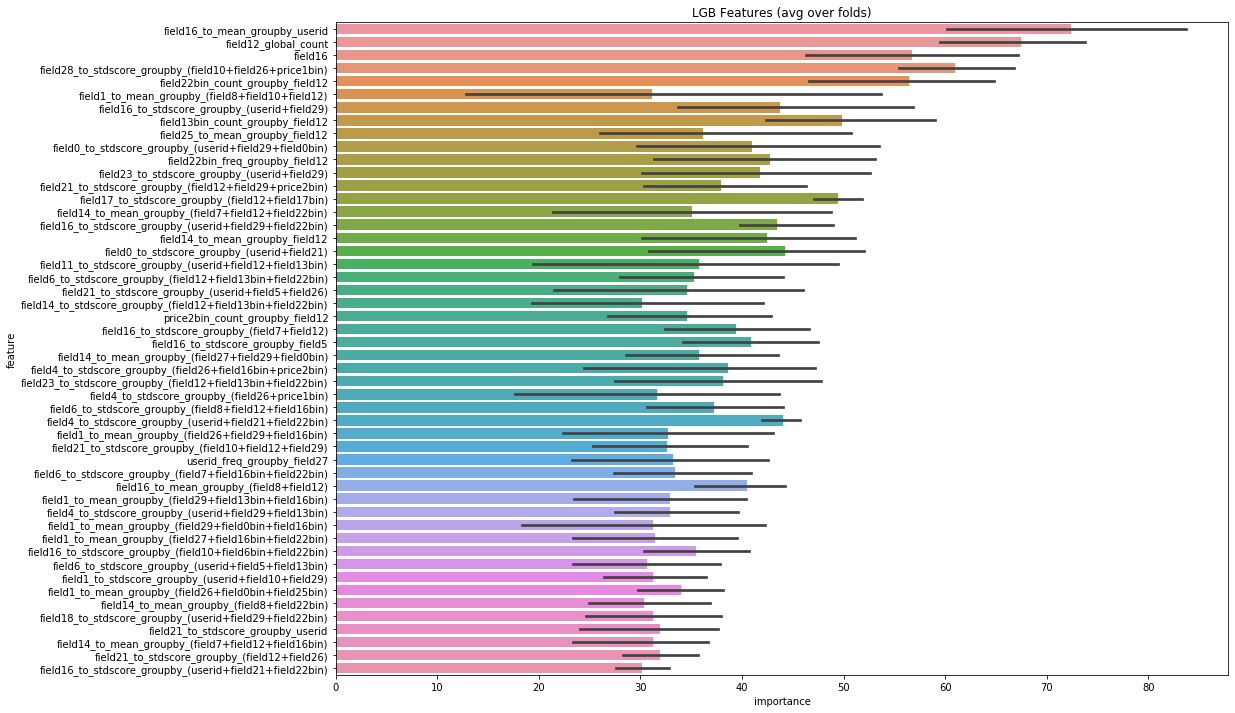

In [22]:
# 271 AGGCV features
gc.collect()
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Sun Jan 12 23:47:26 2020
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.704906	training's auc: 0.704914	valid_1's auc: 0.696565	valid_1's auc: 0.696598
[200]	training's auc: 0.717487	training's auc: 0.717481	valid_1's auc: 0.700943	valid_1's auc: 0.700966
[300]	training's auc: 0.725206	training's auc: 0.725207	valid_1's auc: 0.703518	valid_1's auc: 0.703518
[400]	training's auc: 0.733323	training's auc: 0.733323	valid_1's auc: 0.706661	valid_1's auc: 0.706659
[500]	training's auc: 0.73994	training's auc: 0.73994	valid_1's auc: 0.709729	valid_1's auc: 0.709729
[600]	training's auc: 0.746891	training's auc: 0.74689	valid_1's auc: 0.711607	valid_1's auc: 0.711606
[700]	training's auc: 0.752557	training's auc: 0.752557	valid_1's auc: 0.713436	valid_1's auc: 0.713435
[800]	training's auc: 0.758022	training's auc: 0.758022	valid_1's auc: 0.714661	valid_1's auc: 0.71466
[900]	training's auc: 0.762891	training's auc: 0.762891	valid_1's a

[600]	training's auc: 0.751729	training's auc: 0.751729	valid_1's auc: 0.695597	valid_1's auc: 0.695599
[700]	training's auc: 0.757069	training's auc: 0.757068	valid_1's auc: 0.696582	valid_1's auc: 0.696582
[800]	training's auc: 0.761891	training's auc: 0.761891	valid_1's auc: 0.697573	valid_1's auc: 0.697573
[900]	training's auc: 0.765954	training's auc: 0.765954	valid_1's auc: 0.698724	valid_1's auc: 0.698724
[1000]	training's auc: 0.769525	training's auc: 0.769525	valid_1's auc: 0.699012	valid_1's auc: 0.699011
[1100]	training's auc: 0.772922	training's auc: 0.772922	valid_1's auc: 0.699261	valid_1's auc: 0.699261
[1200]	training's auc: 0.776237	training's auc: 0.776237	valid_1's auc: 0.699376	valid_1's auc: 0.699376
[1300]	training's auc: 0.779235	training's auc: 0.779235	valid_1's auc: 0.699331	valid_1's auc: 0.699331
[1400]	training's auc: 0.782191	training's auc: 0.782191	valid_1's auc: 0.699055	valid_1's auc: 0.699055
[1500]	training's auc: 0.784908	training's auc: 0.784908	va

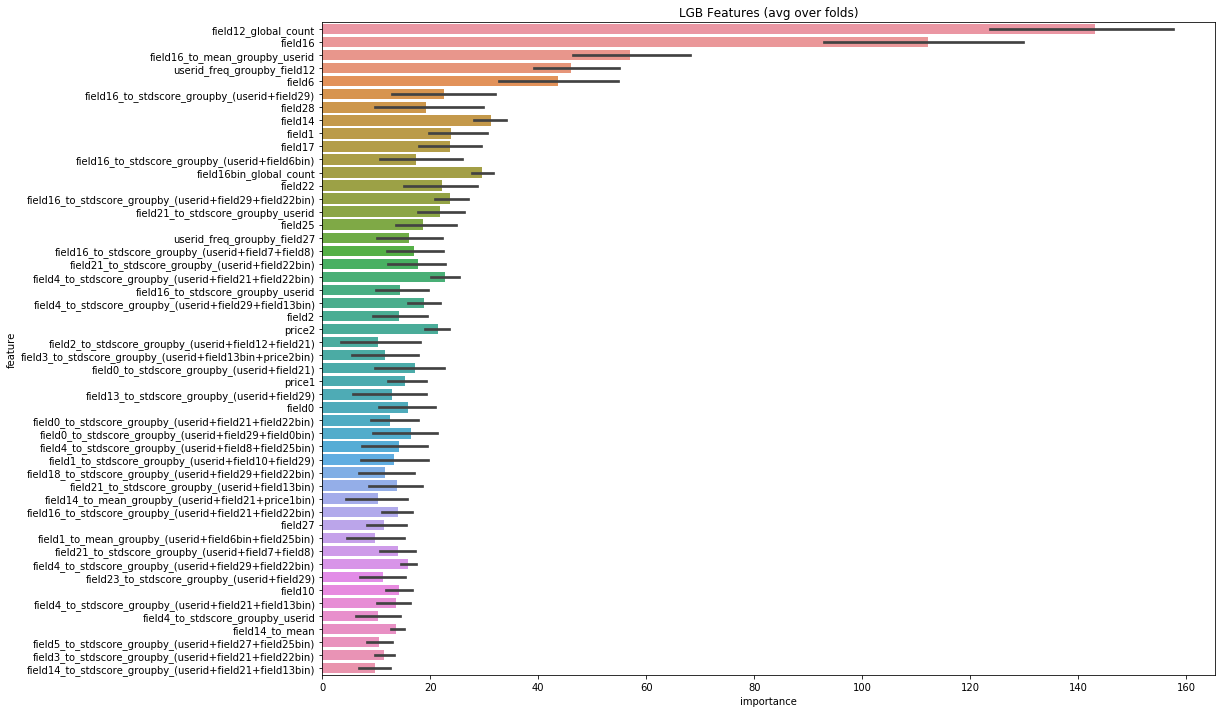

In [19]:
# Aggregates only on userid
gc.collect()
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Sun Jan 12 23:10:04 2020
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.713729	training's auc: 0.713722	valid_1's auc: 0.701599	valid_1's auc: 0.701601
[200]	training's auc: 0.728994	training's auc: 0.728993	valid_1's auc: 0.707262	valid_1's auc: 0.707256
[300]	training's auc: 0.741199	training's auc: 0.7412	valid_1's auc: 0.709724	valid_1's auc: 0.709726
[400]	training's auc: 0.752363	training's auc: 0.752363	valid_1's auc: 0.711805	valid_1's auc: 0.711805
[500]	training's auc: 0.762315	training's auc: 0.762315	valid_1's auc: 0.713422	valid_1's auc: 0.713422
[600]	training's auc: 0.770875	training's auc: 0.770875	valid_1's auc: 0.714528	valid_1's auc: 0.714528
[700]	training's auc: 0.778236	training's auc: 0.778236	valid_1's auc: 0.715387	valid_1's auc: 0.715387
[800]	training's auc: 0.785012	training's auc: 0.785012	valid_1's auc: 0.716316	valid_1's auc: 0.716316
[900]	training's auc: 0.790839	training's auc: 0.790839	valid_1's

[2000]	training's auc: 0.83564	training's auc: 0.83564	valid_1's auc: 0.705142	valid_1's auc: 0.705142
[2100]	training's auc: 0.838639	training's auc: 0.838639	valid_1's auc: 0.705255	valid_1's auc: 0.705255
[2200]	training's auc: 0.841496	training's auc: 0.841496	valid_1's auc: 0.705437	valid_1's auc: 0.705437
[2300]	training's auc: 0.844412	training's auc: 0.844412	valid_1's auc: 0.705507	valid_1's auc: 0.705507
[2400]	training's auc: 0.847217	training's auc: 0.847217	valid_1's auc: 0.705463	valid_1's auc: 0.705463
[2500]	training's auc: 0.8499	training's auc: 0.8499	valid_1's auc: 0.705463	valid_1's auc: 0.705463
[2600]	training's auc: 0.852599	training's auc: 0.852599	valid_1's auc: 0.705475	valid_1's auc: 0.705475
Early stopping, best iteration is:
[2311]	training's auc: 0.844745	training's auc: 0.844745	valid_1's auc: 0.705567	valid_1's auc: 0.705567
Fold 4 started at Sun Jan 12 23:28:36 2020
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.71

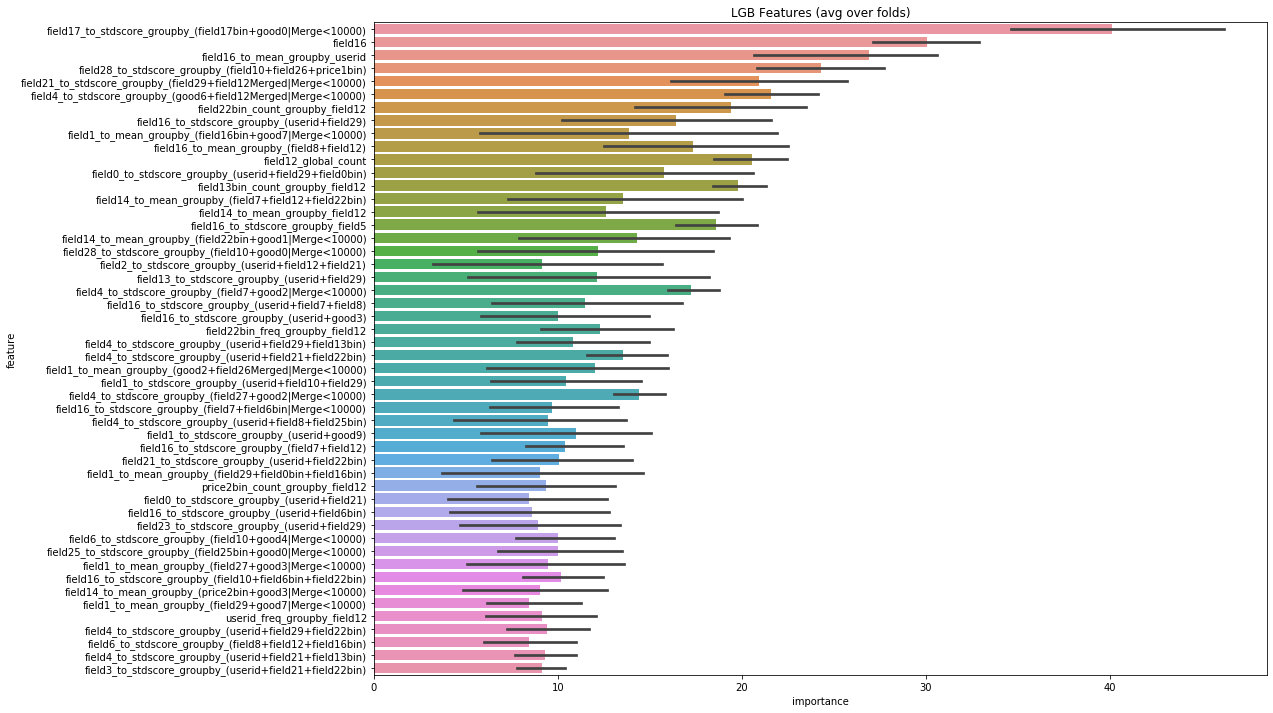

In [21]:
# All best + FE3 (1+2) best features
gc.collect()
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Sun Jan 12 10:40:49 2020
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.710924	training's auc: 0.71093	valid_1's auc: 0.701817	valid_1's auc: 0.70181
[200]	training's auc: 0.723453	training's auc: 0.723454	valid_1's auc: 0.707451	valid_1's auc: 0.707453
[300]	training's auc: 0.733206	training's auc: 0.733206	valid_1's auc: 0.711474	valid_1's auc: 0.711473
[400]	training's auc: 0.743028	training's auc: 0.743028	valid_1's auc: 0.715116	valid_1's auc: 0.715116
[500]	training's auc: 0.751382	training's auc: 0.751382	valid_1's auc: 0.717398	valid_1's auc: 0.717398
[600]	training's auc: 0.758035	training's auc: 0.758035	valid_1's auc: 0.718908	valid_1's auc: 0.718908
[700]	training's auc: 0.764126	training's auc: 0.764126	valid_1's auc: 0.720589	valid_1's auc: 0.720589
[800]	training's auc: 0.769581	training's auc: 0.769581	valid_1's auc: 0.722192	valid_1's auc: 0.722192
[900]	training's auc: 0.77479	training's auc: 0.77479	valid_1's a

[1900]	training's auc: 0.815078	training's auc: 0.815078	valid_1's auc: 0.707538	valid_1's auc: 0.707538
[2000]	training's auc: 0.81777	training's auc: 0.81777	valid_1's auc: 0.707853	valid_1's auc: 0.707853
[2100]	training's auc: 0.820409	training's auc: 0.820409	valid_1's auc: 0.708037	valid_1's auc: 0.708037
[2200]	training's auc: 0.823054	training's auc: 0.823054	valid_1's auc: 0.708253	valid_1's auc: 0.708253
[2300]	training's auc: 0.825462	training's auc: 0.825462	valid_1's auc: 0.708681	valid_1's auc: 0.708681
[2400]	training's auc: 0.828005	training's auc: 0.828005	valid_1's auc: 0.708876	valid_1's auc: 0.708876
[2500]	training's auc: 0.830383	training's auc: 0.830383	valid_1's auc: 0.709103	valid_1's auc: 0.709103
[2600]	training's auc: 0.832841	training's auc: 0.832841	valid_1's auc: 0.709393	valid_1's auc: 0.709393
[2700]	training's auc: 0.835087	training's auc: 0.835087	valid_1's auc: 0.709814	valid_1's auc: 0.709814
[2800]	training's auc: 0.837117	training's auc: 0.837117	

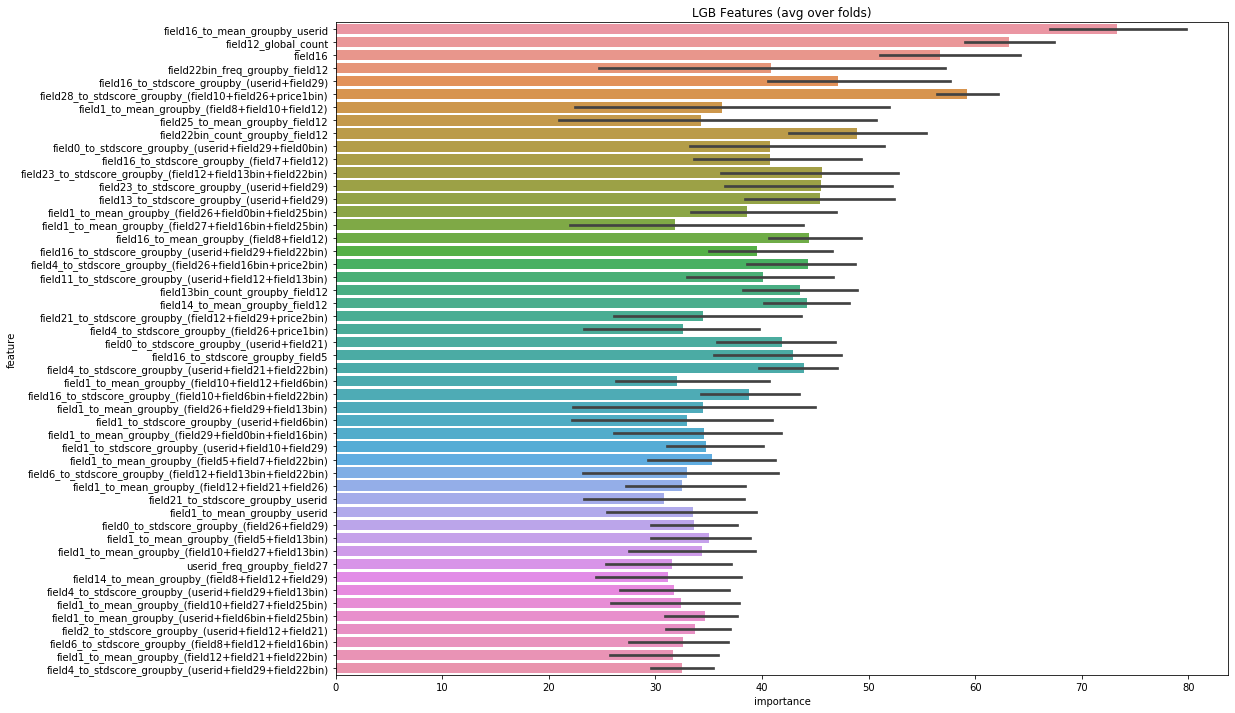

In [15]:
# 297 best features
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Sun Jan 12 00:12:17 2020
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.711256	training's auc: 0.711243	valid_1's auc: 0.696089	valid_1's auc: 0.69608
[200]	training's auc: 0.727092	training's auc: 0.727092	valid_1's auc: 0.703986	valid_1's auc: 0.703985
[300]	training's auc: 0.73929	training's auc: 0.73929	valid_1's auc: 0.708405	valid_1's auc: 0.708404
[400]	training's auc: 0.75066	training's auc: 0.75066	valid_1's auc: 0.711769	valid_1's auc: 0.711769
[500]	training's auc: 0.759911	training's auc: 0.75991	valid_1's auc: 0.713326	valid_1's auc: 0.713326
[600]	training's auc: 0.767806	training's auc: 0.767806	valid_1's auc: 0.714303	valid_1's auc: 0.714303
[700]	training's auc: 0.774854	training's auc: 0.774854	valid_1's auc: 0.715953	valid_1's auc: 0.715953
[800]	training's auc: 0.780808	training's auc: 0.780808	valid_1's auc: 0.717231	valid_1's auc: 0.717231
[900]	training's auc: 0.786492	training's auc: 0.786492	valid_1's auc

[300]	training's auc: 0.743023	training's auc: 0.743024	valid_1's auc: 0.693029	valid_1's auc: 0.693029
[400]	training's auc: 0.75255	training's auc: 0.752549	valid_1's auc: 0.696946	valid_1's auc: 0.696946
[500]	training's auc: 0.760485	training's auc: 0.760485	valid_1's auc: 0.698263	valid_1's auc: 0.698263
[600]	training's auc: 0.768253	training's auc: 0.768252	valid_1's auc: 0.698839	valid_1's auc: 0.698839
[700]	training's auc: 0.776349	training's auc: 0.776349	valid_1's auc: 0.698593	valid_1's auc: 0.698593
[800]	training's auc: 0.782464	training's auc: 0.782464	valid_1's auc: 0.69952	valid_1's auc: 0.69952
[900]	training's auc: 0.787967	training's auc: 0.787967	valid_1's auc: 0.700048	valid_1's auc: 0.700048
[1000]	training's auc: 0.792973	training's auc: 0.792973	valid_1's auc: 0.700493	valid_1's auc: 0.700493
[1100]	training's auc: 0.797532	training's auc: 0.797532	valid_1's auc: 0.700762	valid_1's auc: 0.700762
[1200]	training's auc: 0.802002	training's auc: 0.802002	valid_1'

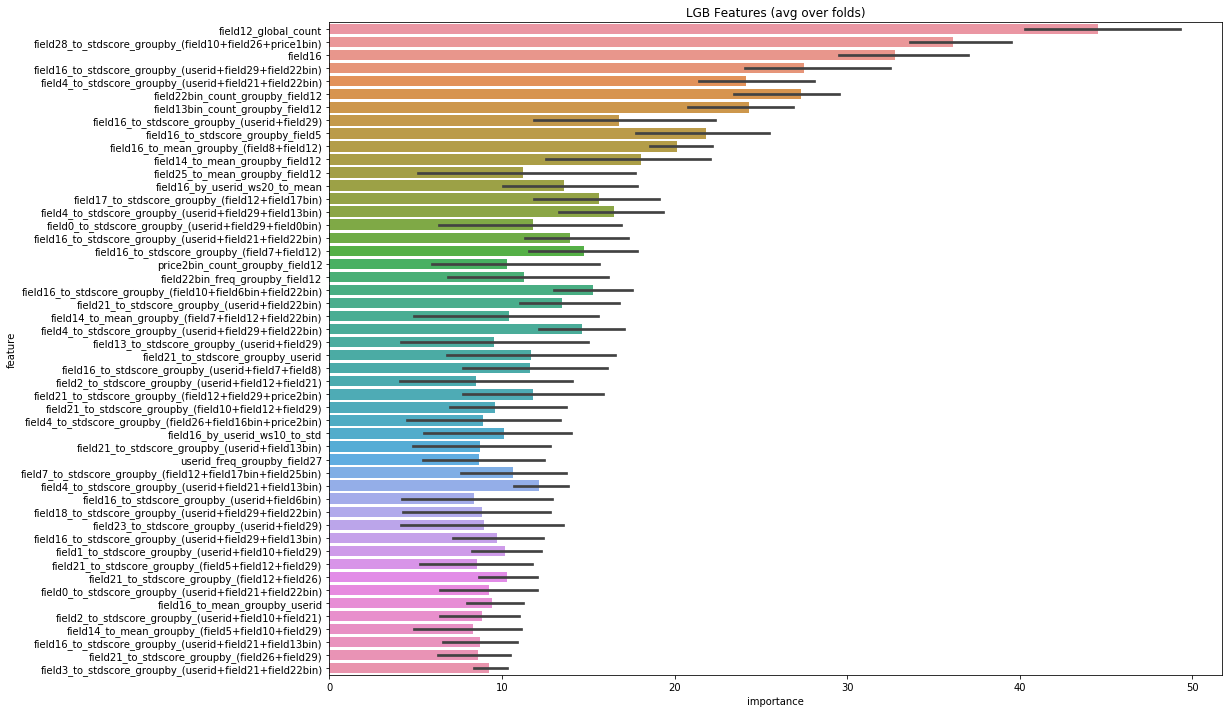

In [13]:
# 3155 + temporal no RFE
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Sat Jan 11 23:35:30 2020
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.76627	training's auc: 0.76627	valid_1's auc: 0.705683	valid_1's auc: 0.705684
[200]	training's auc: 0.788871	training's auc: 0.788871	valid_1's auc: 0.711207	valid_1's auc: 0.711207
[300]	training's auc: 0.807857	training's auc: 0.807857	valid_1's auc: 0.715027	valid_1's auc: 0.715026
[400]	training's auc: 0.824005	training's auc: 0.824005	valid_1's auc: 0.716713	valid_1's auc: 0.716713
[500]	training's auc: 0.837109	training's auc: 0.837109	valid_1's auc: 0.719042	valid_1's auc: 0.719042
[600]	training's auc: 0.847227	training's auc: 0.847227	valid_1's auc: 0.721007	valid_1's auc: 0.721007
[700]	training's auc: 0.855515	training's auc: 0.855515	valid_1's auc: 0.722808	valid_1's auc: 0.722808
[800]	training's auc: 0.862781	training's auc: 0.862781	valid_1's auc: 0.724254	valid_1's auc: 0.724254
[900]	training's auc: 0.869663	training's auc: 0.869663	valid_1's

[200]	training's auc: 0.78632	training's auc: 0.78632	valid_1's auc: 0.71089	valid_1's auc: 0.71089
[300]	training's auc: 0.805644	training's auc: 0.805644	valid_1's auc: 0.712651	valid_1's auc: 0.712652
[400]	training's auc: 0.821105	training's auc: 0.821105	valid_1's auc: 0.713108	valid_1's auc: 0.713108
[500]	training's auc: 0.834725	training's auc: 0.834725	valid_1's auc: 0.713747	valid_1's auc: 0.713747
[600]	training's auc: 0.845028	training's auc: 0.845028	valid_1's auc: 0.713804	valid_1's auc: 0.713804
[700]	training's auc: 0.853224	training's auc: 0.853224	valid_1's auc: 0.714254	valid_1's auc: 0.714254
[800]	training's auc: 0.861446	training's auc: 0.861446	valid_1's auc: 0.714016	valid_1's auc: 0.714016
[900]	training's auc: 0.868425	training's auc: 0.868425	valid_1's auc: 0.713802	valid_1's auc: 0.713802
Early stopping, best iteration is:
[663]	training's auc: 0.85036	training's auc: 0.85036	valid_1's auc: 0.714397	valid_1's auc: 0.714397
CV mean score: 0.7112, std: 0.0096.

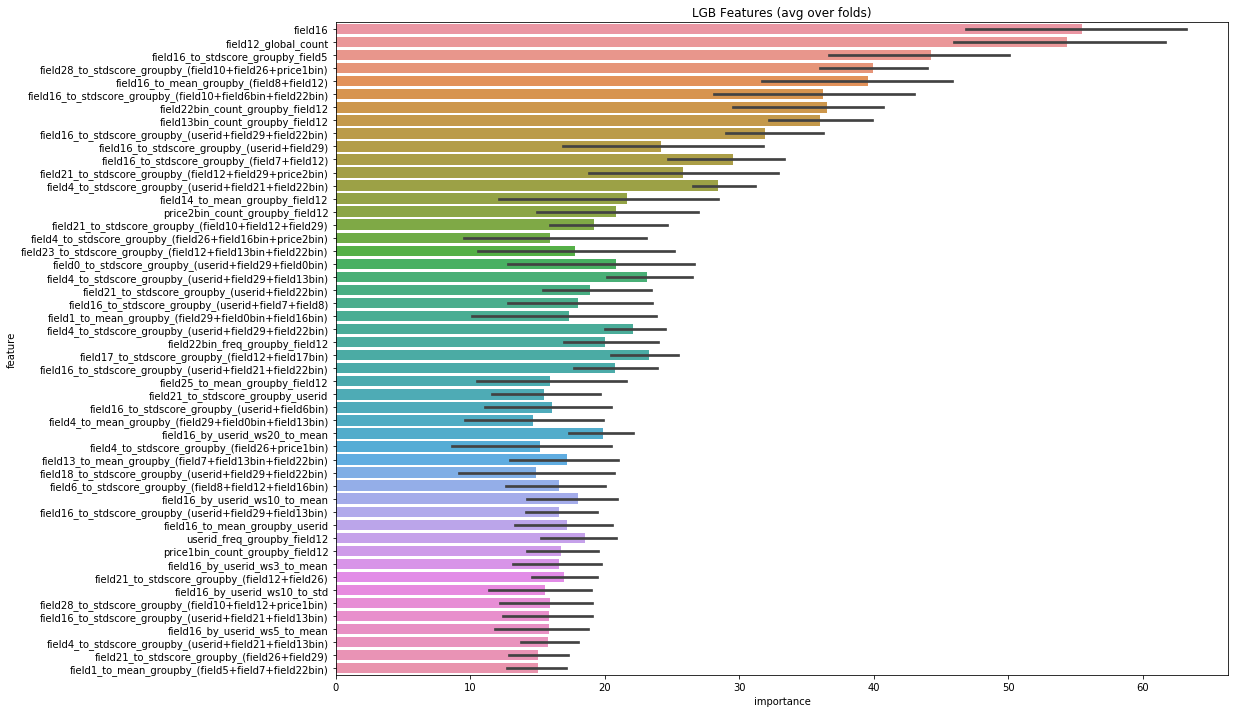

In [24]:
# Commented unknown params
result_dict = train_model_classification_vb( X=X, 
                                             X+
                                            _test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Sat Jan 11 22:55:56 2020
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.710757	training's auc: 0.710755	valid_1's auc: 0.698059	valid_1's auc: 0.69806
[200]	training's auc: 0.725499	training's auc: 0.725499	valid_1's auc: 0.705401	valid_1's auc: 0.705405
[300]	training's auc: 0.736618	training's auc: 0.736618	valid_1's auc: 0.70975	valid_1's auc: 0.70975
[400]	training's auc: 0.747502	training's auc: 0.747502	valid_1's auc: 0.712185	valid_1's auc: 0.712185
[500]	training's auc: 0.756468	training's auc: 0.756468	valid_1's auc: 0.714596	valid_1's auc: 0.714596
[600]	training's auc: 0.763695	training's auc: 0.763695	valid_1's auc: 0.716174	valid_1's auc: 0.716174
[700]	training's auc: 0.770373	training's auc: 0.770373	valid_1's auc: 0.718074	valid_1's auc: 0.718074
[800]	training's auc: 0.776259	training's auc: 0.776259	valid_1's auc: 0.7193	valid_1's auc: 0.7193
[900]	training's auc: 0.782272	training's auc: 0.782272	valid_1's auc:

[2400]	training's auc: 0.840358	training's auc: 0.840358	valid_1's auc: 0.704017	valid_1's auc: 0.704017
Early stopping, best iteration is:
[2167]	training's auc: 0.833528	training's auc: 0.833528	valid_1's auc: 0.704313	valid_1's auc: 0.704313
Fold 4 started at Sat Jan 11 23:12:46 2020
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.715171	training's auc: 0.715173	valid_1's auc: 0.684081	valid_1's auc: 0.684095
[200]	training's auc: 0.728102	training's auc: 0.728103	valid_1's auc: 0.689119	valid_1's auc: 0.68912
[300]	training's auc: 0.739671	training's auc: 0.739672	valid_1's auc: 0.694939	valid_1's auc: 0.694939
[400]	training's auc: 0.749692	training's auc: 0.749692	valid_1's auc: 0.698329	valid_1's auc: 0.698329
[500]	training's auc: 0.758051	training's auc: 0.758051	valid_1's auc: 0.700394	valid_1's auc: 0.700394
[600]	training's auc: 0.765669	training's auc: 0.765669	valid_1's auc: 0.700973	valid_1's auc: 0.700973
[700]	training's auc: 0.772

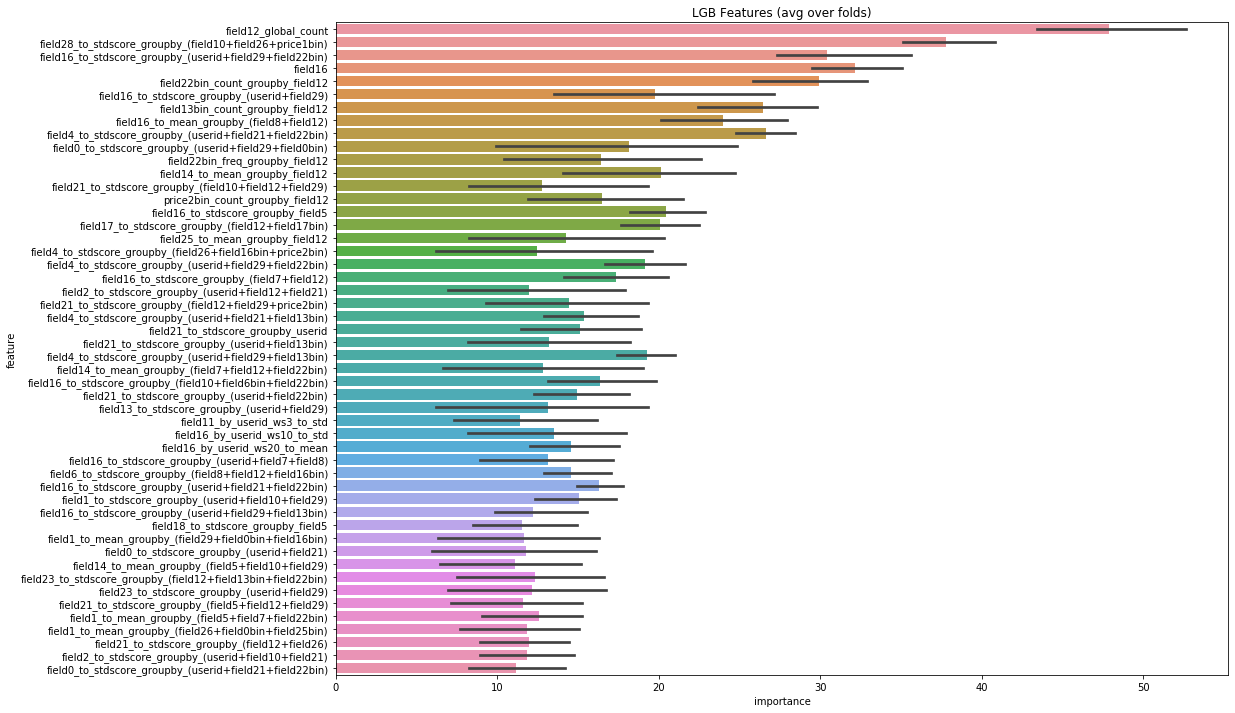

In [19]:
# Appended features added
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Sat Jan 11 19:26:42 2020
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.711144	training's auc: 0.711155	valid_1's auc: 0.69869	valid_1's auc: 0.698699
[200]	training's auc: 0.725514	training's auc: 0.725513	valid_1's auc: 0.70489	valid_1's auc: 0.704888
[300]	training's auc: 0.736619	training's auc: 0.736619	valid_1's auc: 0.709211	valid_1's auc: 0.709211
[400]	training's auc: 0.74717	training's auc: 0.74717	valid_1's auc: 0.71278	valid_1's auc: 0.71278
[500]	training's auc: 0.75628	training's auc: 0.75628	valid_1's auc: 0.714742	valid_1's auc: 0.714742
[600]	training's auc: 0.764003	training's auc: 0.764003	valid_1's auc: 0.716317	valid_1's auc: 0.716317
[700]	training's auc: 0.771309	training's auc: 0.771309	valid_1's auc: 0.717894	valid_1's auc: 0.717894
[800]	training's auc: 0.77758	training's auc: 0.77758	valid_1's auc: 0.719532	valid_1's auc: 0.719532
[900]	training's auc: 0.783432	training's auc: 0.783432	valid_1's auc: 0.

[2400]	training's auc: 0.841431	training's auc: 0.841431	valid_1's auc: 0.70483	valid_1's auc: 0.70483
[2500]	training's auc: 0.844109	training's auc: 0.844109	valid_1's auc: 0.704997	valid_1's auc: 0.704997
[2600]	training's auc: 0.846696	training's auc: 0.846696	valid_1's auc: 0.705077	valid_1's auc: 0.705077
[2700]	training's auc: 0.849315	training's auc: 0.849315	valid_1's auc: 0.705066	valid_1's auc: 0.705066
[2800]	training's auc: 0.851645	training's auc: 0.851645	valid_1's auc: 0.705133	valid_1's auc: 0.705133
[2900]	training's auc: 0.854079	training's auc: 0.854079	valid_1's auc: 0.705123	valid_1's auc: 0.705123
[3000]	training's auc: 0.856309	training's auc: 0.856309	valid_1's auc: 0.705125	valid_1's auc: 0.705125
Did not meet early stopping. Best iteration is:
[3000]	training's auc: 0.856309	training's auc: 0.856309	valid_1's auc: 0.705125	valid_1's auc: 0.705125
Fold 4 started at Sat Jan 11 19:50:41 2020
Training until validation scores don't improve for 300 rounds
[100]	tra

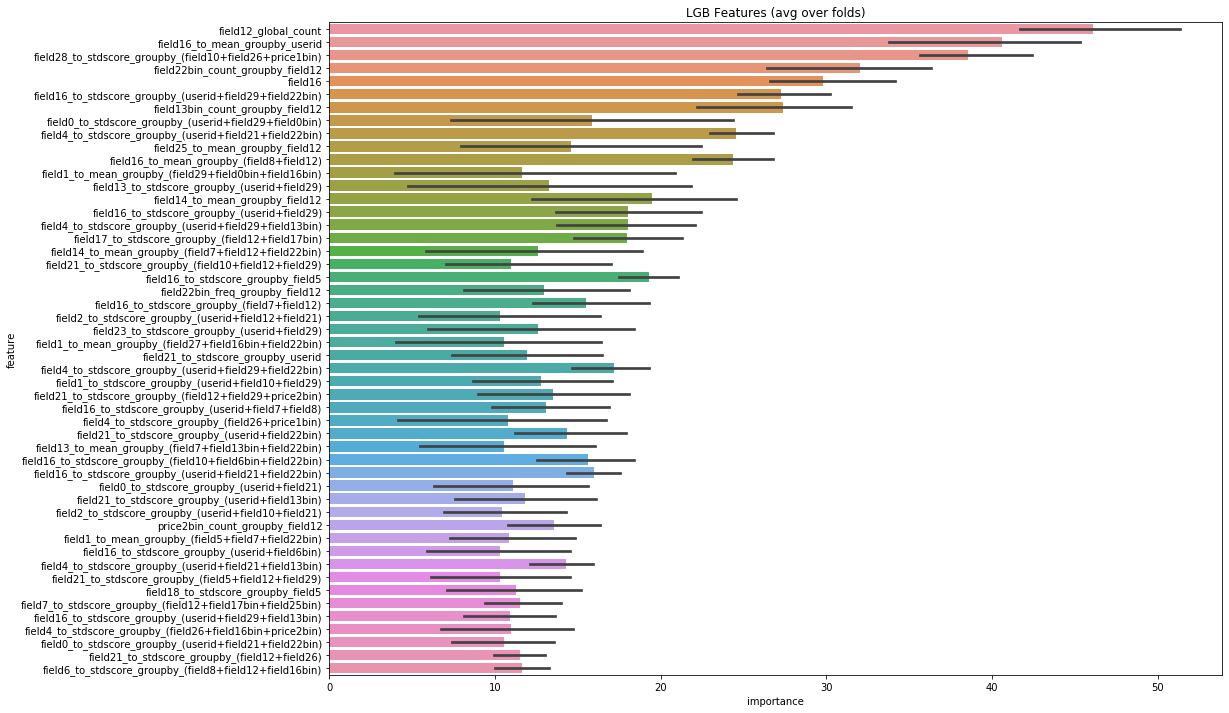

In [35]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Sat Jan 11 18:43:56 2020
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.711253	training's auc: 0.711256	valid_1's auc: 0.697888	valid_1's auc: 0.697882
[200]	training's auc: 0.725421	training's auc: 0.725422	valid_1's auc: 0.704513	valid_1's auc: 0.704515
[300]	training's auc: 0.736686	training's auc: 0.736687	valid_1's auc: 0.709086	valid_1's auc: 0.709086
[400]	training's auc: 0.747445	training's auc: 0.747445	valid_1's auc: 0.712716	valid_1's auc: 0.712716
[500]	training's auc: 0.756441	training's auc: 0.756441	valid_1's auc: 0.714681	valid_1's auc: 0.714681
[600]	training's auc: 0.764207	training's auc: 0.764207	valid_1's auc: 0.716517	valid_1's auc: 0.716517
[700]	training's auc: 0.771052	training's auc: 0.771052	valid_1's auc: 0.718089	valid_1's auc: 0.718089
[800]	training's auc: 0.777126	training's auc: 0.777126	valid_1's auc: 0.719587	valid_1's auc: 0.719587
[900]	training's auc: 0.782999	training's auc: 0.782999	valid_1

[2200]	training's auc: 0.835417	training's auc: 0.835417	valid_1's auc: 0.704221	valid_1's auc: 0.704221
[2300]	training's auc: 0.838464	training's auc: 0.838464	valid_1's auc: 0.704357	valid_1's auc: 0.704357
[2400]	training's auc: 0.841459	training's auc: 0.841459	valid_1's auc: 0.704357	valid_1's auc: 0.704357
[2500]	training's auc: 0.844128	training's auc: 0.844128	valid_1's auc: 0.704233	valid_1's auc: 0.704233
[2600]	training's auc: 0.846942	training's auc: 0.846942	valid_1's auc: 0.704324	valid_1's auc: 0.704324
[2700]	training's auc: 0.849262	training's auc: 0.849262	valid_1's auc: 0.704451	valid_1's auc: 0.704451
[2800]	training's auc: 0.851629	training's auc: 0.851629	valid_1's auc: 0.704446	valid_1's auc: 0.704446
[2900]	training's auc: 0.854167	training's auc: 0.854167	valid_1's auc: 0.704319	valid_1's auc: 0.704319
Early stopping, best iteration is:
[2657]	training's auc: 0.848222	training's auc: 0.848222	valid_1's auc: 0.704524	valid_1's auc: 0.704524
Fold 4 started at Sa

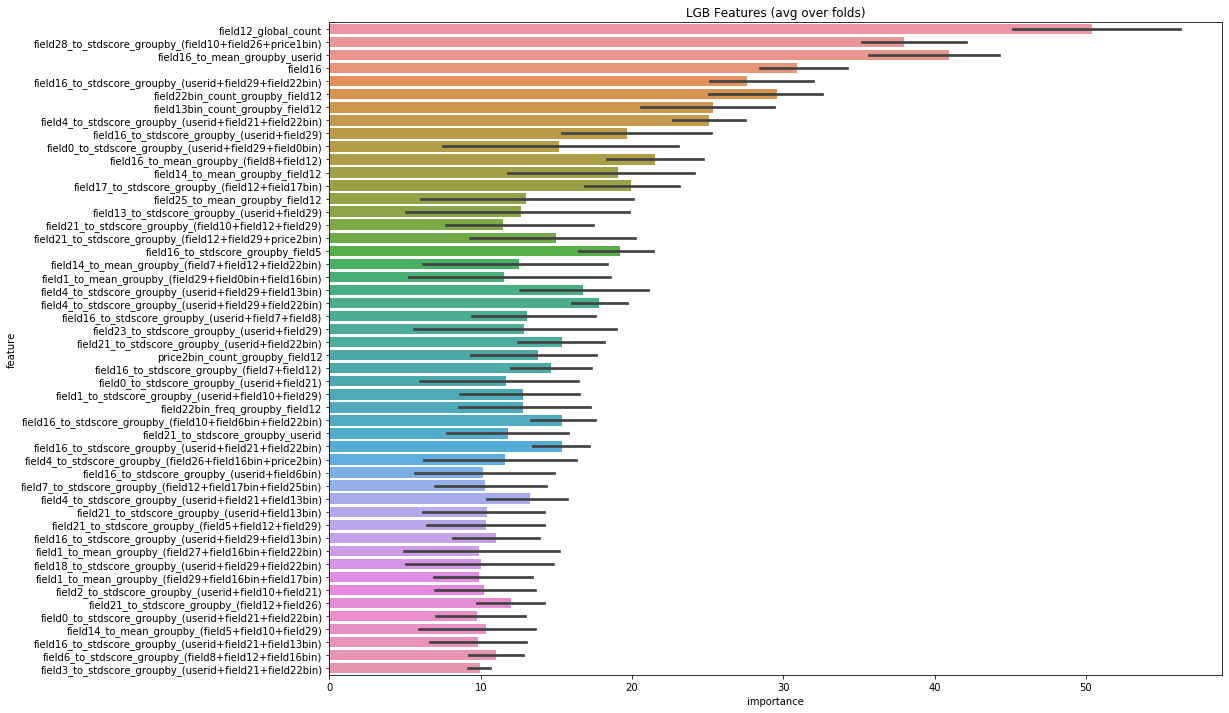

In [24]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Fri Jan 10 21:28:30 2020
Training until validation scores don't improve for 300 rounds.
[100]	training's auc: 0.714702	training's auc: 0.714708	valid_1's auc: 0.698492	valid_1's auc: 0.698495
[200]	training's auc: 0.726178	training's auc: 0.726179	valid_1's auc: 0.702705	valid_1's auc: 0.702705
[300]	training's auc: 0.736293	training's auc: 0.736294	valid_1's auc: 0.707541	valid_1's auc: 0.707542
[400]	training's auc: 0.746497	training's auc: 0.746497	valid_1's auc: 0.711107	valid_1's auc: 0.711107
[500]	training's auc: 0.756558	training's auc: 0.756558	valid_1's auc: 0.713091	valid_1's auc: 0.713091
[600]	training's auc: 0.765626	training's auc: 0.765626	valid_1's auc: 0.714268	valid_1's auc: 0.714268
[700]	training's auc: 0.772744	training's auc: 0.772744	valid_1's auc: 0.715711	valid_1's auc: 0.715711
[800]	training's auc: 0.778912	training's auc: 0.778912	valid_1's auc: 0.71699	valid_1's auc: 0.71699
[900]	training's auc: 0.784695	training's auc: 0.784695	valid_1'

[900]	training's auc: 0.784574	training's auc: 0.784574	valid_1's auc: 0.701891	valid_1's auc: 0.701892
[1000]	training's auc: 0.789343	training's auc: 0.789343	valid_1's auc: 0.702025	valid_1's auc: 0.702025
[1100]	training's auc: 0.794036	training's auc: 0.794036	valid_1's auc: 0.702258	valid_1's auc: 0.702258
[1200]	training's auc: 0.798599	training's auc: 0.798599	valid_1's auc: 0.70236	valid_1's auc: 0.70236
[1300]	training's auc: 0.802829	training's auc: 0.802829	valid_1's auc: 0.702713	valid_1's auc: 0.702713
[1400]	training's auc: 0.806776	training's auc: 0.806776	valid_1's auc: 0.702752	valid_1's auc: 0.702752
[1500]	training's auc: 0.810699	training's auc: 0.810699	valid_1's auc: 0.7029	valid_1's auc: 0.7029
[1600]	training's auc: 0.814374	training's auc: 0.814374	valid_1's auc: 0.702805	valid_1's auc: 0.702805
[1700]	training's auc: 0.817763	training's auc: 0.817763	valid_1's auc: 0.702661	valid_1's auc: 0.702661
Early stopping, best iteration is:
[1453]	training's auc: 0.80

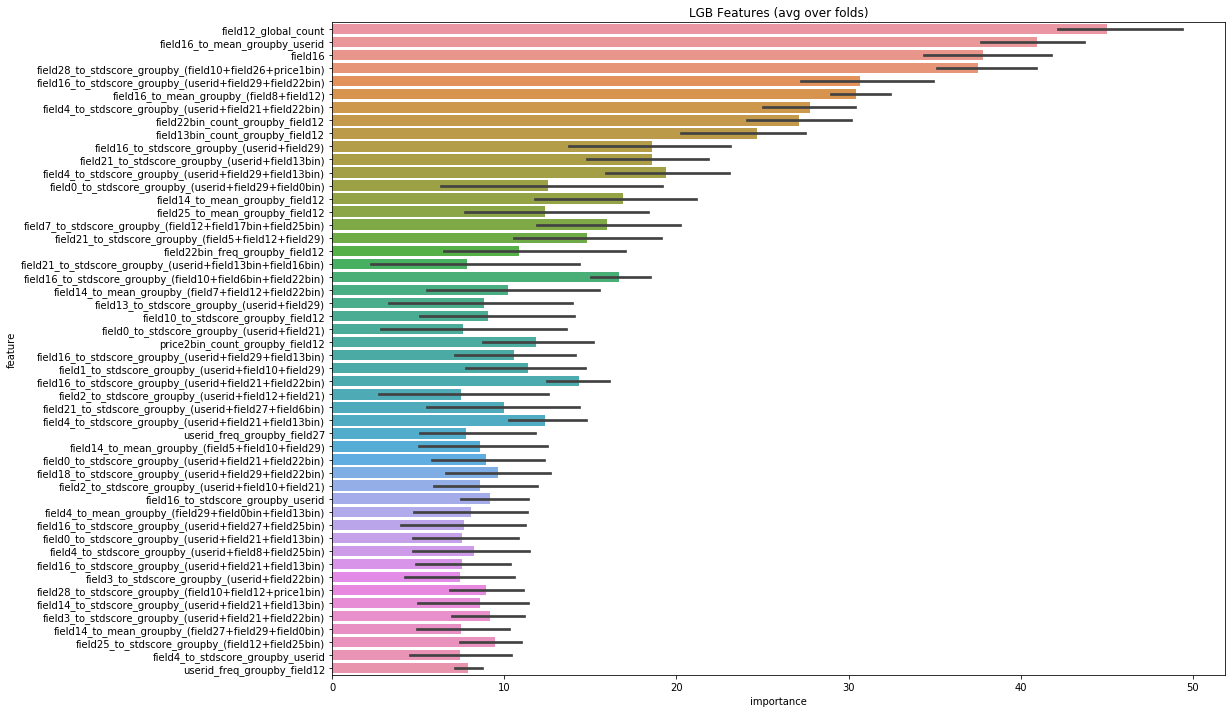

In [10]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Fri Jan 10 18:19:34 2020
Training until validation scores don't improve for 1000 rounds.
[100]	training's auc: 0.68752	training's auc: 0.687507	valid_1's auc: 0.696457	valid_1's auc: 0.696342
[200]	training's auc: 0.699506	training's auc: 0.699512	valid_1's auc: 0.705223	valid_1's auc: 0.705232
[300]	training's auc: 0.709555	training's auc: 0.709554	valid_1's auc: 0.710711	valid_1's auc: 0.710713
[400]	training's auc: 0.71734	training's auc: 0.717339	valid_1's auc: 0.714492	valid_1's auc: 0.714491
[500]	training's auc: 0.723727	training's auc: 0.723727	valid_1's auc: 0.716974	valid_1's auc: 0.716974
[600]	training's auc: 0.729065	training's auc: 0.729065	valid_1's auc: 0.719149	valid_1's auc: 0.719148
[700]	training's auc: 0.733856	training's auc: 0.733856	valid_1's auc: 0.72084	valid_1's auc: 0.72084
[800]	training's auc: 0.738313	training's auc: 0.738313	valid_1's auc: 0.722466	valid_1's auc: 0.722466
[900]	training's auc: 0.74239	training's auc: 0.74239	valid_1's a

[3200]	training's auc: 0.805985	training's auc: 0.805985	valid_1's auc: 0.687834	valid_1's auc: 0.687833
[3300]	training's auc: 0.807703	training's auc: 0.807703	valid_1's auc: 0.687791	valid_1's auc: 0.687791
[3400]	training's auc: 0.809435	training's auc: 0.809435	valid_1's auc: 0.687874	valid_1's auc: 0.687874
[3500]	training's auc: 0.811133	training's auc: 0.811133	valid_1's auc: 0.687804	valid_1's auc: 0.687804
[3600]	training's auc: 0.812896	training's auc: 0.812896	valid_1's auc: 0.687665	valid_1's auc: 0.687665
[3700]	training's auc: 0.814538	training's auc: 0.814538	valid_1's auc: 0.687694	valid_1's auc: 0.687694
[3800]	training's auc: 0.816168	training's auc: 0.816168	valid_1's auc: 0.687721	valid_1's auc: 0.687721
[3900]	training's auc: 0.817836	training's auc: 0.817836	valid_1's auc: 0.687589	valid_1's auc: 0.687589
Early stopping, best iteration is:
[2920]	training's auc: 0.800673	training's auc: 0.800673	valid_1's auc: 0.688085	valid_1's auc: 0.688085
Fold 3 started at Fr

[2400]	training's auc: 0.788327	training's auc: 0.788327	valid_1's auc: 0.698166	valid_1's auc: 0.698166
[2500]	training's auc: 0.79044	training's auc: 0.79044	valid_1's auc: 0.698007	valid_1's auc: 0.698007
[2600]	training's auc: 0.792459	training's auc: 0.792459	valid_1's auc: 0.697939	valid_1's auc: 0.697939
[2700]	training's auc: 0.794474	training's auc: 0.794474	valid_1's auc: 0.697837	valid_1's auc: 0.697837
[2800]	training's auc: 0.796515	training's auc: 0.796515	valid_1's auc: 0.697652	valid_1's auc: 0.697652
[2900]	training's auc: 0.798366	training's auc: 0.798366	valid_1's auc: 0.697589	valid_1's auc: 0.697589
[3000]	training's auc: 0.800243	training's auc: 0.800243	valid_1's auc: 0.697426	valid_1's auc: 0.697426
[3100]	training's auc: 0.802089	training's auc: 0.802089	valid_1's auc: 0.697285	valid_1's auc: 0.697285
[3200]	training's auc: 0.803844	training's auc: 0.803844	valid_1's auc: 0.697141	valid_1's auc: 0.697141
Early stopping, best iteration is:
[2225]	training's auc:

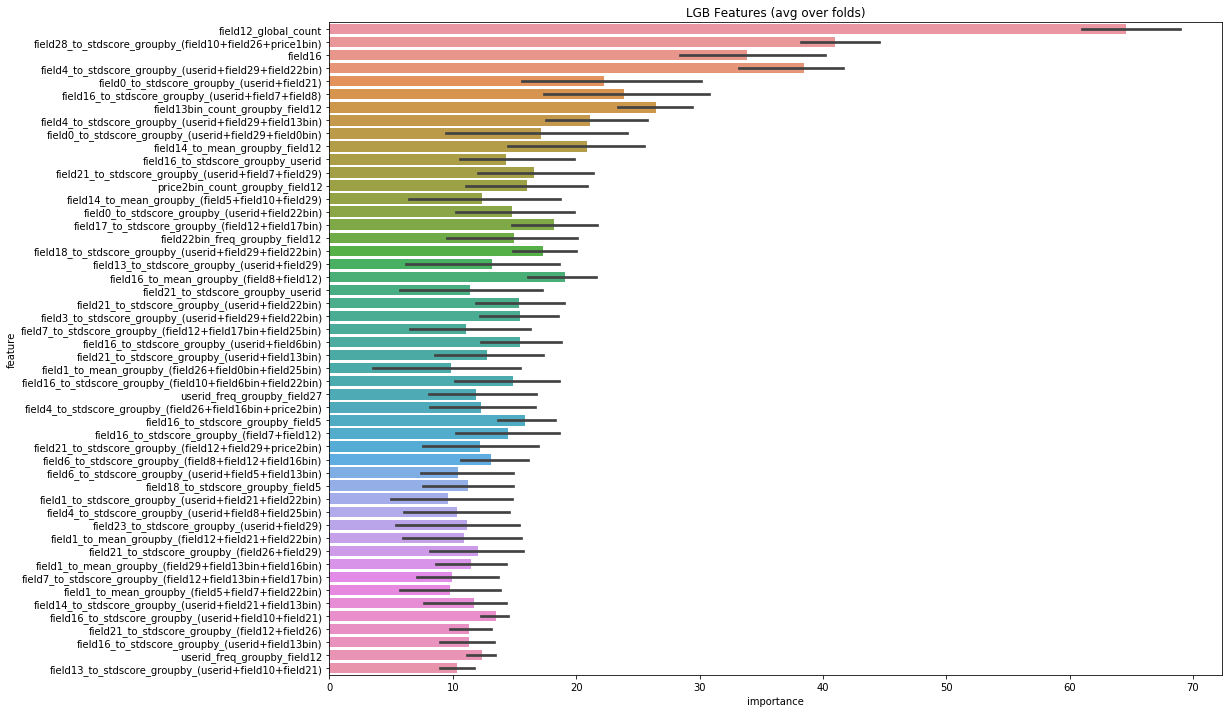

In [17]:

# deleted 800 bad features from fold1 check
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

## 1236 best features

Fold 1 started at Tue Jan  7 20:49:21 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.709081	training's auc: 0.709079	valid_1's auc: 0.693037	valid_1's auc: 0.693043
[200]	training's auc: 0.720758	training's auc: 0.720758	valid_1's auc: 0.695446	valid_1's auc: 0.695445
[300]	training's auc: 0.729458	training's auc: 0.729458	valid_1's auc: 0.697883	valid_1's auc: 0.697883
[400]	training's auc: 0.73913	training's auc: 0.73913	valid_1's auc: 0.699906	valid_1's auc: 0.699906
[500]	training's auc: 0.747183	training's auc: 0.747183	valid_1's auc: 0.701917	valid_1's auc: 0.701917
[600]	training's auc: 0.754383	training's auc: 0.754383	valid_1's auc: 0.702833	valid_1's auc: 0.702833
[700]	training's auc: 0.76048	training's auc: 0.76048	valid_1's auc: 0.703841	valid_1's auc: 0.703841
[800]	training's auc: 0.765831	training's auc: 0.765831	valid_1's auc: 0.704398	valid_1's auc: 0.704398
[900]	training's auc: 0.771488	training's auc: 0.771488	valid_1's 

[1000]	training's auc: 0.778577	training's auc: 0.778577	valid_1's auc: 0.70036	valid_1's auc: 0.70036
[1100]	training's auc: 0.783786	training's auc: 0.783786	valid_1's auc: 0.70111	valid_1's auc: 0.70111
[1200]	training's auc: 0.788861	training's auc: 0.788861	valid_1's auc: 0.701454	valid_1's auc: 0.701454
[1300]	training's auc: 0.793569	training's auc: 0.793569	valid_1's auc: 0.701776	valid_1's auc: 0.701776
[1400]	training's auc: 0.798592	training's auc: 0.798592	valid_1's auc: 0.702357	valid_1's auc: 0.702357
[1500]	training's auc: 0.803151	training's auc: 0.803151	valid_1's auc: 0.702344	valid_1's auc: 0.702344
[1600]	training's auc: 0.807224	training's auc: 0.807224	valid_1's auc: 0.702575	valid_1's auc: 0.702575
[1700]	training's auc: 0.811073	training's auc: 0.811073	valid_1's auc: 0.70265	valid_1's auc: 0.70265
[1800]	training's auc: 0.814595	training's auc: 0.814595	valid_1's auc: 0.702965	valid_1's auc: 0.702965
[1900]	training's auc: 0.818182	training's auc: 0.818182	vali

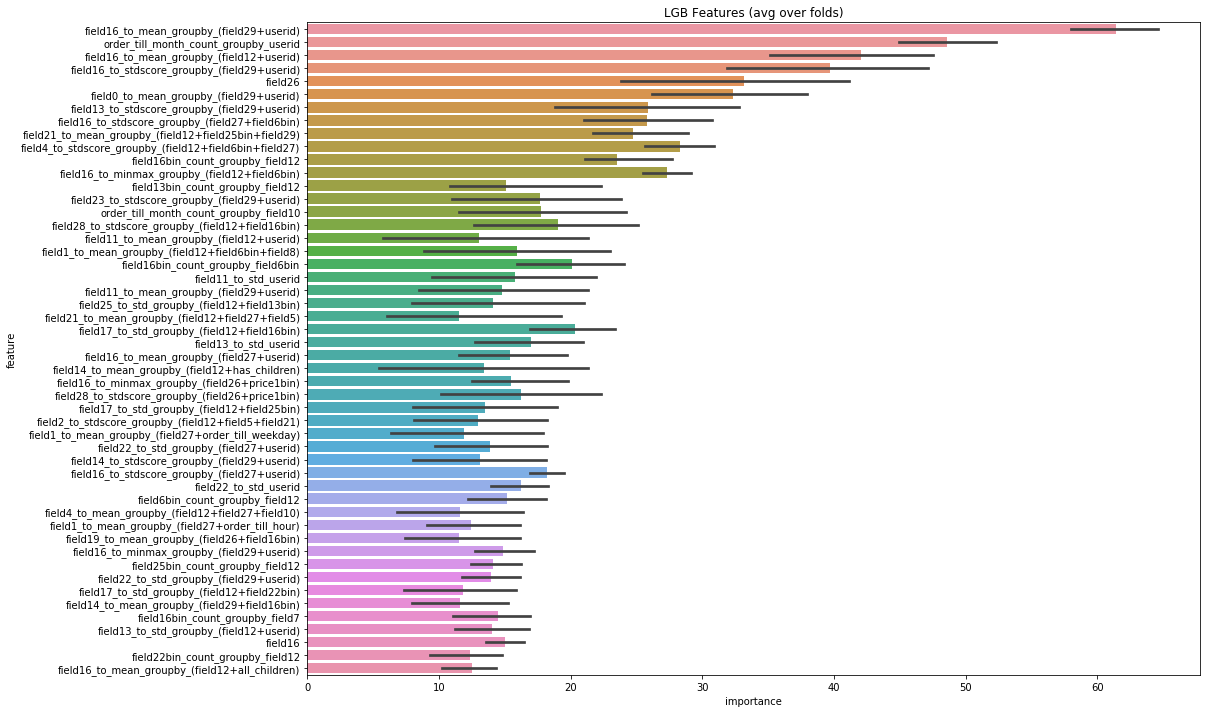

In [15]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Sun Jan  5 20:11:57 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.710042	training's auc: 0.710038	valid_1's auc: 0.678083	valid_1's auc: 0.678086
[200]	training's auc: 0.71992	training's auc: 0.71992	valid_1's auc: 0.68439	valid_1's auc: 0.684389
[300]	training's auc: 0.728749	training's auc: 0.728749	valid_1's auc: 0.688293	valid_1's auc: 0.688292
[400]	training's auc: 0.738816	training's auc: 0.738816	valid_1's auc: 0.692338	valid_1's auc: 0.692338
[500]	training's auc: 0.747321	training's auc: 0.747321	valid_1's auc: 0.693523	valid_1's auc: 0.693523
[600]	training's auc: 0.754559	training's auc: 0.754559	valid_1's auc: 0.694666	valid_1's auc: 0.694666
[700]	training's auc: 0.760856	training's auc: 0.760856	valid_1's auc: 0.695686	valid_1's auc: 0.695686
[800]	training's auc: 0.76664	training's auc: 0.76664	valid_1's auc: 0.696014	valid_1's auc: 0.696014
[900]	training's auc: 0.771861	training's auc: 0.771861	valid_1's a

[600]	training's auc: 0.753367	training's auc: 0.753367	valid_1's auc: 0.700802	valid_1's auc: 0.700802
[700]	training's auc: 0.75858	training's auc: 0.75858	valid_1's auc: 0.702144	valid_1's auc: 0.702144
[800]	training's auc: 0.763847	training's auc: 0.763847	valid_1's auc: 0.703055	valid_1's auc: 0.703055
[900]	training's auc: 0.769042	training's auc: 0.769042	valid_1's auc: 0.703797	valid_1's auc: 0.703797
[1000]	training's auc: 0.77416	training's auc: 0.77416	valid_1's auc: 0.704778	valid_1's auc: 0.704778
[1100]	training's auc: 0.778642	training's auc: 0.778642	valid_1's auc: 0.705681	valid_1's auc: 0.705681
[1200]	training's auc: 0.782984	training's auc: 0.782984	valid_1's auc: 0.705775	valid_1's auc: 0.705775
[1300]	training's auc: 0.787503	training's auc: 0.787503	valid_1's auc: 0.705934	valid_1's auc: 0.705934
[1400]	training's auc: 0.79206	training's auc: 0.79206	valid_1's auc: 0.706001	valid_1's auc: 0.706001
[1500]	training's auc: 0.796255	training's auc: 0.796255	valid_1'

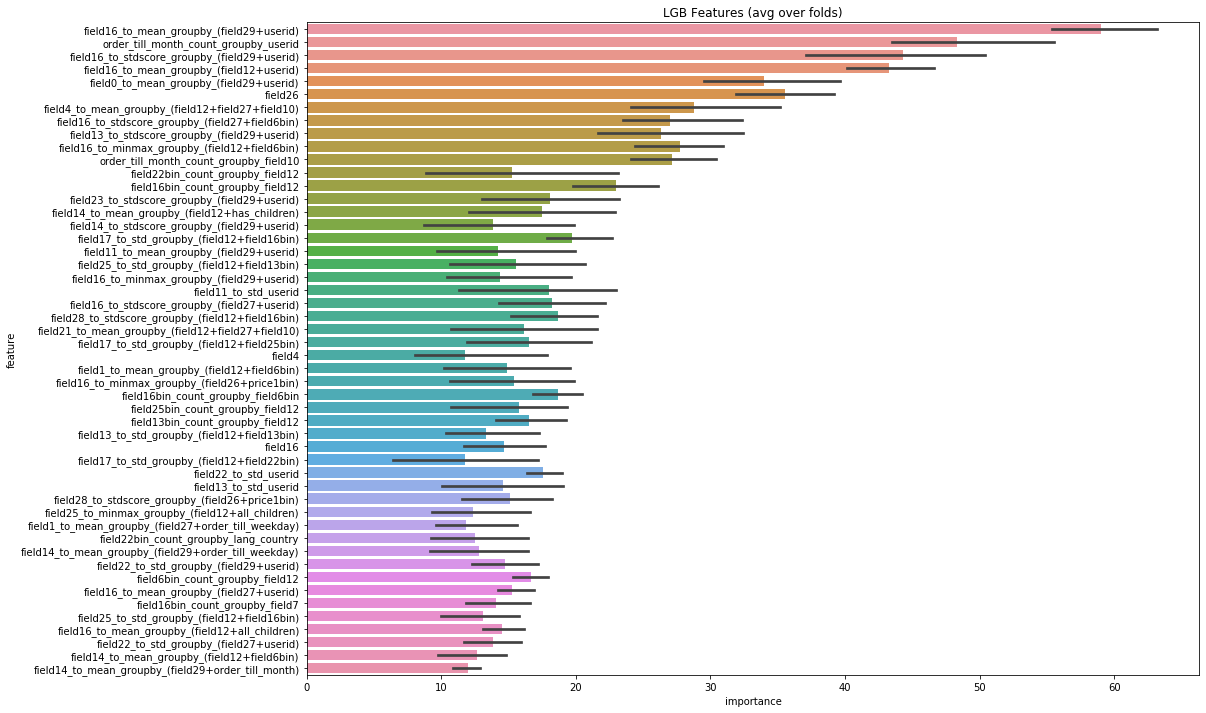

In [34]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

### PREVIOUS

Fold 1 started at Sun Jan  5 19:32:23 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.709847	training's auc: 0.709849	valid_1's auc: 0.667254	valid_1's auc: 0.667242
[200]	training's auc: 0.722829	training's auc: 0.722829	valid_1's auc: 0.673033	valid_1's auc: 0.673033
[300]	training's auc: 0.732897	training's auc: 0.732897	valid_1's auc: 0.677898	valid_1's auc: 0.677898
[400]	training's auc: 0.743508	training's auc: 0.743508	valid_1's auc: 0.680865	valid_1's auc: 0.680865
[500]	training's auc: 0.751759	training's auc: 0.751759	valid_1's auc: 0.681824	valid_1's auc: 0.681824
[600]	training's auc: 0.759455	training's auc: 0.759455	valid_1's auc: 0.682964	valid_1's auc: 0.682964
[700]	training's auc: 0.765775	training's auc: 0.765775	valid_1's auc: 0.683873	valid_1's auc: 0.683873
[800]	training's auc: 0.771203	training's auc: 0.771203	valid_1's auc: 0.684521	valid_1's auc: 0.684521
[900]	training's auc: 0.776501	training's auc: 0.776501	valid_

[700]	training's auc: 0.762697	training's auc: 0.762697	valid_1's auc: 0.693759	valid_1's auc: 0.693759
[800]	training's auc: 0.768836	training's auc: 0.768836	valid_1's auc: 0.695172	valid_1's auc: 0.695172
[900]	training's auc: 0.774507	training's auc: 0.774507	valid_1's auc: 0.695841	valid_1's auc: 0.695841
[1000]	training's auc: 0.779674	training's auc: 0.779674	valid_1's auc: 0.696618	valid_1's auc: 0.696618
[1100]	training's auc: 0.784285	training's auc: 0.784285	valid_1's auc: 0.696992	valid_1's auc: 0.696992
[1200]	training's auc: 0.788962	training's auc: 0.788962	valid_1's auc: 0.697555	valid_1's auc: 0.697555
[1300]	training's auc: 0.793333	training's auc: 0.793333	valid_1's auc: 0.698095	valid_1's auc: 0.698095
[1400]	training's auc: 0.79761	training's auc: 0.79761	valid_1's auc: 0.698323	valid_1's auc: 0.698323
[1500]	training's auc: 0.801675	training's auc: 0.801675	valid_1's auc: 0.698498	valid_1's auc: 0.698498
[1600]	training's auc: 0.805368	training's auc: 0.805368	val

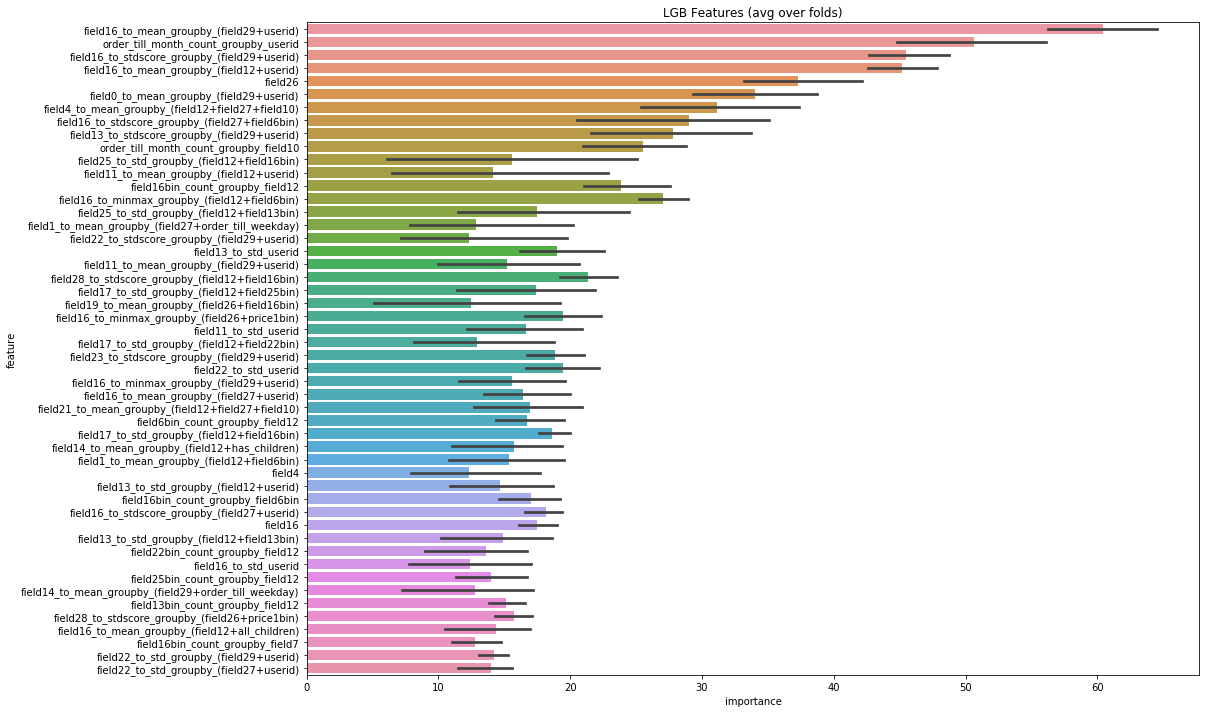

In [14]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

In [16]:
from sklearn.model_selection import GroupKFold, KFold

NFOLDS = 5
folds = GroupKFold(n_splits=NFOLDS)
params = {
          "verbosity": -1,
          'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': 4,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }
train_options = {
        "model_type":'lgb',
        "params": params,
        "eval_metric":'auc',
        'early_stopping_rounds': 100,
        'n_estimators': 1000,
        'averaging': 'rank',
        'use_groups': False,
        'fold_name': folds.__class__.__name__,
        'n_splits': NFOLDS
    }

Fold 1 started at Sun Jan  5 18:55:21 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.722735	training's auc: 0.722737	valid_1's auc: 0.67203	valid_1's auc: 0.67203
[200]	training's auc: 0.742866	training's auc: 0.742865	valid_1's auc: 0.679624	valid_1's auc: 0.679625
[300]	training's auc: 0.759112	training's auc: 0.759112	valid_1's auc: 0.682494	valid_1's auc: 0.682494
[400]	training's auc: 0.771008	training's auc: 0.771008	valid_1's auc: 0.684199	valid_1's auc: 0.684199
[500]	training's auc: 0.780192	training's auc: 0.780192	valid_1's auc: 0.684454	valid_1's auc: 0.684454
[600]	training's auc: 0.788647	training's auc: 0.788647	valid_1's auc: 0.684897	valid_1's auc: 0.684897
[700]	training's auc: 0.796798	training's auc: 0.796798	valid_1's auc: 0.684732	valid_1's auc: 0.684732
Early stopping, best iteration is:
[648]	training's auc: 0.79246	training's auc: 0.79246	valid_1's auc: 0.684971	valid_1's auc: 0.684971
Fold 2 started at Sun Jan  5 18

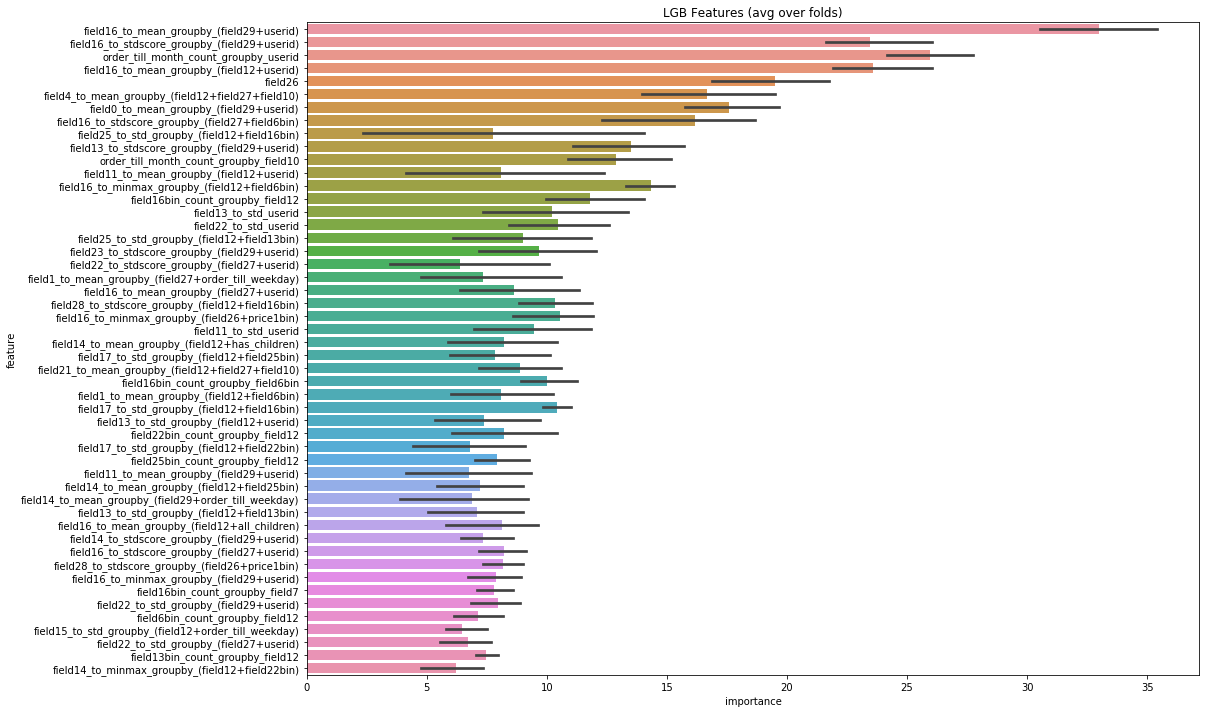

In [17]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Sun Jan  5 17:48:03 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.753482	training's auc: 0.753443	valid_1's auc: 0.662721	valid_1's auc: 0.662544
[200]	training's auc: 0.798471	training's auc: 0.798467	valid_1's auc: 0.670129	valid_1's auc: 0.670119
[300]	training's auc: 0.832729	training's auc: 0.832729	valid_1's auc: 0.677323	valid_1's auc: 0.677324
[400]	training's auc: 0.861423	training's auc: 0.861423	valid_1's auc: 0.680364	valid_1's auc: 0.680364
[500]	training's auc: 0.882461	training's auc: 0.882462	valid_1's auc: 0.682748	valid_1's auc: 0.682748
[600]	training's auc: 0.902113	training's auc: 0.902112	valid_1's auc: 0.683905	valid_1's auc: 0.683905
[700]	training's auc: 0.918472	training's auc: 0.918472	valid_1's auc: 0.686804	valid_1's auc: 0.686804
[800]	training's auc: 0.931405	training's auc: 0.931405	valid_1's auc: 0.687276	valid_1's auc: 0.687276
Early stopping, best iteration is:
[796]	training's auc: 0.930

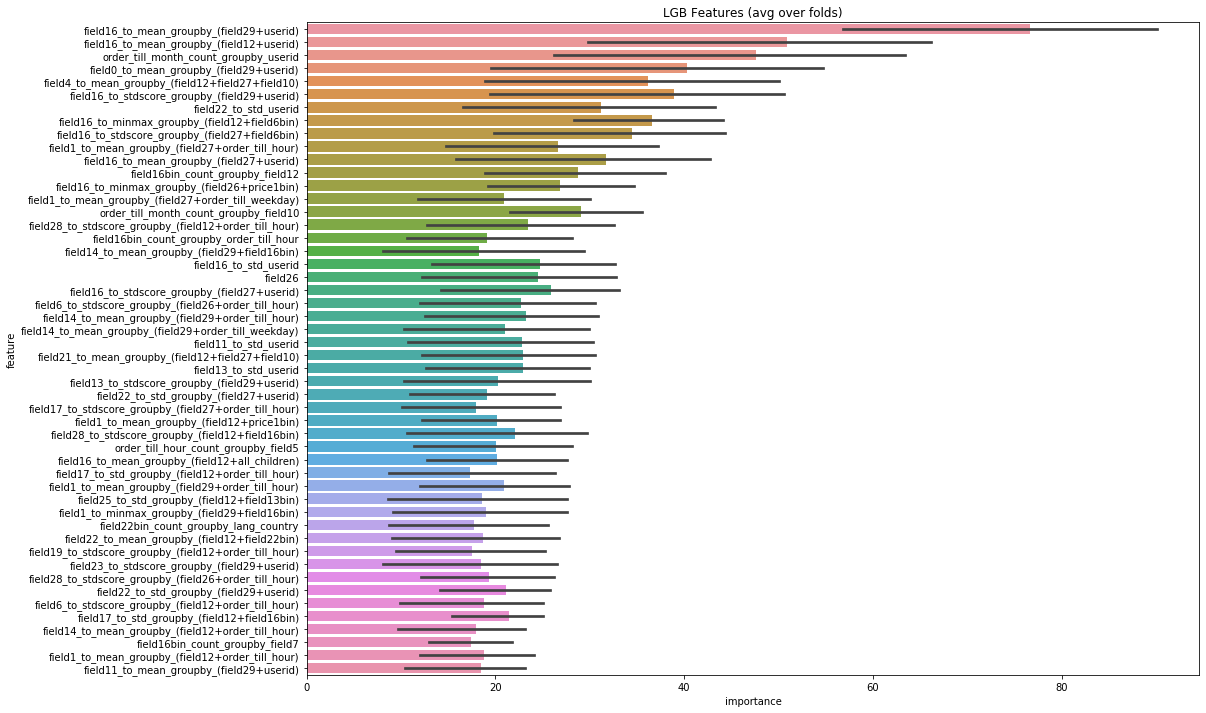

In [12]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Sat Jan  4 14:29:13 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.797201	training's auc: 0.797202	valid_1's auc: 0.670295	valid_1's auc: 0.670299
[200]	training's auc: 0.859572	training's auc: 0.859572	valid_1's auc: 0.682299	valid_1's auc: 0.682299
[300]	training's auc: 0.901514	training's auc: 0.901514	valid_1's auc: 0.68417	valid_1's auc: 0.68417
[400]	training's auc: 0.929149	training's auc: 0.929149	valid_1's auc: 0.684377	valid_1's auc: 0.684377
Early stopping, best iteration is:
[367]	training's auc: 0.92024	training's auc: 0.92024	valid_1's auc: 0.684642	valid_1's auc: 0.684642
Fold 2 started at Sat Jan  4 14:34:05 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.792754	training's auc: 0.792753	valid_1's auc: 0.719666	valid_1's auc: 0.71967
[200]	training's auc: 0.854274	training's auc: 0.854273	valid_1's auc: 0.726832	valid_1's auc: 0.726833
[300]	training's auc: 0.900796

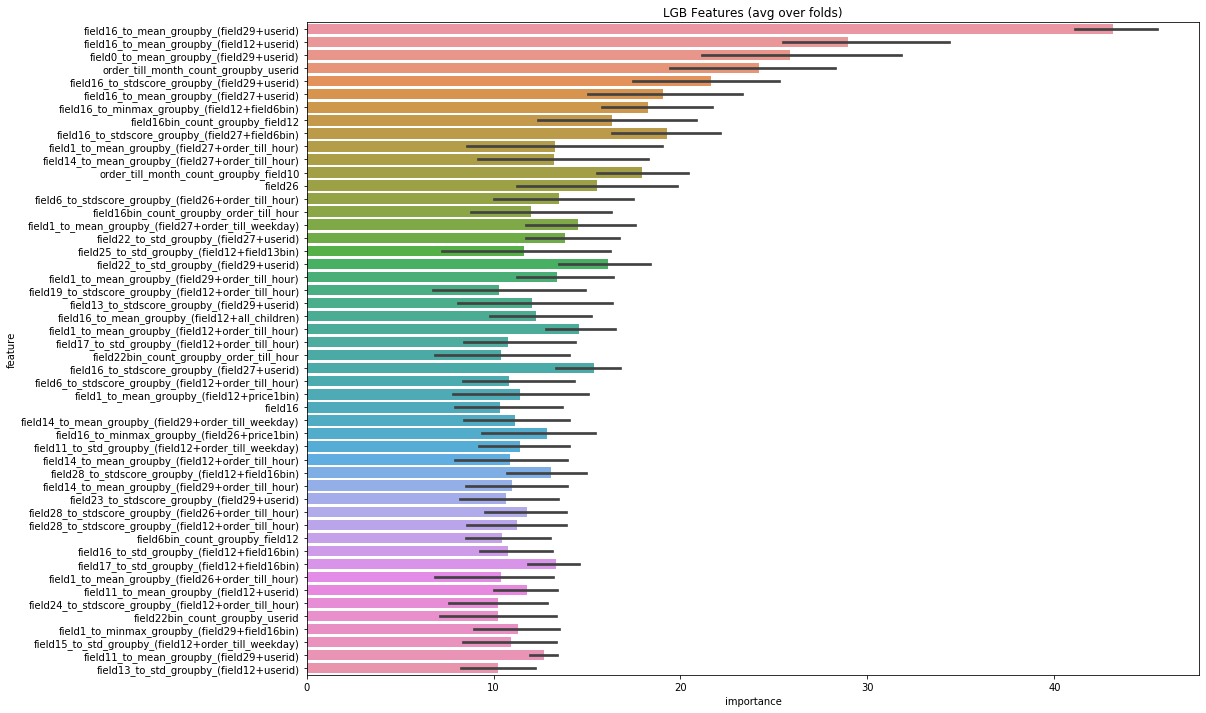

In [15]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Sat Jan  4 00:16:16 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.746556	training's auc: 0.746542	valid_1's auc: 0.662057	valid_1's auc: 0.661889
[200]	training's auc: 0.782639	training's auc: 0.782646	valid_1's auc: 0.670029	valid_1's auc: 0.67003
[300]	training's auc: 0.815747	training's auc: 0.815747	valid_1's auc: 0.675619	valid_1's auc: 0.675618
[400]	training's auc: 0.844988	training's auc: 0.844989	valid_1's auc: 0.676379	valid_1's auc: 0.676379
[500]	training's auc: 0.866748	training's auc: 0.866748	valid_1's auc: 0.678385	valid_1's auc: 0.678385
[600]	training's auc: 0.885753	training's auc: 0.885753	valid_1's auc: 0.678988	valid_1's auc: 0.678988
[700]	training's auc: 0.903013	training's auc: 0.903013	valid_1's auc: 0.679358	valid_1's auc: 0.679358
[800]	training's auc: 0.916768	training's auc: 0.916768	valid_1's auc: 0.679804	valid_1's auc: 0.679804
[900]	training's auc: 0.928922	training's auc: 0.928922	valid_1

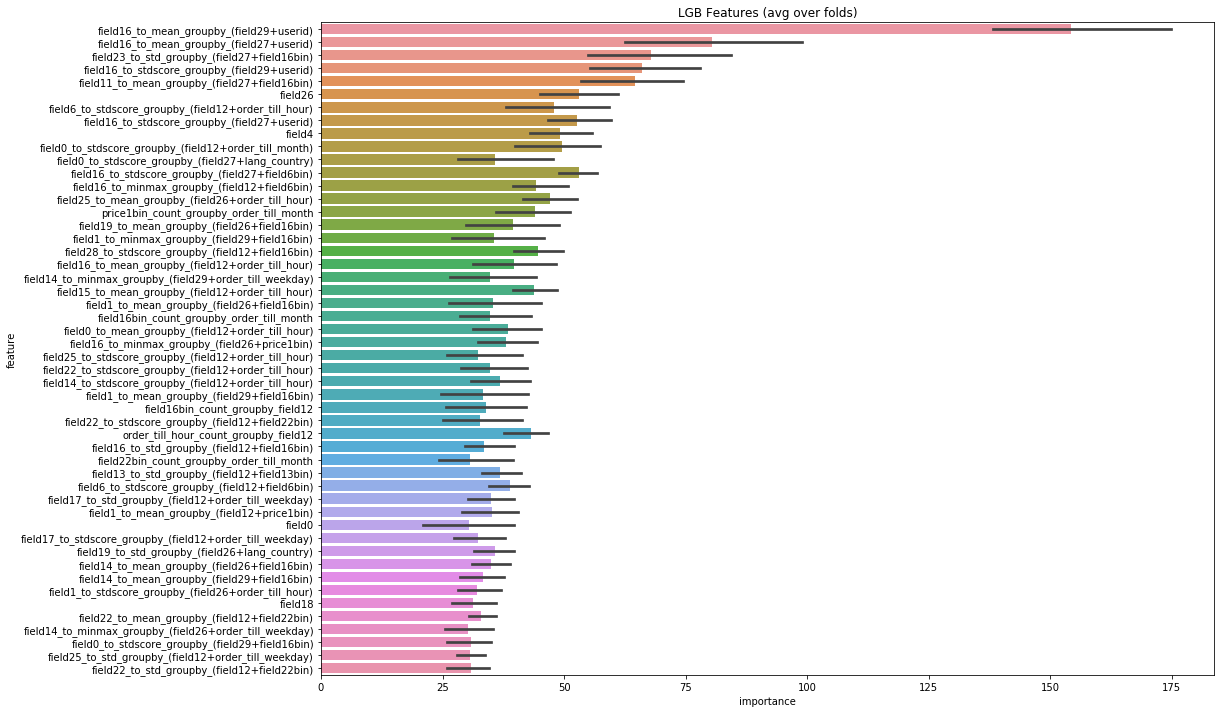

In [18]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Fri Jan  3 21:08:48 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.730488	training's auc: 0.730467	valid_1's auc: 0.659146	valid_1's auc: 0.65916
[200]	training's auc: 0.767492	training's auc: 0.767488	valid_1's auc: 0.66742	valid_1's auc: 0.667414
[300]	training's auc: 0.796697	training's auc: 0.796698	valid_1's auc: 0.672982	valid_1's auc: 0.672978
[400]	training's auc: 0.823394	training's auc: 0.823394	valid_1's auc: 0.675598	valid_1's auc: 0.675597
[500]	training's auc: 0.845877	training's auc: 0.845877	valid_1's auc: 0.675653	valid_1's auc: 0.675653
Early stopping, best iteration is:
[414]	training's auc: 0.826622	training's auc: 0.826623	valid_1's auc: 0.675732	valid_1's auc: 0.675732
Fold 2 started at Fri Jan  3 21:10:31 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.730909	training's auc: 0.73095	valid_1's auc: 0.704397	valid_1's auc: 0.704421
[200]	training's auc: 0.7679

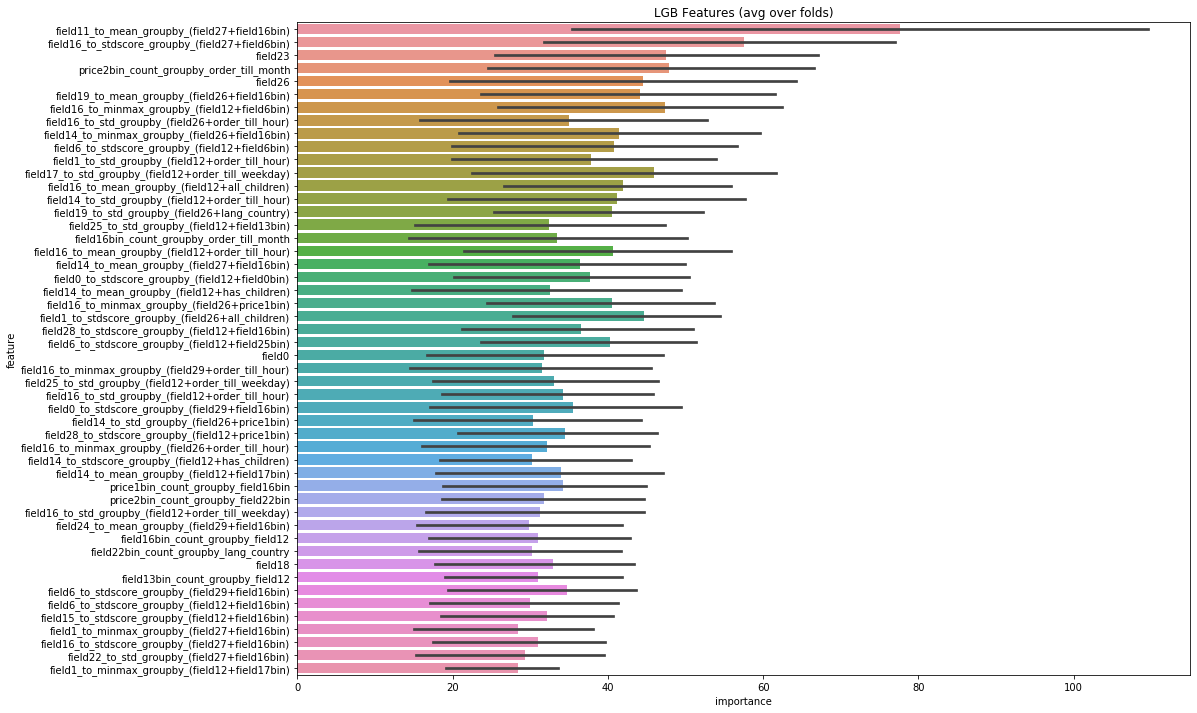

In [33]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Fri Jan  3 20:11:47 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.714071	training's auc: 0.714056	valid_1's auc: 0.653947	valid_1's auc: 0.654007
Early stopping, best iteration is:
[26]	training's auc: 0.691099	training's auc: 0.69106	valid_1's auc: 0.657657	valid_1's auc: 0.657594
Fold 2 started at Fri Jan  3 20:11:57 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.701145	training's auc: 0.701186	valid_1's auc: 0.708607	valid_1's auc: 0.708571
[200]	training's auc: 0.720136	training's auc: 0.720142	valid_1's auc: 0.710664	valid_1's auc: 0.710638
[300]	training's auc: 0.743753	training's auc: 0.743748	valid_1's auc: 0.711764	valid_1's auc: 0.711751
[400]	training's auc: 0.76013	training's auc: 0.760129	valid_1's auc: 0.711556	valid_1's auc: 0.711552
[500]	training's auc: 0.777258	training's auc: 0.777259	valid_1's auc: 0.71371	valid_1's auc: 0.713709
Did not meet early stopping. 

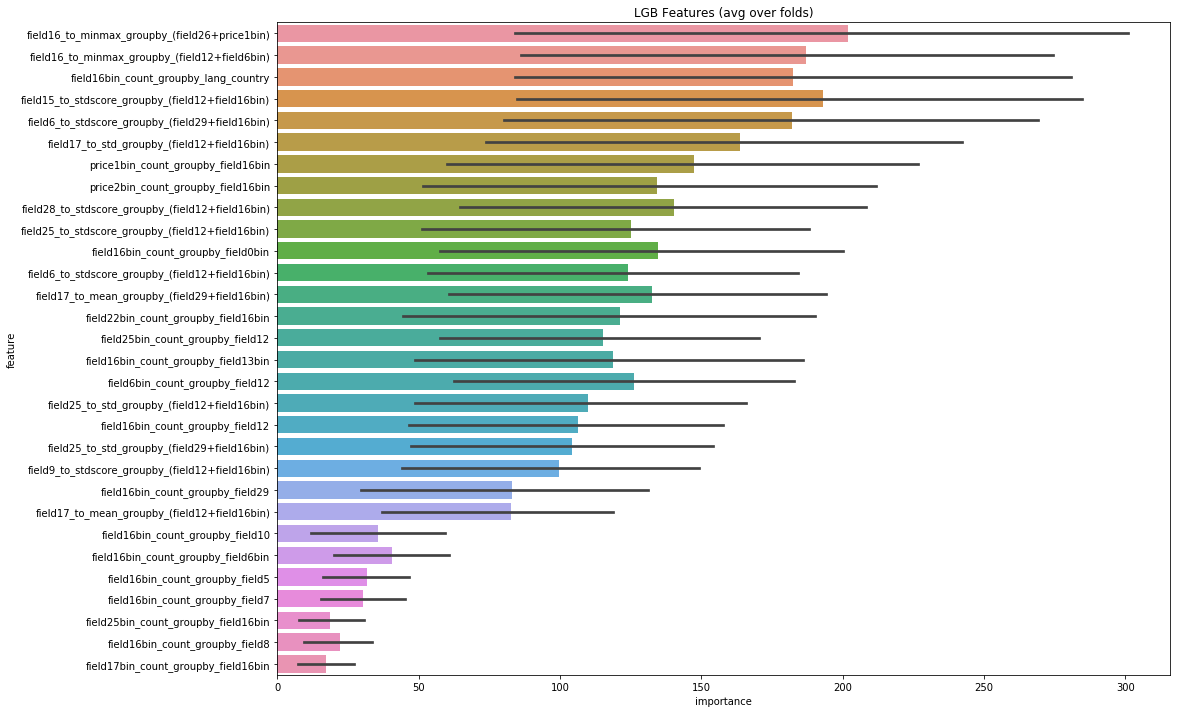

In [17]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Fri Dec 20 08:09:14 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.783373	training's auc: 0.783376	valid_1's auc: 0.672257	valid_1's auc: 0.672271
[200]	training's auc: 0.838349	training's auc: 0.83835	valid_1's auc: 0.681522	valid_1's auc: 0.681522
[300]	training's auc: 0.877625	training's auc: 0.877625	valid_1's auc: 0.68447	valid_1's auc: 0.68447
[400]	training's auc: 0.901645	training's auc: 0.901645	valid_1's auc: 0.684089	valid_1's auc: 0.684089
Early stopping, best iteration is:
[322]	training's auc: 0.884313	training's auc: 0.884313	valid_1's auc: 0.684702	valid_1's auc: 0.684702
Fold 2 started at Fri Dec 20 08:14:27 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.77402	training's auc: 0.774022	valid_1's auc: 0.718327	valid_1's auc: 0.718332
[200]	training's auc: 0.834075	training's auc: 0.834075	valid_1's auc: 0.726482	valid_1's auc: 0.726481
[300]	training's auc: 0.87351

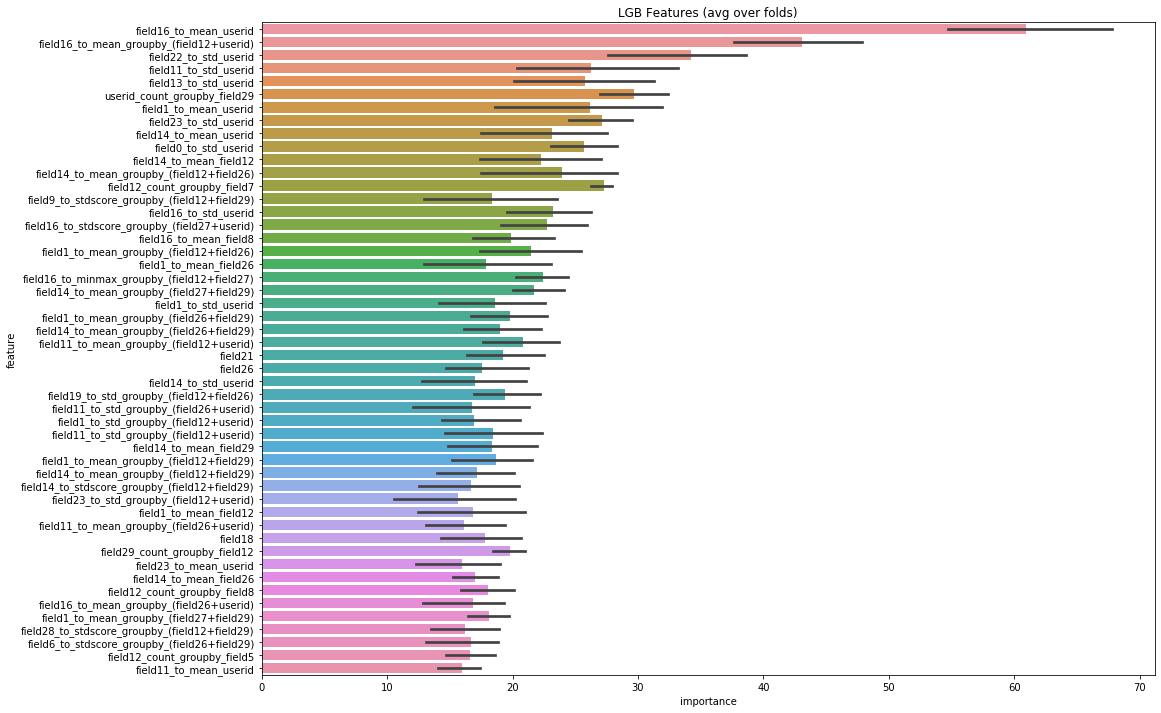

In [72]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

In [11]:
import datetime
t = datetime.datetime.now().strftime("%m-%d-%H-%M")
test['proba'] = result_dict['prediction']
sub = pd.read_csv('data/onetwotrip_challenge_sub1.csv')
sub['proba'] = test['proba'] / test['proba'].max()
sub.reset_index(drop=True).set_index('orderid').to_csv(f'temp/submission-{t}.csv')

import pickle
pickle.dump(result_dict, open(f'temp/submission-{t}.pkl','wb'))

## Goal2

In [10]:
exclude_features_from_training = ['indicator_goal21', 'indicator_goal22', 'indicator_goal23',
       'indicator_goal24', 'indicator_goal25', 'goal21', 'goal22', 'goal23',
       'goal24', 'goal25', 'goal1','userid',]

In [11]:
gc.collect()

11846

In [12]:
sub2 = pd.read_csv('data/onetwotrip_challenge_sub2.csv')

In [13]:
sub2.columns = ['orderid', 'goal21', 'goal22', 'goal23', 'goal24', 'goal25']
sub2 = pd.DataFrame(0, columns=sub2.columns, index=sub2.index)

In [ ]:
from sklearn.model_selection import GroupKFold, KFold

data = best_features
for i_goal in range(1,6):
    print ("Goal ", i_goal)
    data_filtered = data[data[f'indicator_goal2{i_goal}'] == 1]
    X = data_filtered[data_filtered[f'goal2{i_goal}']>=0].drop([f'goal2{i_goal}'], axis=1)
    y = data_filtered[data_filtered[f'goal2{i_goal}']>=0][f'goal2{i_goal}'].astype(np.uint8)
    del data_filtered
    gc.collect()
    test=data[data[f'goal2{i_goal}']<0]
    train_features = [f for f in data.columns if f not in exclude_features_from_training]


    NFOLDS = 5
    folds = RepeatedStratifiedGroupKFold(n_splits=NFOLDS)
    params = {
          "verbosity": -1,
          'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': 12,
          'learning_rate': 0.005,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
             }
    train_options = {
        "model_type":'lgb',
        "params": params,
        "eval_metric":'auc',
        'early_stopping_rounds': 100,
        'n_estimators': 30000,
        'averaging': 'rank',
        'use_groups': False,
        'fold_name': folds.__class__.__name__,
        'n_splits': NFOLDS
        }

    result_dict = train_model_classification_vb( X=X, 
                                                 X_test=test, 
                                                 columns=train_features,
                                                 y=y, 
                                                 params=params, folds=folds,
                                                 model_type=train_options['model_type'], 
                                                 plot_feature_importance=True,
                                                 verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                                 n_estimators=train_options['n_estimators'], 
                                                 averaging=train_options['averaging'],
                                                 groups=X['userid'],
                                                 n_jobs=-1)
    test[f'proba2{i_goal}'] = result_dict['prediction']
    sub2[f'goal2{i_goal}'] = test[f'proba2{i_goal}'] / test[f'proba2{i_goal}'].max()
    
import datetime
t = datetime.datetime.now().strftime("%m-%d-%H-%M")
sub2.drop(['orderid'],axis=1).reset_index(drop=True).to_csv(f'temp/submission2-{t}.csv')

Goal  1
Fold 1 started at Mon Jan 20 22:21:21 2020
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.89892	training's auc: 0.89892	valid_1's auc: 0.718808	valid_1's auc: 0.718808
[200]	training's auc: 0.924637	training's auc: 0.924637	valid_1's auc: 0.721106	valid_1's auc: 0.721106
[300]	training's auc: 0.945091	training's auc: 0.945091	valid_1's auc: 0.722059	valid_1's auc: 0.722059
[400]	training's auc: 0.958906	training's auc: 0.958906	valid_1's auc: 0.72259	valid_1's auc: 0.72259
[500]	training's auc: 0.966925	training's auc: 0.966925	valid_1's auc: 0.72323	valid_1's auc: 0.72323
Early stopping, best iteration is:
[489]	training's auc: 0.966234	training's auc: 0.966234	valid_1's auc: 0.723263	valid_1's auc: 0.723263
Fold 2 started at Mon Jan 20 22:30:16 2020
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.896625	training's auc: 0.896625	valid_1's auc: 0.714534	valid_1's auc: 0.714534
[200]	training's auc: 0.9

Goal  1
Fold 1 started at Mon Jan 20 08:40:23 2020
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.716197	training's auc: 0.716207	valid_1's auc: 0.711352	valid_1's auc: 0.711342
[200]	training's auc: 0.724705	training's auc: 0.724705	valid_1's auc: 0.716594	valid_1's auc: 0.716593
[300]	training's auc: 0.732557	training's auc: 0.732557	valid_1's auc: 0.719434	valid_1's auc: 0.719434
[400]	training's auc: 0.739205	training's auc: 0.739205	valid_1's auc: 0.721054	valid_1's auc: 0.721054
[500]	training's auc: 0.744831	training's auc: 0.744831	valid_1's auc: 0.722518	valid_1's auc: 0.722518
[600]	training's auc: 0.750423	training's auc: 0.750423	valid_1's auc: 0.72377	valid_1's auc: 0.72377
[700]	training's auc: 0.755401	training's auc: 0.755401	valid_1's auc: 0.724518	valid_1's auc: 0.724518
[800]	training's auc: 0.759781	training's auc: 0.759781	valid_1's auc: 0.724979	valid_1's auc: 0.724979
[900]	training's auc: 0.763975	training's auc: 0.763975	v

[400]	training's auc: 0.746566	training's auc: 0.746566	valid_1's auc: 0.688971	valid_1's auc: 0.688971
[500]	training's auc: 0.753031	training's auc: 0.753031	valid_1's auc: 0.689852	valid_1's auc: 0.689852
[600]	training's auc: 0.758264	training's auc: 0.758264	valid_1's auc: 0.69035	valid_1's auc: 0.69035
[700]	training's auc: 0.762551	training's auc: 0.762551	valid_1's auc: 0.690961	valid_1's auc: 0.690961
[800]	training's auc: 0.766477	training's auc: 0.766477	valid_1's auc: 0.691461	valid_1's auc: 0.691461
[900]	training's auc: 0.770198	training's auc: 0.770198	valid_1's auc: 0.692223	valid_1's auc: 0.692223
[1000]	training's auc: 0.773771	training's auc: 0.773771	valid_1's auc: 0.692769	valid_1's auc: 0.692769
[1100]	training's auc: 0.777129	training's auc: 0.777129	valid_1's auc: 0.693359	valid_1's auc: 0.693359
[1200]	training's auc: 0.78042	training's auc: 0.78042	valid_1's auc: 0.693974	valid_1's auc: 0.693974
[1300]	training's auc: 0.783549	training's auc: 0.783549	valid_1'

[1900]	training's auc: 0.743311	training's auc: 0.743311	valid_1's auc: 0.721777	valid_1's auc: 0.721777
[2000]	training's auc: 0.744486	training's auc: 0.744486	valid_1's auc: 0.721904	valid_1's auc: 0.721904
[2100]	training's auc: 0.745635	training's auc: 0.745635	valid_1's auc: 0.722023	valid_1's auc: 0.722023
[2200]	training's auc: 0.74677	training's auc: 0.74677	valid_1's auc: 0.722144	valid_1's auc: 0.722144
[2300]	training's auc: 0.747935	training's auc: 0.747935	valid_1's auc: 0.72227	valid_1's auc: 0.72227
[2400]	training's auc: 0.749022	training's auc: 0.749022	valid_1's auc: 0.72237	valid_1's auc: 0.72237
[2500]	training's auc: 0.750071	training's auc: 0.750071	valid_1's auc: 0.722461	valid_1's auc: 0.722461
[2600]	training's auc: 0.751065	training's auc: 0.751065	valid_1's auc: 0.722513	valid_1's auc: 0.722513
[2700]	training's auc: 0.752049	training's auc: 0.752049	valid_1's auc: 0.722582	valid_1's auc: 0.722582
[2800]	training's auc: 0.753081	training's auc: 0.753081	vali

[1800]	training's auc: 0.742727	training's auc: 0.742727	valid_1's auc: 0.713072	valid_1's auc: 0.713072
[1900]	training's auc: 0.743875	training's auc: 0.743875	valid_1's auc: 0.713301	valid_1's auc: 0.713301
[2000]	training's auc: 0.744964	training's auc: 0.744964	valid_1's auc: 0.713557	valid_1's auc: 0.713557
[2100]	training's auc: 0.746051	training's auc: 0.746051	valid_1's auc: 0.713746	valid_1's auc: 0.713746
[2200]	training's auc: 0.747077	training's auc: 0.747077	valid_1's auc: 0.713903	valid_1's auc: 0.713903
[2300]	training's auc: 0.748128	training's auc: 0.748128	valid_1's auc: 0.714018	valid_1's auc: 0.714018
[2400]	training's auc: 0.749174	training's auc: 0.749174	valid_1's auc: 0.714158	valid_1's auc: 0.714158
[2500]	training's auc: 0.750177	training's auc: 0.750177	valid_1's auc: 0.714302	valid_1's auc: 0.714302
[2600]	training's auc: 0.751172	training's auc: 0.751172	valid_1's auc: 0.714421	valid_1's auc: 0.714421
[2700]	training's auc: 0.752151	training's auc: 0.75215

[2700]	training's auc: 0.751763	training's auc: 0.751763	valid_1's auc: 0.712505	valid_1's auc: 0.712505
[2800]	training's auc: 0.752764	training's auc: 0.752764	valid_1's auc: 0.712589	valid_1's auc: 0.712589
[2900]	training's auc: 0.753755	training's auc: 0.753755	valid_1's auc: 0.712714	valid_1's auc: 0.712714
[3000]	training's auc: 0.754684	training's auc: 0.754684	valid_1's auc: 0.712849	valid_1's auc: 0.712849
[3100]	training's auc: 0.755641	training's auc: 0.755641	valid_1's auc: 0.712877	valid_1's auc: 0.712877
[3200]	training's auc: 0.756591	training's auc: 0.756591	valid_1's auc: 0.712966	valid_1's auc: 0.712966
[3300]	training's auc: 0.757524	training's auc: 0.757524	valid_1's auc: 0.713034	valid_1's auc: 0.713034
[3400]	training's auc: 0.758444	training's auc: 0.758444	valid_1's auc: 0.7131	valid_1's auc: 0.7131
[3500]	training's auc: 0.759302	training's auc: 0.759302	valid_1's auc: 0.713163	valid_1's auc: 0.713163
[3600]	training's auc: 0.760197	training's auc: 0.760197	va

[400]	training's auc: 0.693871	training's auc: 0.693871	valid_1's auc: 0.653073	valid_1's auc: 0.653073
[500]	training's auc: 0.700682	training's auc: 0.700682	valid_1's auc: 0.655689	valid_1's auc: 0.655689
[600]	training's auc: 0.708031	training's auc: 0.708031	valid_1's auc: 0.657907	valid_1's auc: 0.657907
[700]	training's auc: 0.714929	training's auc: 0.714929	valid_1's auc: 0.659522	valid_1's auc: 0.659522
[800]	training's auc: 0.72095	training's auc: 0.72095	valid_1's auc: 0.660714	valid_1's auc: 0.660714
[900]	training's auc: 0.726566	training's auc: 0.726566	valid_1's auc: 0.661488	valid_1's auc: 0.661488
[1000]	training's auc: 0.732132	training's auc: 0.732132	valid_1's auc: 0.662139	valid_1's auc: 0.662139
[1100]	training's auc: 0.737962	training's auc: 0.737962	valid_1's auc: 0.662941	valid_1's auc: 0.662941
[1200]	training's auc: 0.7432	training's auc: 0.7432	valid_1's auc: 0.663578	valid_1's auc: 0.663578
[1300]	training's auc: 0.747934	training's auc: 0.747934	valid_1's 

[100]	training's auc: 0.698724	training's auc: 0.698724	valid_1's auc: 0.653902	valid_1's auc: 0.653902
[200]	training's auc: 0.716368	training's auc: 0.716368	valid_1's auc: 0.661121	valid_1's auc: 0.661121
[300]	training's auc: 0.729037	training's auc: 0.729037	valid_1's auc: 0.665903	valid_1's auc: 0.665902
[400]	training's auc: 0.738093	training's auc: 0.738093	valid_1's auc: 0.669157	valid_1's auc: 0.669157
[500]	training's auc: 0.746135	training's auc: 0.746135	valid_1's auc: 0.672639	valid_1's auc: 0.672639
[600]	training's auc: 0.753407	training's auc: 0.753407	valid_1's auc: 0.674739	valid_1's auc: 0.674739
[700]	training's auc: 0.760733	training's auc: 0.760733	valid_1's auc: 0.677208	valid_1's auc: 0.677208
[800]	training's auc: 0.767499	training's auc: 0.767499	valid_1's auc: 0.679299	valid_1's auc: 0.679299
[900]	training's auc: 0.774582	training's auc: 0.774582	valid_1's auc: 0.680919	valid_1's auc: 0.680919
[1000]	training's auc: 0.781629	training's auc: 0.781629	valid_1

[600]	training's auc: 0.758441	training's auc: 0.758441	valid_1's auc: 0.65626	valid_1's auc: 0.65626
[700]	training's auc: 0.766564	training's auc: 0.766564	valid_1's auc: 0.658146	valid_1's auc: 0.658146
[800]	training's auc: 0.773874	training's auc: 0.773874	valid_1's auc: 0.660009	valid_1's auc: 0.660009
[900]	training's auc: 0.781111	training's auc: 0.781111	valid_1's auc: 0.661551	valid_1's auc: 0.661551
[1000]	training's auc: 0.787584	training's auc: 0.787584	valid_1's auc: 0.662496	valid_1's auc: 0.662496
[1100]	training's auc: 0.793566	training's auc: 0.793566	valid_1's auc: 0.663012	valid_1's auc: 0.663012
[1200]	training's auc: 0.799415	training's auc: 0.799415	valid_1's auc: 0.663466	valid_1's auc: 0.663466
[1300]	training's auc: 0.805054	training's auc: 0.805054	valid_1's auc: 0.66386	valid_1's auc: 0.66386
[1400]	training's auc: 0.809964	training's auc: 0.809964	valid_1's auc: 0.664665	valid_1's auc: 0.664665
[1500]	training's auc: 0.81457	training's auc: 0.81457	valid_1'

[1900]	training's auc: 0.947543	training's auc: 0.947543	valid_1's auc: 0.907389	valid_1's auc: 0.907389
[2000]	training's auc: 0.948631	training's auc: 0.948631	valid_1's auc: 0.907476	valid_1's auc: 0.907476
[2100]	training's auc: 0.949704	training's auc: 0.949704	valid_1's auc: 0.907596	valid_1's auc: 0.907596
[2200]	training's auc: 0.950727	training's auc: 0.950727	valid_1's auc: 0.907678	valid_1's auc: 0.907678
[2300]	training's auc: 0.951692	training's auc: 0.951692	valid_1's auc: 0.907697	valid_1's auc: 0.907697
[2400]	training's auc: 0.952624	training's auc: 0.952624	valid_1's auc: 0.907729	valid_1's auc: 0.907729
[2500]	training's auc: 0.95356	training's auc: 0.95356	valid_1's auc: 0.907744	valid_1's auc: 0.907743
[2600]	training's auc: 0.954487	training's auc: 0.954487	valid_1's auc: 0.907787	valid_1's auc: 0.907787
[2700]	training's auc: 0.955329	training's auc: 0.955329	valid_1's auc: 0.907782	valid_1's auc: 0.907782
[2800]	training's auc: 0.956152	training's auc: 0.956152	

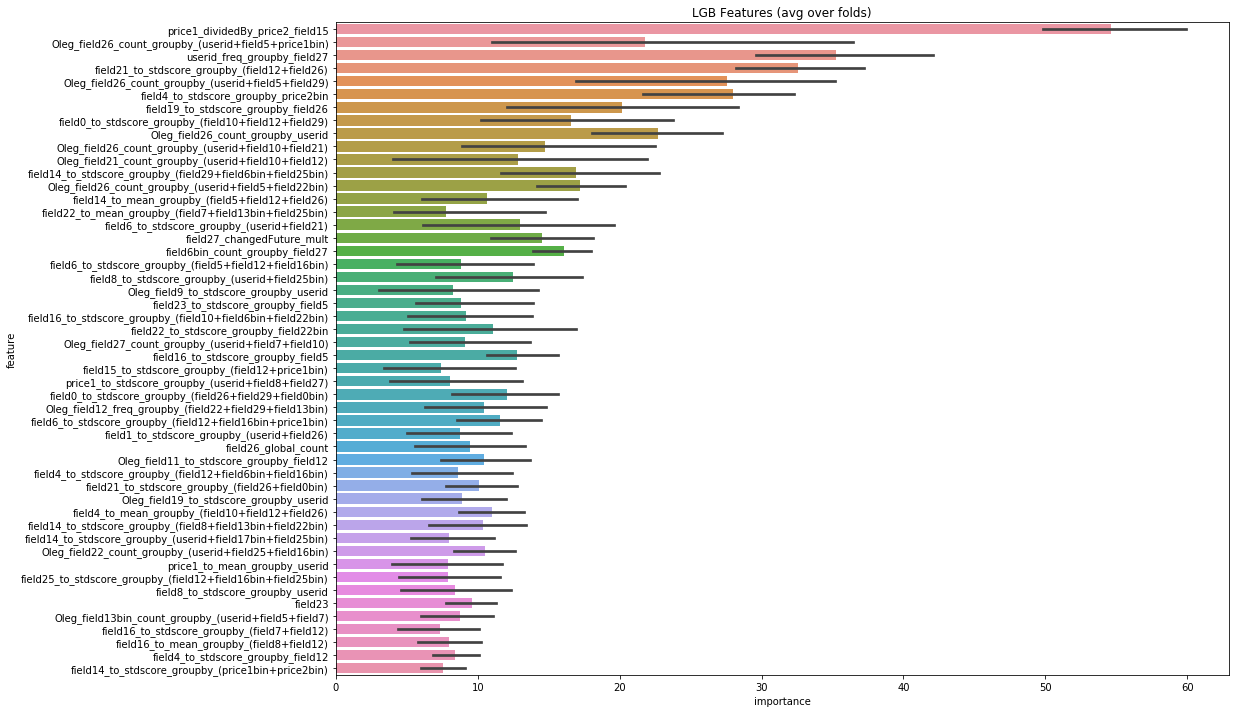

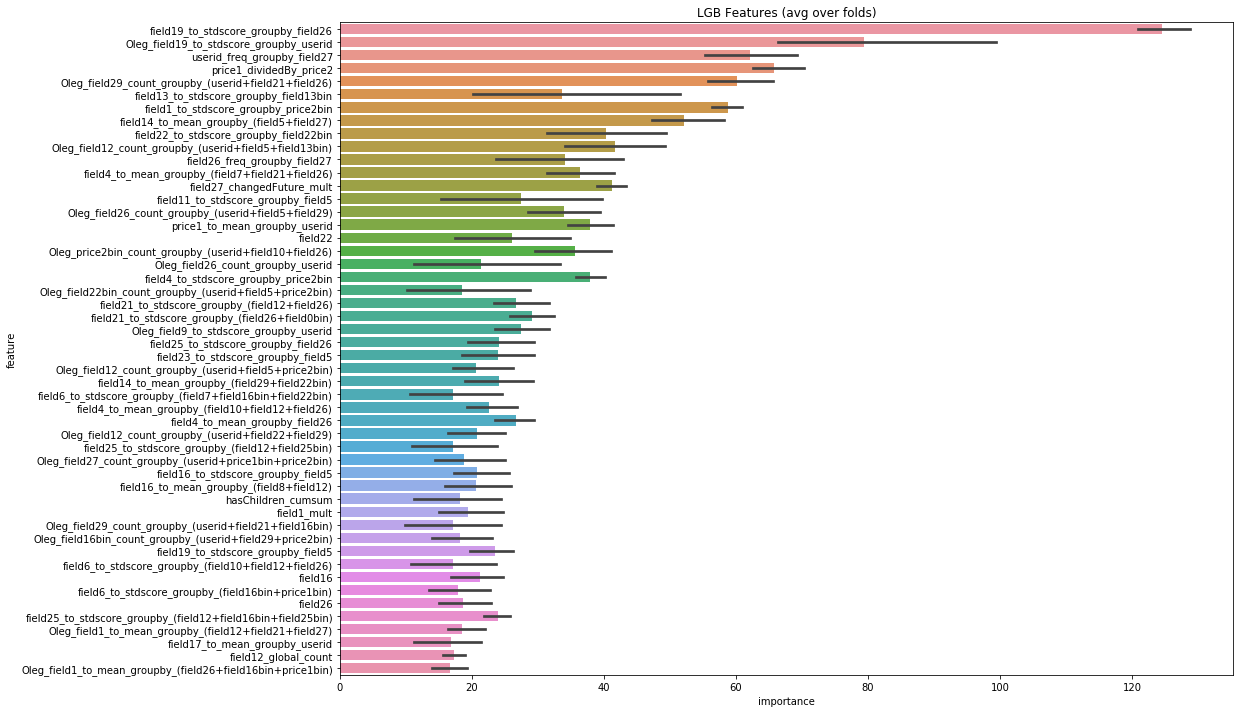

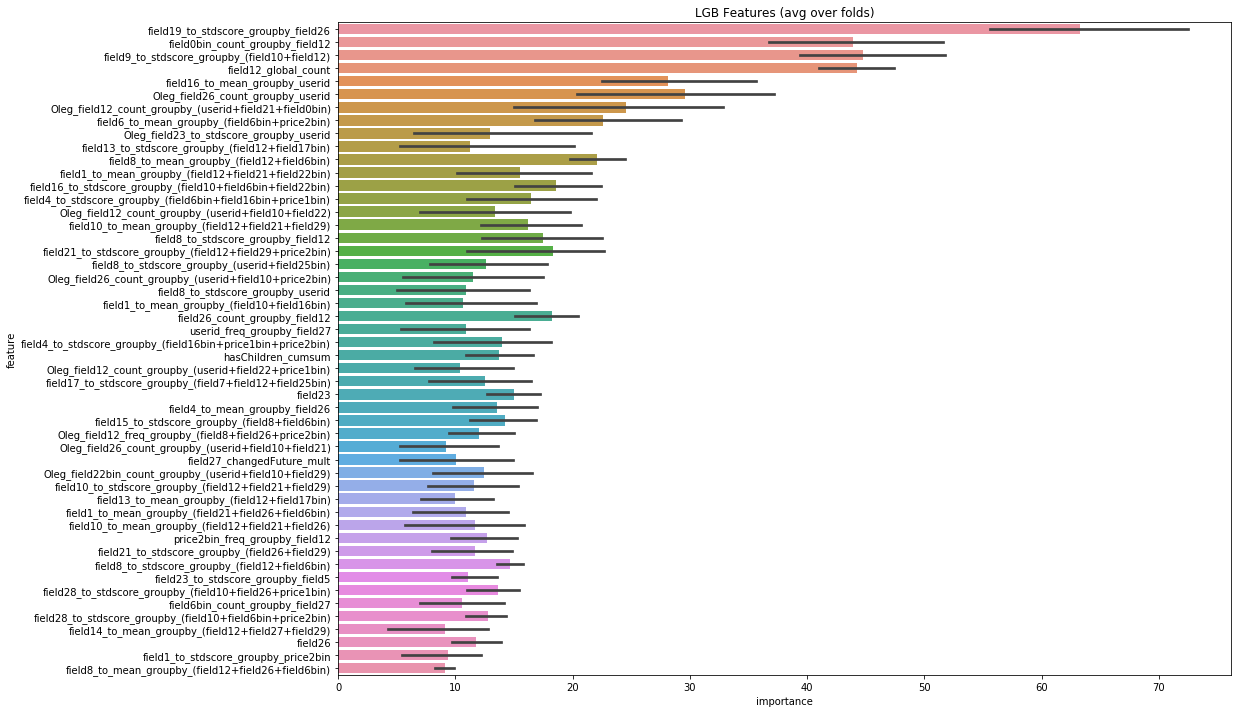

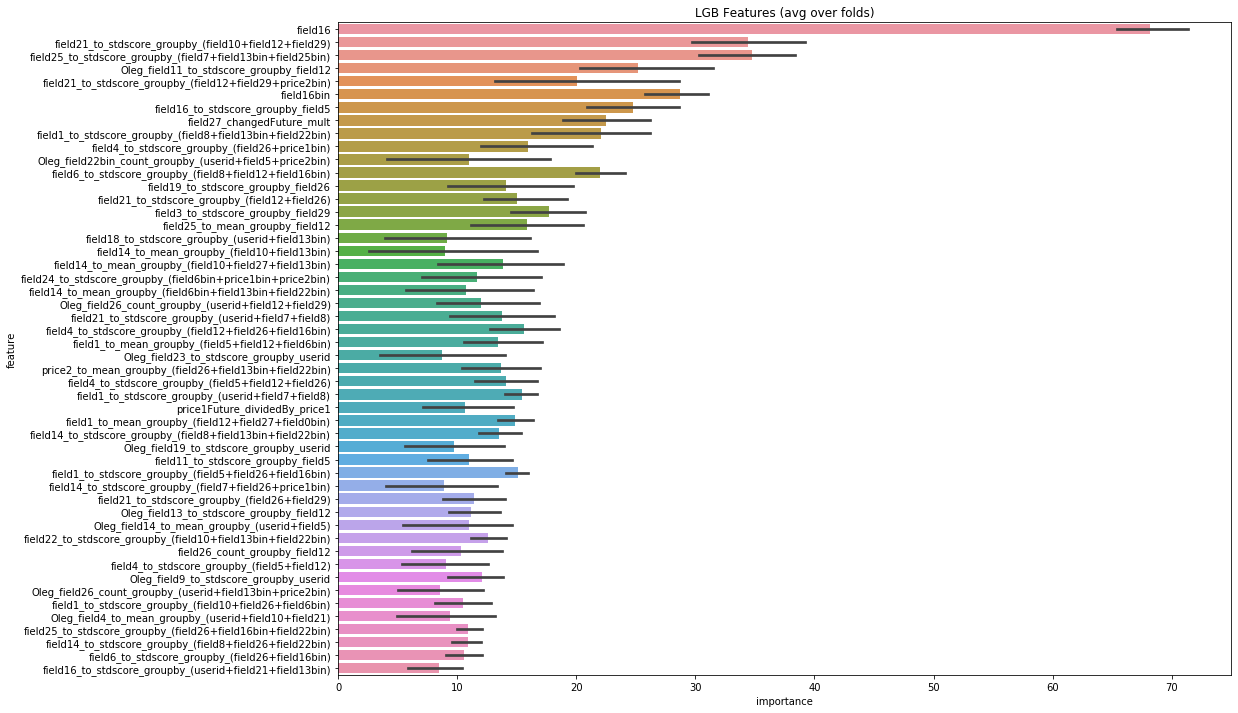

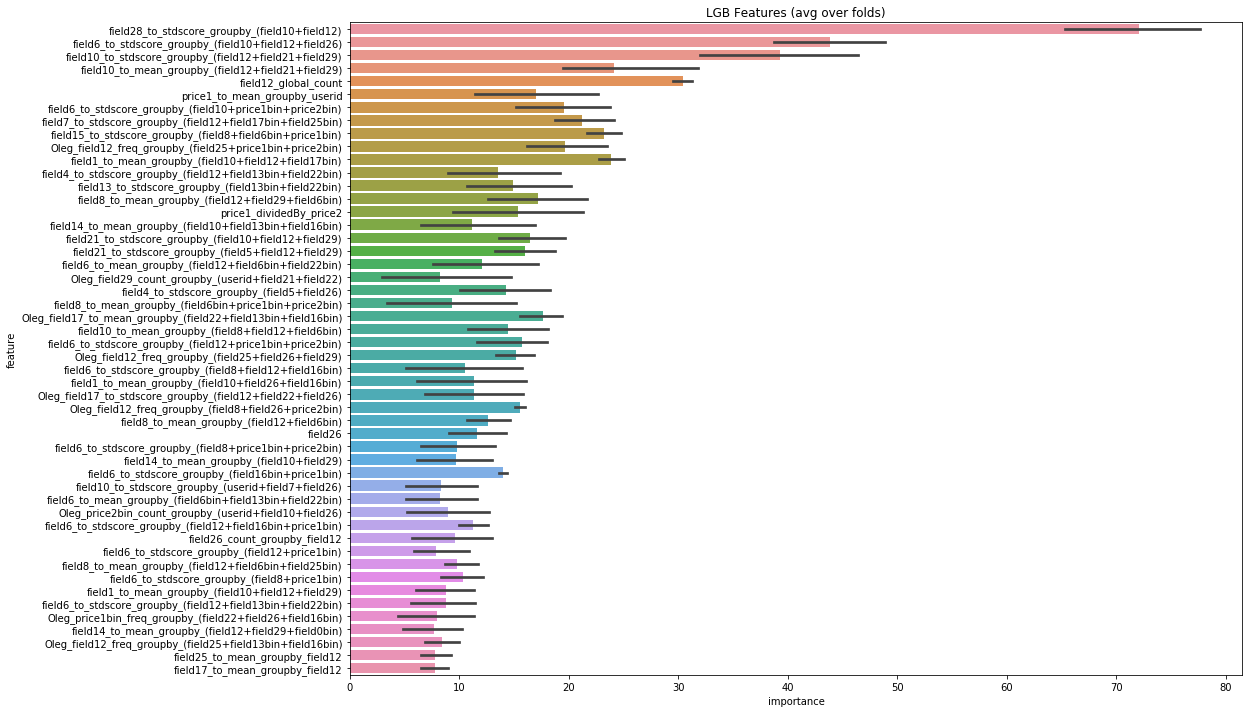

In [19]:
from sklearn.model_selection import GroupKFold, KFold

data = best_features
for i_goal in range(1,6):
    print ("Goal ", i_goal)
    data_filtered = data[data[f'indicator_goal2{i_goal}'] == 1]
    X = data_filtered[data_filtered[f'goal2{i_goal}']>=0].drop([f'goal2{i_goal}'], axis=1)
    y = data_filtered[data_filtered[f'goal2{i_goal}']>=0][f'goal2{i_goal}'].astype(np.uint8)
    del data_filtered
    gc.collect()
    test=data[data[f'goal2{i_goal}']<0]
    train_features = [f for f in data.columns if f not in exclude_features_from_training]


    NFOLDS = 5
    folds = RepeatedStratifiedGroupKFold(n_splits=NFOLDS)
    params = {
          "verbosity": -1,
          'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': 4,
          'learning_rate': 0.005,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
             }
    train_options = {
        "model_type":'lgb',
        "params": params,
        "eval_metric":'auc',
        'early_stopping_rounds': 100,
        'n_estimators': 30000,
        'averaging': 'rank',
        'use_groups': False,
        'fold_name': folds.__class__.__name__,
        'n_splits': NFOLDS
        }

    result_dict = train_model_classification_vb( X=X, 
                                                 X_test=test, 
                                                 columns=train_features,
                                                 y=y, 
                                                 params=params, folds=folds,
                                                 model_type=train_options['model_type'], 
                                                 plot_feature_importance=True,
                                                 verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                                 n_estimators=train_options['n_estimators'], 
                                                 averaging=train_options['averaging'],
                                                 groups=X['userid'],
                                                 n_jobs=-1)
    test[f'proba2{i_goal}'] = result_dict['prediction']
    sub2[f'goal2{i_goal}'] = test[f'proba2{i_goal}'] / test[f'proba2{i_goal}'].max()
    
import datetime
t = datetime.datetime.now().strftime("%m-%d-%H-%M")
sub2.drop(['orderid'],axis=1).reset_index(drop=True).to_csv(f'temp/submission2-{t}.csv')

Goal  1
Fold 1 started at Sun Jan  5 21:15:27 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.71544	training's auc: 0.715442	valid_1's auc: 0.7165	valid_1's auc: 0.716445
[200]	training's auc: 0.72328	training's auc: 0.723281	valid_1's auc: 0.720645	valid_1's auc: 0.720643
[300]	training's auc: 0.730429	training's auc: 0.730429	valid_1's auc: 0.722425	valid_1's auc: 0.722425
[400]	training's auc: 0.737311	training's auc: 0.737311	valid_1's auc: 0.725314	valid_1's auc: 0.725314
[500]	training's auc: 0.742654	training's auc: 0.742654	valid_1's auc: 0.727404	valid_1's auc: 0.727404
[600]	training's auc: 0.746959	training's auc: 0.746959	valid_1's auc: 0.728532	valid_1's auc: 0.728532
[700]	training's auc: 0.751133	training's auc: 0.751133	valid_1's auc: 0.72906	valid_1's auc: 0.72906
[800]	training's auc: 0.755381	training's auc: 0.755381	valid_1's auc: 0.729216	valid_1's auc: 0.729216
[900]	training's auc: 0.759224	training's auc: 0.759224	vali

[1000]	training's auc: 0.770899	training's auc: 0.770899	valid_1's auc: 0.694671	valid_1's auc: 0.694671
[1100]	training's auc: 0.774391	training's auc: 0.774391	valid_1's auc: 0.695147	valid_1's auc: 0.695147
[1200]	training's auc: 0.777412	training's auc: 0.777412	valid_1's auc: 0.695678	valid_1's auc: 0.695678
[1300]	training's auc: 0.780399	training's auc: 0.780399	valid_1's auc: 0.696032	valid_1's auc: 0.696032
[1400]	training's auc: 0.78314	training's auc: 0.78314	valid_1's auc: 0.696323	valid_1's auc: 0.696323
[1500]	training's auc: 0.785783	training's auc: 0.785783	valid_1's auc: 0.69646	valid_1's auc: 0.69646
[1600]	training's auc: 0.788481	training's auc: 0.788481	valid_1's auc: 0.696664	valid_1's auc: 0.696664
[1700]	training's auc: 0.791106	training's auc: 0.791106	valid_1's auc: 0.696784	valid_1's auc: 0.696784
[1800]	training's auc: 0.793636	training's auc: 0.793636	valid_1's auc: 0.696893	valid_1's auc: 0.696893
[1900]	training's auc: 0.795964	training's auc: 0.795964	va

[2300]	training's auc: 0.745588	training's auc: 0.745588	valid_1's auc: 0.724847	valid_1's auc: 0.724847
[2400]	training's auc: 0.746522	training's auc: 0.746522	valid_1's auc: 0.72491	valid_1's auc: 0.72491
[2500]	training's auc: 0.747464	training's auc: 0.747464	valid_1's auc: 0.724991	valid_1's auc: 0.724991
[2600]	training's auc: 0.748405	training's auc: 0.748405	valid_1's auc: 0.725053	valid_1's auc: 0.725053
[2700]	training's auc: 0.749343	training's auc: 0.749343	valid_1's auc: 0.72516	valid_1's auc: 0.72516
[2800]	training's auc: 0.750287	training's auc: 0.750287	valid_1's auc: 0.725217	valid_1's auc: 0.725217
[2900]	training's auc: 0.751168	training's auc: 0.751168	valid_1's auc: 0.725266	valid_1's auc: 0.725266
[3000]	training's auc: 0.752061	training's auc: 0.752061	valid_1's auc: 0.725351	valid_1's auc: 0.725351
Did not meet early stopping. Best iteration is:
[3000]	training's auc: 0.752061	training's auc: 0.752061	valid_1's auc: 0.725351	valid_1's auc: 0.725351
Fold 3 star

[500]	training's auc: 0.724495	training's auc: 0.724495	valid_1's auc: 0.708257	valid_1's auc: 0.708257
[600]	training's auc: 0.726878	training's auc: 0.726878	valid_1's auc: 0.709297	valid_1's auc: 0.709297
[700]	training's auc: 0.729026	training's auc: 0.729026	valid_1's auc: 0.710093	valid_1's auc: 0.710093
[800]	training's auc: 0.730906	training's auc: 0.730906	valid_1's auc: 0.710648	valid_1's auc: 0.710648
[900]	training's auc: 0.732499	training's auc: 0.732499	valid_1's auc: 0.711141	valid_1's auc: 0.711141
[1000]	training's auc: 0.733882	training's auc: 0.733882	valid_1's auc: 0.711634	valid_1's auc: 0.711634
[1100]	training's auc: 0.735188	training's auc: 0.735188	valid_1's auc: 0.712028	valid_1's auc: 0.712028
[1200]	training's auc: 0.736522	training's auc: 0.736522	valid_1's auc: 0.71241	valid_1's auc: 0.71241
[1300]	training's auc: 0.737733	training's auc: 0.737733	valid_1's auc: 0.712748	valid_1's auc: 0.712748
[1400]	training's auc: 0.738829	training's auc: 0.738829	valid

[1500]	training's auc: 0.755849	training's auc: 0.755849	valid_1's auc: 0.667482	valid_1's auc: 0.667482
[1600]	training's auc: 0.759691	training's auc: 0.759691	valid_1's auc: 0.667777	valid_1's auc: 0.667777
[1700]	training's auc: 0.763143	training's auc: 0.763143	valid_1's auc: 0.668026	valid_1's auc: 0.668026
[1800]	training's auc: 0.766791	training's auc: 0.766791	valid_1's auc: 0.66827	valid_1's auc: 0.66827
[1900]	training's auc: 0.769942	training's auc: 0.769942	valid_1's auc: 0.668355	valid_1's auc: 0.668355
[2000]	training's auc: 0.773077	training's auc: 0.773077	valid_1's auc: 0.668621	valid_1's auc: 0.668621
Early stopping, best iteration is:
[1988]	training's auc: 0.772698	training's auc: 0.772698	valid_1's auc: 0.668667	valid_1's auc: 0.668667
Fold 4 started at Sun Jan  5 22:24:34 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.678378	training's auc: 0.678379	valid_1's auc: 0.6622	valid_1's auc: 0.6622
[200]	training's auc: 0.68

Fold 2 started at Sun Jan  5 22:34:10 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.702526	training's auc: 0.702526	valid_1's auc: 0.646091	valid_1's auc: 0.646091
[200]	training's auc: 0.714437	training's auc: 0.714437	valid_1's auc: 0.65212	valid_1's auc: 0.65212
[300]	training's auc: 0.727819	training's auc: 0.727819	valid_1's auc: 0.657602	valid_1's auc: 0.657602
[400]	training's auc: 0.737759	training's auc: 0.737759	valid_1's auc: 0.662157	valid_1's auc: 0.662157
[500]	training's auc: 0.746785	training's auc: 0.746785	valid_1's auc: 0.664936	valid_1's auc: 0.664936
[600]	training's auc: 0.754714	training's auc: 0.754714	valid_1's auc: 0.667104	valid_1's auc: 0.667104
[700]	training's auc: 0.761998	training's auc: 0.761998	valid_1's auc: 0.668617	valid_1's auc: 0.668617
[800]	training's auc: 0.768612	training's auc: 0.768612	valid_1's auc: 0.669947	valid_1's auc: 0.669947
[900]	training's auc: 0.774611	training's auc: 0.774611	valid_1'

[1100]	training's auc: 0.784357	training's auc: 0.784357	valid_1's auc: 0.676716	valid_1's auc: 0.676716
[1200]	training's auc: 0.789231	training's auc: 0.789231	valid_1's auc: 0.676913	valid_1's auc: 0.676913
[1300]	training's auc: 0.79399	training's auc: 0.79399	valid_1's auc: 0.677224	valid_1's auc: 0.677224
[1400]	training's auc: 0.798475	training's auc: 0.798475	valid_1's auc: 0.677689	valid_1's auc: 0.677689
[1500]	training's auc: 0.802628	training's auc: 0.802628	valid_1's auc: 0.678371	valid_1's auc: 0.678371
[1600]	training's auc: 0.807188	training's auc: 0.807188	valid_1's auc: 0.678665	valid_1's auc: 0.678665
[1700]	training's auc: 0.811199	training's auc: 0.811199	valid_1's auc: 0.678805	valid_1's auc: 0.678805
[1800]	training's auc: 0.814764	training's auc: 0.814764	valid_1's auc: 0.679059	valid_1's auc: 0.679059
[1900]	training's auc: 0.818146	training's auc: 0.818146	valid_1's auc: 0.679291	valid_1's auc: 0.679291
[2000]	training's auc: 0.821767	training's auc: 0.821767	

[2000]	training's auc: 0.947257	training's auc: 0.947257	valid_1's auc: 0.908952	valid_1's auc: 0.908952
[2100]	training's auc: 0.948362	training's auc: 0.948362	valid_1's auc: 0.908926	valid_1's auc: 0.908926
Early stopping, best iteration is:
[2030]	training's auc: 0.947615	training's auc: 0.947615	valid_1's auc: 0.908999	valid_1's auc: 0.908999
Fold 4 started at Sun Jan  5 23:01:39 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.904453	training's auc: 0.904481	valid_1's auc: 0.900671	valid_1's auc: 0.900631
[200]	training's auc: 0.909079	training's auc: 0.909081	valid_1's auc: 0.903261	valid_1's auc: 0.903261
[300]	training's auc: 0.913021	training's auc: 0.913021	valid_1's auc: 0.90513	valid_1's auc: 0.90513
[400]	training's auc: 0.916918	training's auc: 0.916918	valid_1's auc: 0.906376	valid_1's auc: 0.906376
[500]	training's auc: 0.920156	training's auc: 0.920156	valid_1's auc: 0.907505	valid_1's auc: 0.907505
[600]	training's auc: 0.92

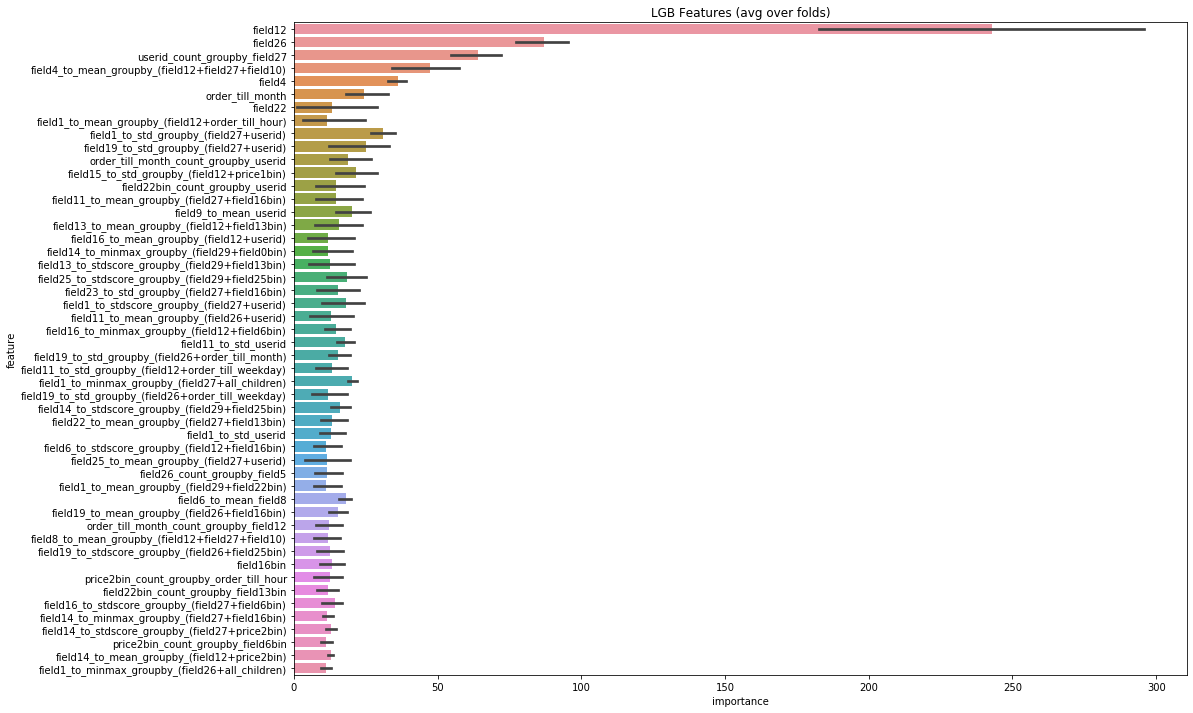

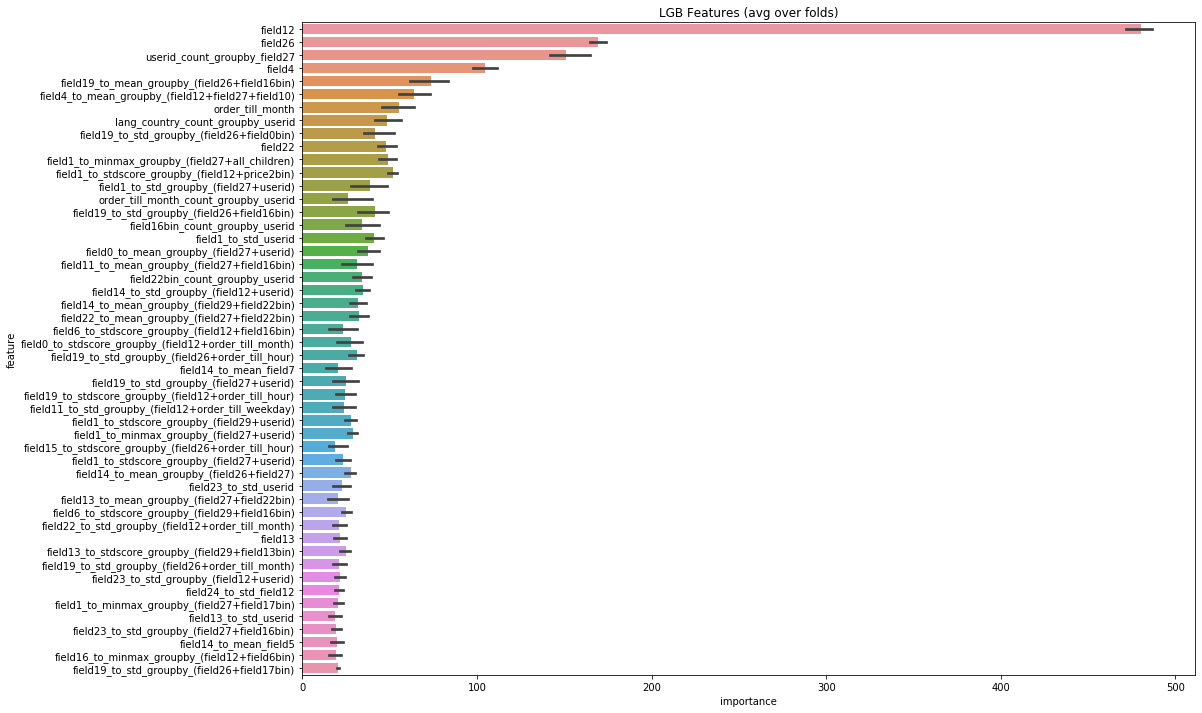

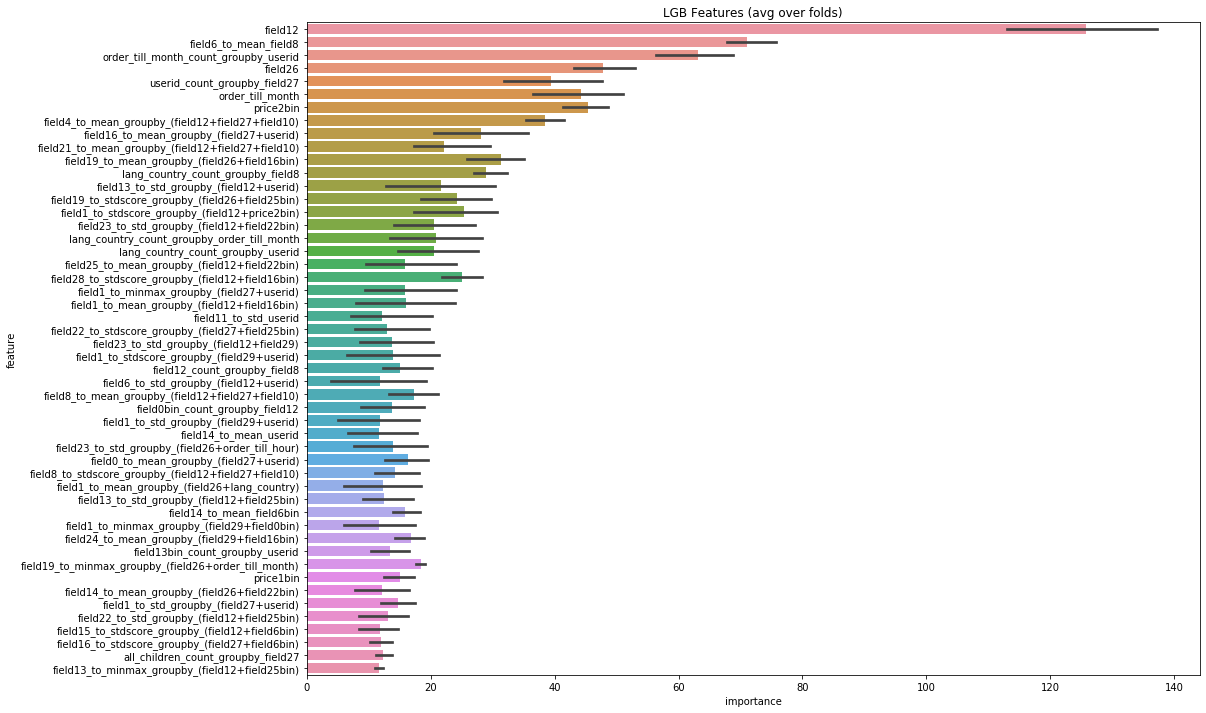

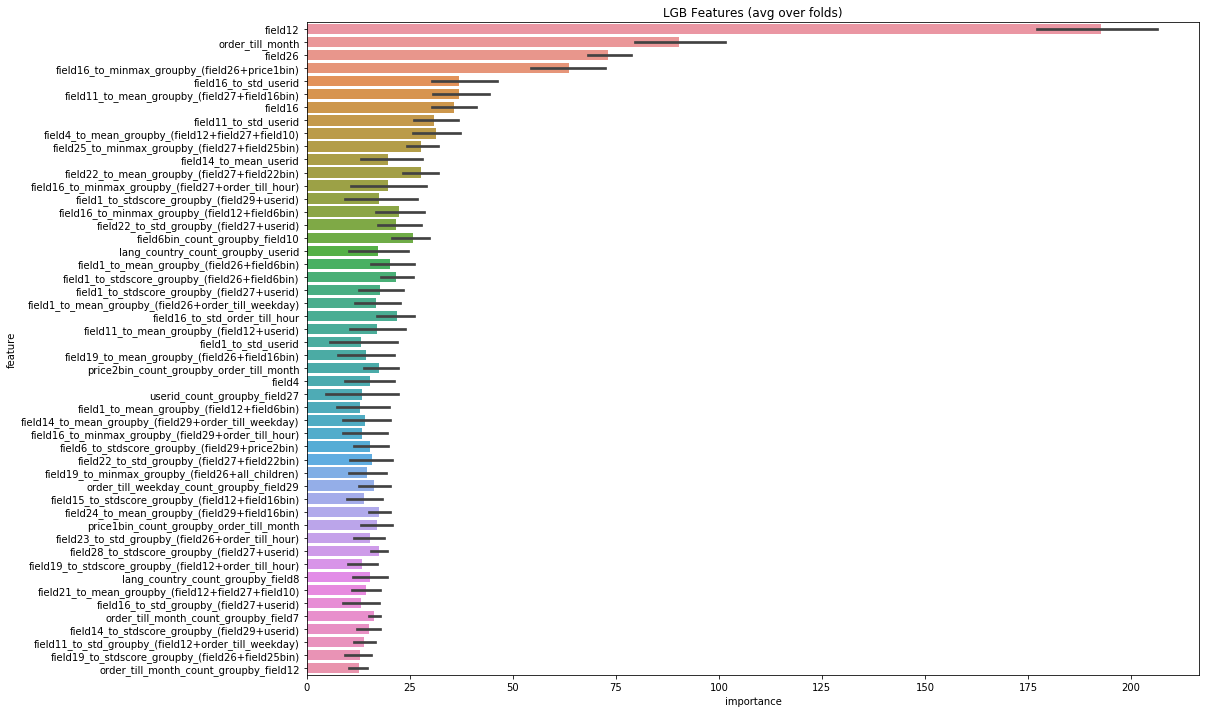

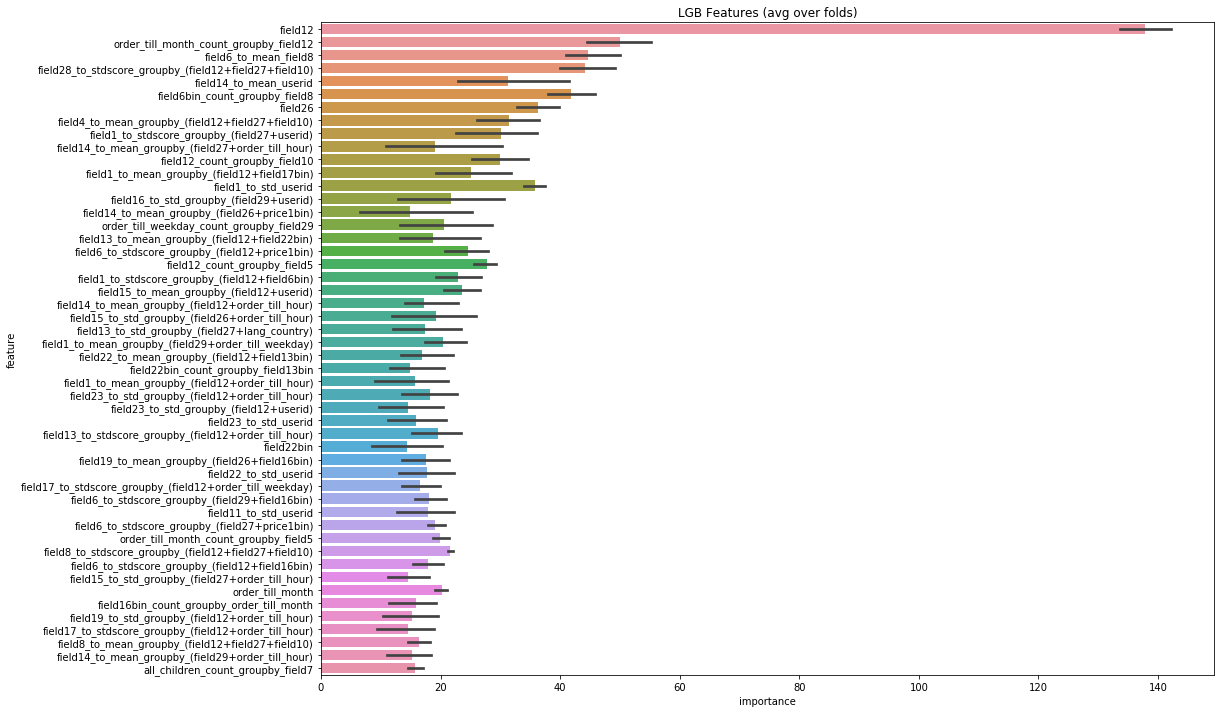

In [47]:
from sklearn.model_selection import GroupKFold, KFold

data = best_features
for i_goal in range(1,6):
    print ("Goal ", i_goal)
    data_filtered = data[data[f'indicator_goal2{i_goal}'] == 1]
    X = data_filtered[data_filtered[f'goal2{i_goal}']>=0].drop([f'goal2{i_goal}'], axis=1)
    y = data_filtered[data_filtered[f'goal2{i_goal}']>=0][f'goal2{i_goal}'].astype(np.uint8)
    del data_filtered
    gc.collect()
    test=data[data[f'goal2{i_goal}']<0]
    train_features = [f for f in data.columns if f not in exclude_features_from_training]


    NFOLDS = 5
    folds = RepeatedStratifiedGroupKFold(n_splits=NFOLDS)
    params = {
          "verbosity": -1,
          'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': 4,
          'learning_rate': 0.005,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
             }
    train_options = {
        "model_type":'lgb',
        "params": params,
        "eval_metric":'auc',
        'early_stopping_rounds': 100,
        'n_estimators': 3000,
        'averaging': 'rank',
        'use_groups': False,
        'fold_name': folds.__class__.__name__,
        'n_splits': NFOLDS
        }

    result_dict = train_model_classification_vb( X=X, 
                                                 X_test=test, 
                                                 columns=train_features,
                                                 y=y, 
                                                 params=params, folds=folds,
                                                 model_type=train_options['model_type'], 
                                                 plot_feature_importance=True,
                                                 verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                                 n_estimators=train_options['n_estimators'], 
                                                 averaging=train_options['averaging'],
                                                 groups=X['userid'],
                                                 n_jobs=-1)
    test[f'proba2{i_goal}'] = result_dict['prediction']
    sub2[f'goal2{i_goal}'] = test[f'proba2{i_goal}'] / test[f'proba2{i_goal}'].max()
    
import datetime
t = datetime.datetime.now().strftime("%m-%d-%H-%M")
sub2.reset_index(drop=True).to_csv(f'temp/submission2-{t}.csv')

In [20]:
t = datetime.datetime.now().strftime("%m-%d-%H-%M")
sub2.drop(['orderid'],axis=1).reset_index(drop=True).to_csv(f'temp/submission2-{t}.csv')

## Results

### NO FE. initial

Fold 1 started at Sun Dec 15 19:17:47 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.8352	training's auc: 0.8352	valid_1's auc: 0.660413	valid_1's auc: 0.660413
Early stopping, best iteration is:
[36]	training's auc: 0.769533	training's auc: 0.769533	valid_1's auc: 0.671052	valid_1's auc: 0.671052
Fold 2 started at Sun Dec 15 19:17:58 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.832962	training's auc: 0.832962	valid_1's auc: 0.708005	valid_1's auc: 0.708005
Early stopping, best iteration is:
[27]	training's auc: 0.742707	training's auc: 0.742708	valid_1's auc: 0.71381	valid_1's auc: 0.713811
Fold 3 started at Sun Dec 15 19:18:06 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.833846	training's auc: 0.833846	valid_1's auc: 0.684287	valid_1's auc: 0.684287
Early stopping, best iteration is:
[28]	training's auc: 0.753781	training's auc: 0.753782	valid_1's

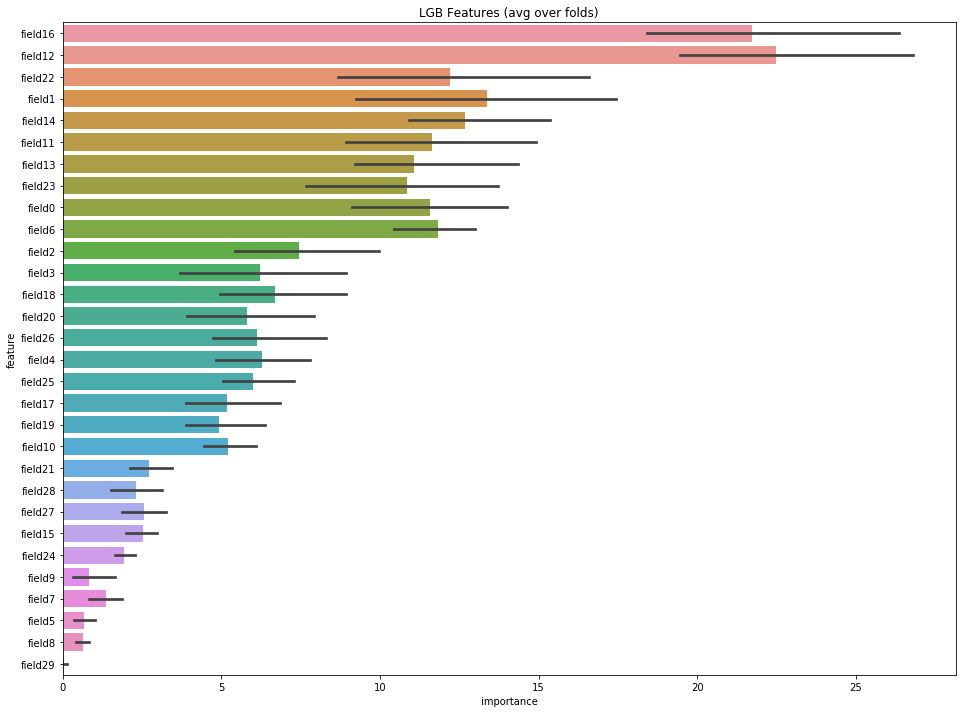

In [22]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

### add first aggregate node

Fold 1 started at Sun Dec 15 20:21:06 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.892444	training's auc: 0.892444	valid_1's auc: 0.672213	valid_1's auc: 0.672213
Early stopping, best iteration is:
[67]	training's auc: 0.857729	training's auc: 0.857729	valid_1's auc: 0.676682	valid_1's auc: 0.676682
Fold 2 started at Sun Dec 15 20:21:38 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.890783	training's auc: 0.890783	valid_1's auc: 0.705956	valid_1's auc: 0.705956
Early stopping, best iteration is:
[40]	training's auc: 0.817173	training's auc: 0.817173	valid_1's auc: 0.72028	valid_1's auc: 0.720279
Fold 3 started at Sun Dec 15 20:22:05 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.890927	training's auc: 0.890927	valid_1's auc: 0.688385	valid_1's auc: 0.688385
Early stopping, best iteration is:
[33]	training's auc: 0.803194	training's auc: 0.803194	valid

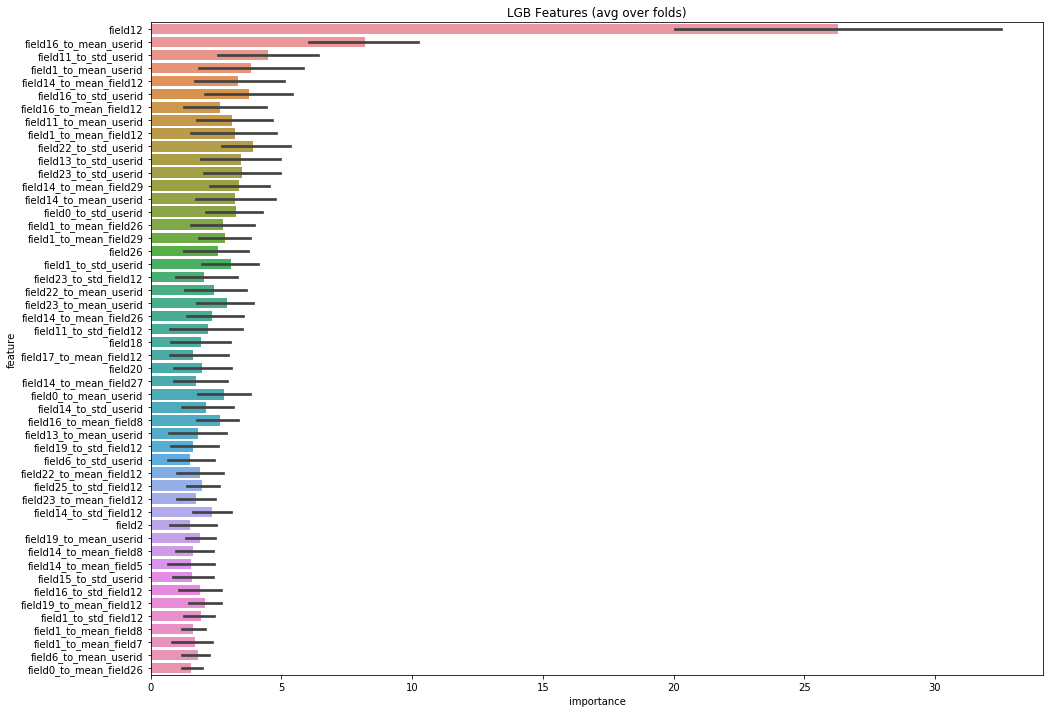

In [13]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

### More aggregates

Fold 1 started at Mon Dec 16 23:23:56 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.904606	training's auc: 0.904606	valid_1's auc: 0.671887	valid_1's auc: 0.671887
Early stopping, best iteration is:
[50]	training's auc: 0.847829	training's auc: 0.847829	valid_1's auc: 0.676644	valid_1's auc: 0.676644
Fold 2 started at Mon Dec 16 23:24:55 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.900505	training's auc: 0.900505	valid_1's auc: 0.712615	valid_1's auc: 0.712615
Early stopping, best iteration is:
[34]	training's auc: 0.810291	training's auc: 0.810291	valid_1's auc: 0.718987	valid_1's auc: 0.718985
Fold 3 started at Mon Dec 16 23:25:42 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.900145	training's auc: 0.900145	valid_1's auc: 0.694774	valid_1's auc: 0.694774
Early stopping, best iteration is:
[46]	training's auc: 0.84242	training's auc: 0.84242	valid_

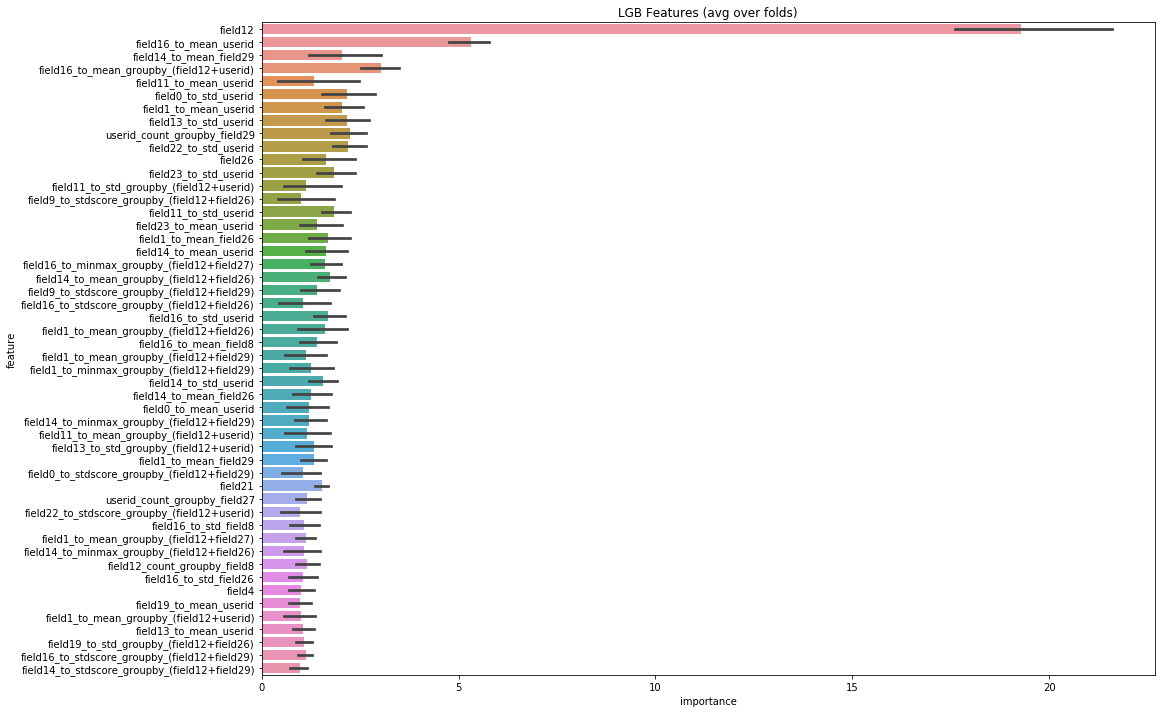

In [15]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

### Aggs+rfe+tune params (0.6847) - submission_rfe-12-19-20-54.csv

Fold 1 started at Wed Dec 18 21:29:43 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.784354	training's auc: 0.784353	valid_1's auc: 0.671344	valid_1's auc: 0.671339
[200]	training's auc: 0.828908	training's auc: 0.828908	valid_1's auc: 0.676033	valid_1's auc: 0.676032
[300]	training's auc: 0.866599	training's auc: 0.866599	valid_1's auc: 0.678715	valid_1's auc: 0.678715
[400]	training's auc: 0.894881	training's auc: 0.894881	valid_1's auc: 0.679986	valid_1's auc: 0.679986
[500]	training's auc: 0.91094	training's auc: 0.91094	valid_1's auc: 0.67955	valid_1's auc: 0.67955
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.91094	training's auc: 0.91094	valid_1's auc: 0.67955	valid_1's auc: 0.67955
Fold 2 started at Wed Dec 18 21:32:46 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.771693	training's auc: 0.771689	valid_1's auc: 0.712078	valid_1's auc: 0.71208
[200]	training's auc:

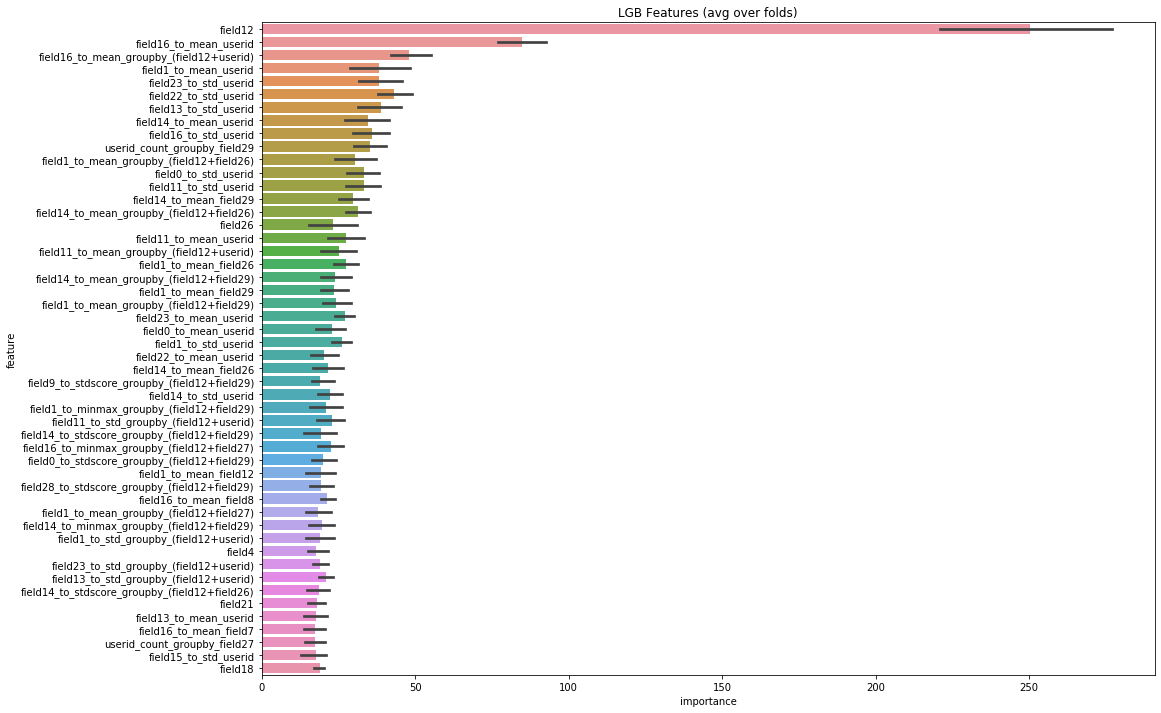

In [19]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)